# IMPLEMENTEZ UN MODELE DE SCORING

Les données d'entraînement sont accompagnées de la cible TARGET indiquant:

*   0 : le prêt a été remboursé ou,
*   1 : le prêt n'a pas été remboursé.

## SOMMAIRE

### A - IMPORTATION DES LIBRAIRIES

In [1]:
import sys
print(sys.executable)

c:\Users\herbett\AppData\Local\Programs\Python\Python311\python.exe


In [2]:
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import time
import math
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import average_precision_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier

import mlflow
from mlflow.exceptions import MlflowException
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from lightgbm import LGBMClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import missingno as msno
import scipy
from scipy.stats import skew
from scipy.stats import shapiro
from scipy.stats import kurtosis
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

from sklearn.preprocessing import LabelEncoder

### B - IMPORTATION DES DATASETS

In [3]:
pos_cash_balance = pd.read_csv(r'C:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Implementez_un_modele_de_scoring\data\POS_CASH_balance.csv')
application_test = pd.read_csv(r'C:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Implementez_un_modele_de_scoring\data\application_test.csv')
application_train = pd.read_csv(r'C:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Implementez_un_modele_de_scoring\data\application_train.csv')
bureau = pd.read_csv(r'C:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Implementez_un_modele_de_scoring\data\bureau.csv')
bureau_balance = pd.read_csv(r'C:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Implementez_un_modele_de_scoring\data\bureau_balance.csv')
credit_card_balance = pd.read_csv(r'C:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Implementez_un_modele_de_scoring\data\credit_card_balance.csv')
previous_application = pd.read_csv(r'C:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Implementez_un_modele_de_scoring\data\previous_application.csv')
installments_payments = pd.read_csv(r'C:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Implementez_un_modele_de_scoring\data\installments_payments.csv')
sample_submission = pd.read_csv(r'C:\Users\herbett\OneDrive - LEMKEN GmbH & Co.KG\Documents\Data_Science_OC\Implementez_un_modele_de_scoring\data\sample_submission.csv')


### C - ANALYSE EXPLORATOIRE DES DONNEES

In [4]:
list_dfs = [pos_cash_balance, application_test, application_train, bureau, bureau_balance, credit_card_balance, previous_application, installments_payments, sample_submission]
list_dfs_title = ['pos_cash_balance', 'application_test', 'application_train', 'bureau', 'bureau_balance', 'credit_card_balance', 'previous_application', 'installments_payments', 'sample_submission']
for df, title in zip(list_dfs, list_dfs_title):
  print(title)
  print()
  display(df.head())
  print("-" * 30)

pos_cash_balance



SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

------------------------------
application_test



SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

------------------------------
application_train



SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

------------------------------
bureau



SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

------------------------------
bureau_balance



SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

------------------------------
credit_card_balance



SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

------------------------------
previous_application



SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

------------------------------
installments_payments



SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

------------------------------
sample_submission



SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

------------------------------


In [5]:
for df, title in zip(list_dfs, list_dfs_title):
  print(title)
  print()
  print(df.shape)
  print("-" * 30)

pos_cash_balance

(10001358, 8)
------------------------------
application_test

(48744, 121)
------------------------------
application_train

(307511, 122)
------------------------------
bureau

(1716428, 17)
------------------------------
bureau_balance

(27299925, 3)
------------------------------
credit_card_balance

(3840312, 23)
------------------------------
previous_application

(1670214, 37)
------------------------------
installments_payments

(13605401, 8)
------------------------------
sample_submission

(48744, 2)
------------------------------


In [6]:
for df, title in zip(list_dfs, list_dfs_title):
  print(title)
  print()
  print(df.info())
  print("-" * 30)

pos_cash_balance

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB
None
------------------------------
application_test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None
------------------------------
application_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_B

#### 1 - Valeurs manquantes

In [7]:
for df, title in zip(list_dfs, list_dfs_title):
  print(title)
  print()
  print(df.isna().sum())
  print("-" * 30)

pos_cash_balance

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64
------------------------------
application_test

SK_ID_CURR                       0
NAME_CONTRACT_TYPE               0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  0
                              ... 
AMT_REQ_CREDIT_BUREAU_DAY     6049
AMT_REQ_CREDIT_BUREAU_WEEK    6049
AMT_REQ_CREDIT_BUREAU_MON     6049
AMT_REQ_CREDIT_BUREAU_QRT     6049
AMT_REQ_CREDIT_BUREAU_YEAR    6049
Length: 121, dtype: int64
------------------------------
application_train

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              .

Application_train valeurs manquantes

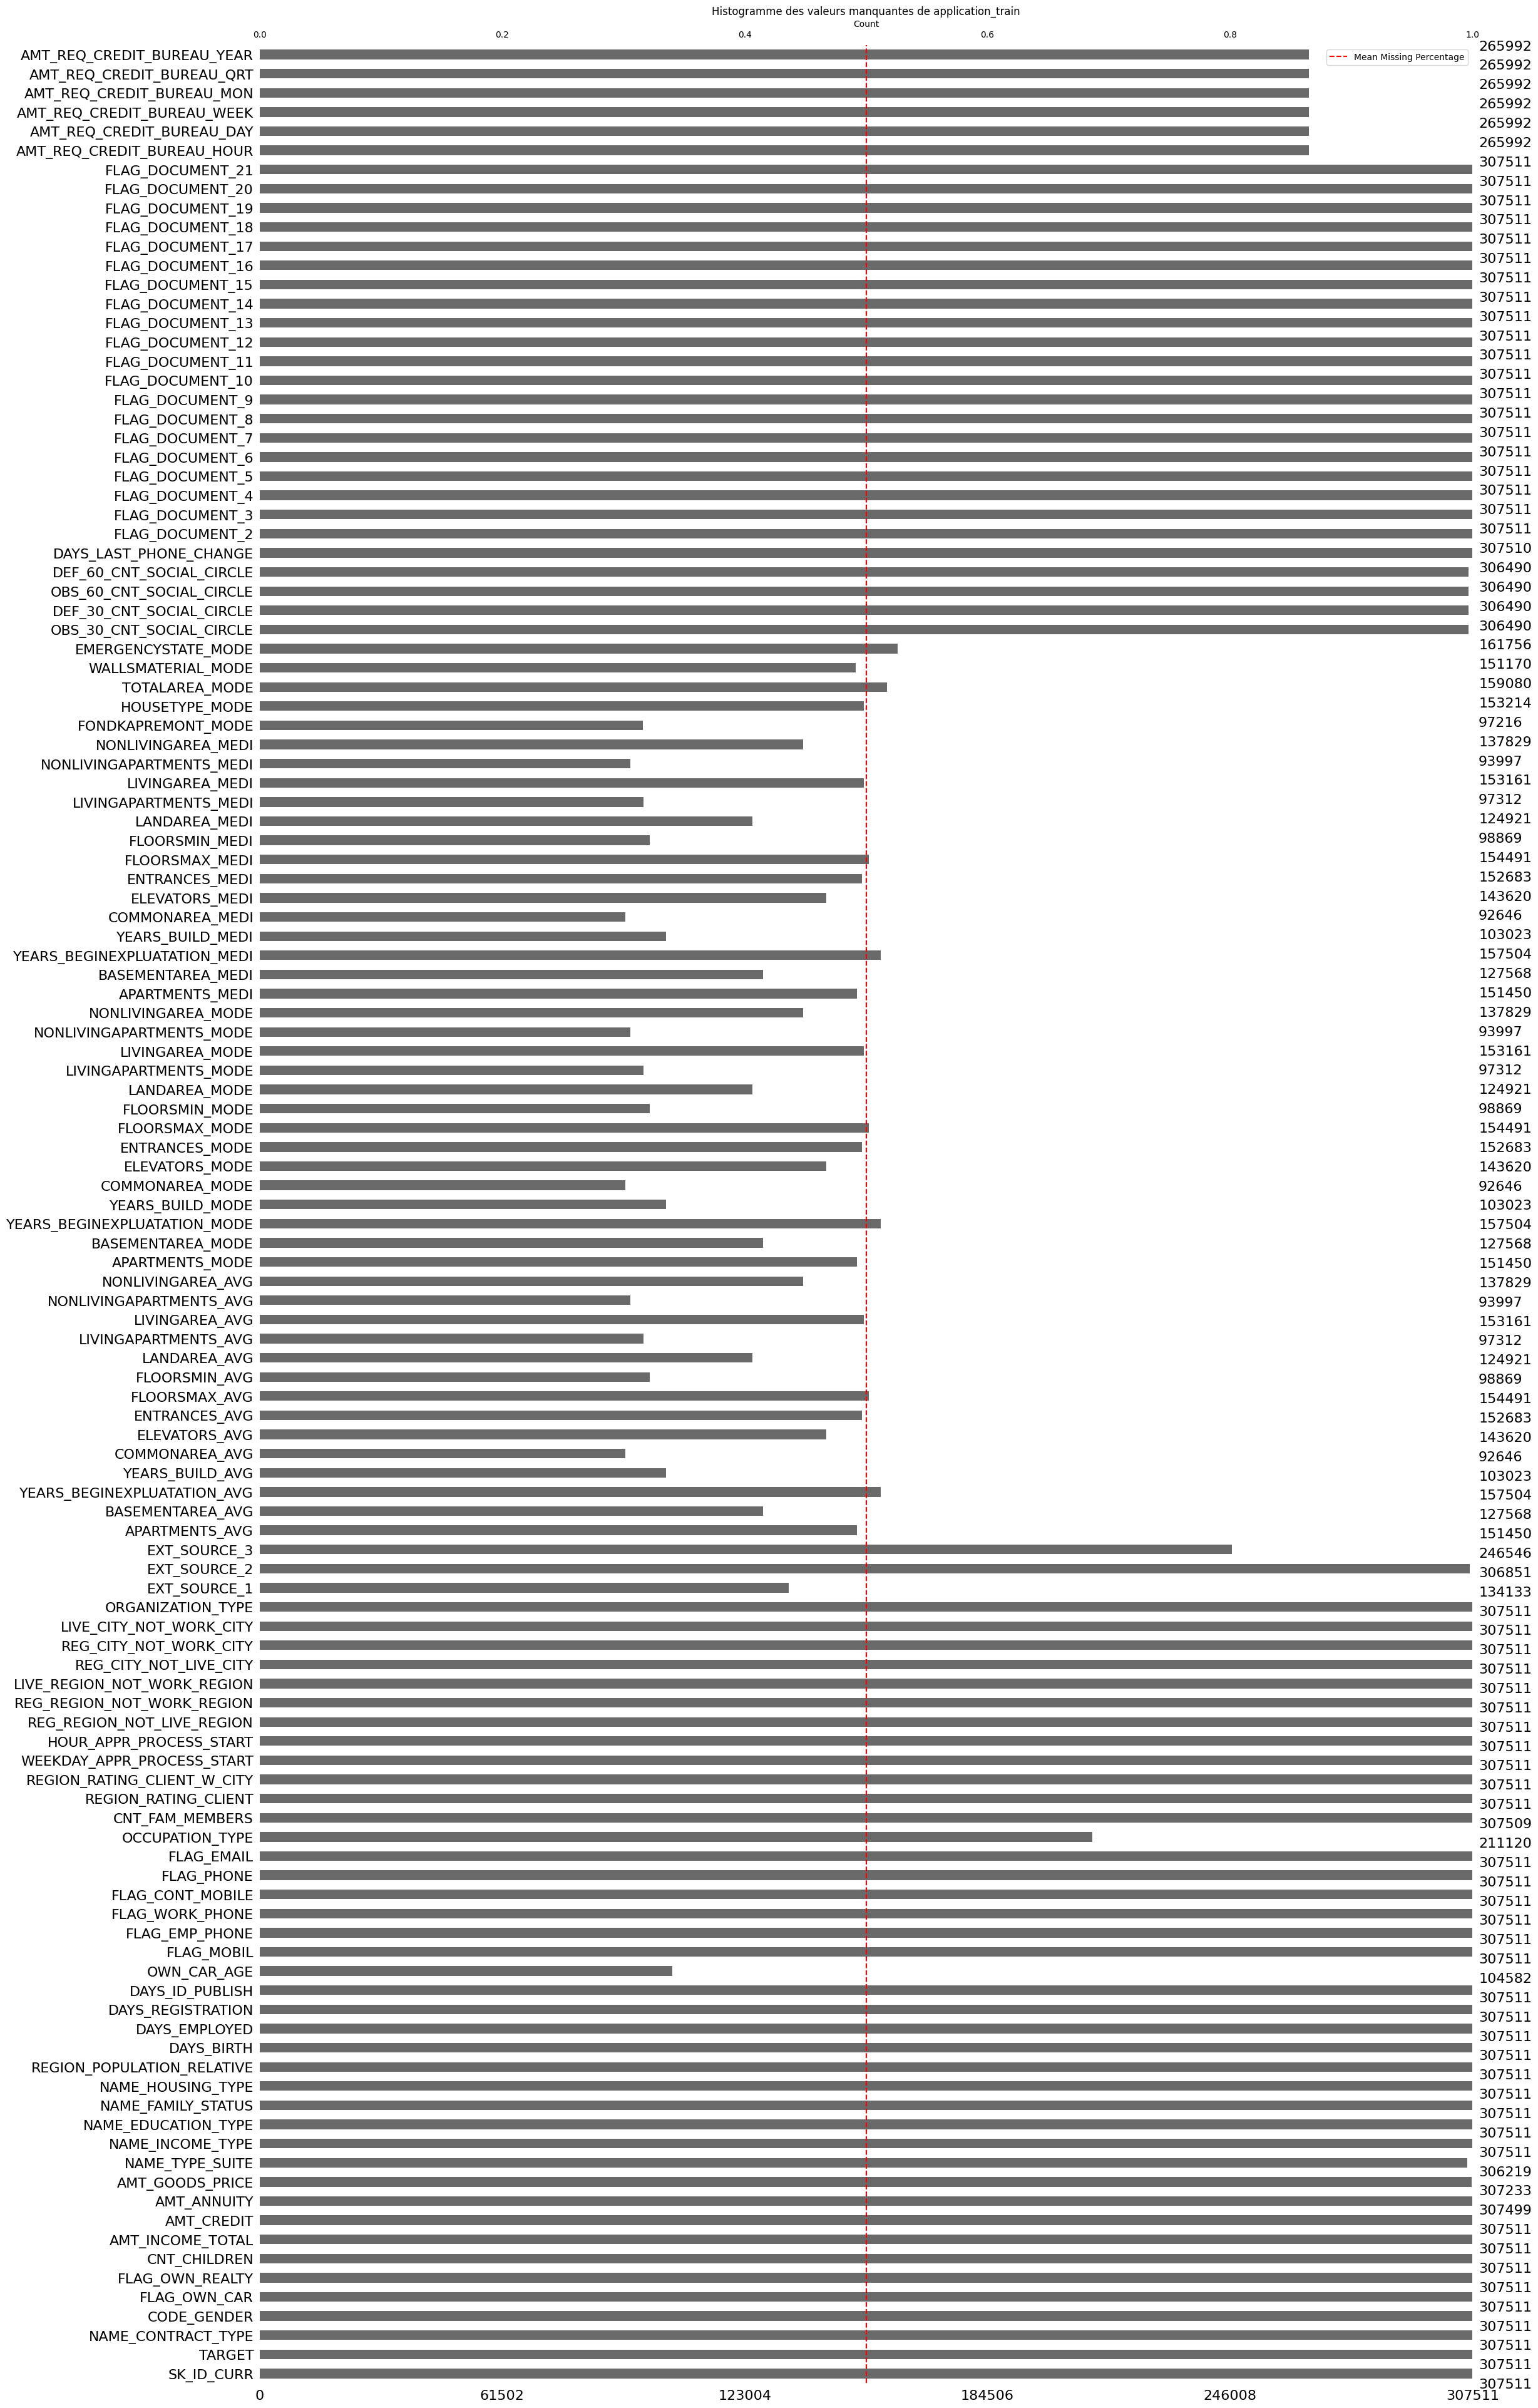

In [8]:
plt.figure(figsize=(15,10))
msno.bar(application_train)


plt.axvline(x=0.5, color='red', linestyle='--', label='Mean Missing Percentage')

plt.xlabel("Count")
plt.ylabel("Features")
plt.title("Histogramme des valeurs manquantes de application_train")
plt.legend()
plt.show()

In [9]:
def list_cols_missing_values(df):
  '''Prend en entrer un dataframe et renvoit le nombre et la liste des colonnes ayant plus de 50% de valeurs manquantes'''

  missing_values = df.isnull().sum()/len(df)
  over50missing = missing_values[missing_values > 0.5].index

  print(f"Il y a :", len(over50missing))
  print("Colonnes avec plus de 50% de valeurs manquantes :")
  print(over50missing)

list_cols_missing_values(application_train)

Il y a : 41
Colonnes avec plus de 50% de valeurs manquantes :
Index(['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE'],
      dtype='object')


pos_cash_balance

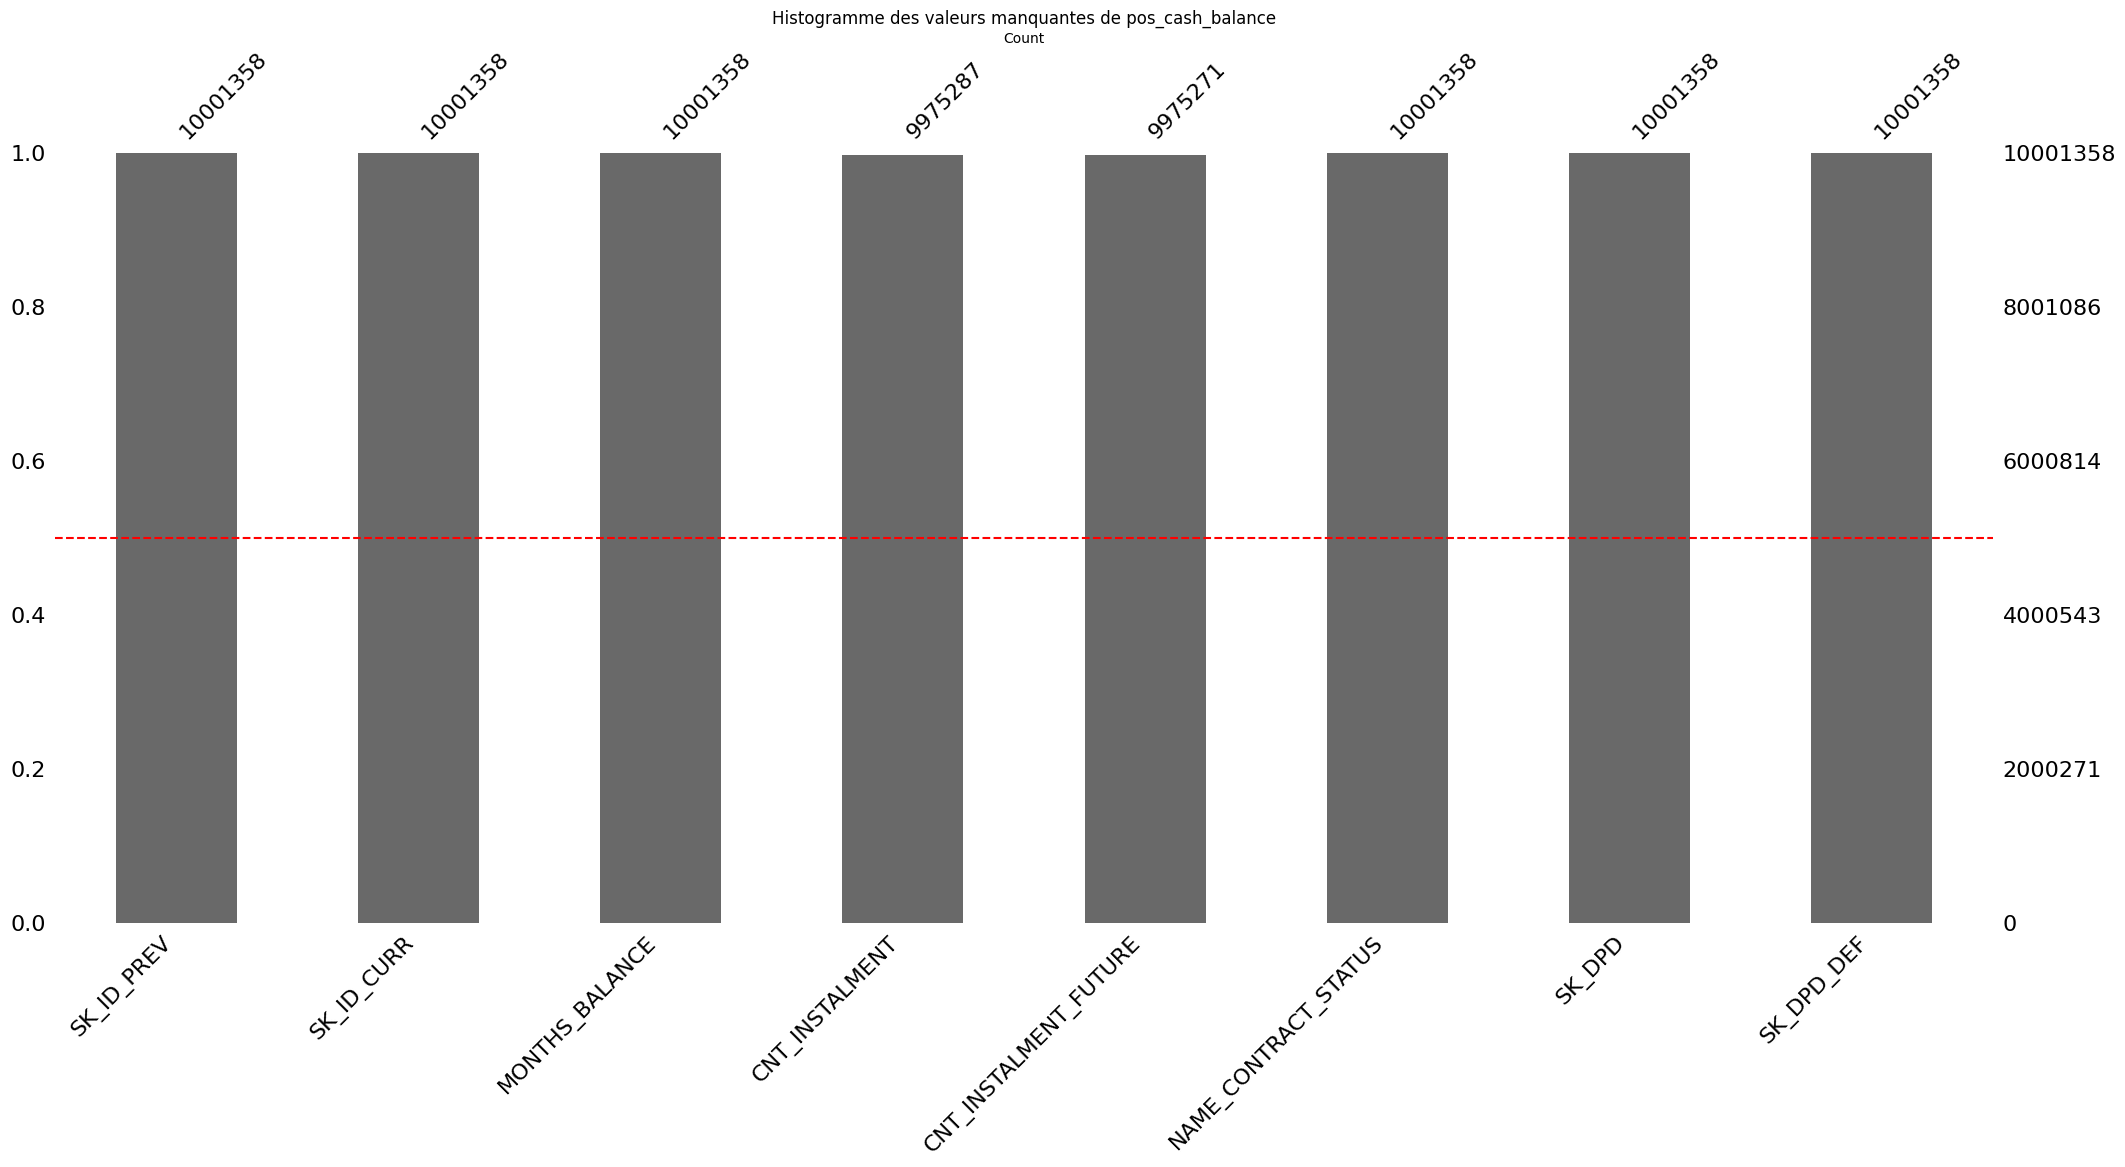

In [10]:
plt.figure(figsize=(10,15))
msno.bar(pos_cash_balance)

plt.axhline(y=0.5, color='red', linestyle='--', label='Mean Missing Percentage')
plt.title("Histogramme des valeurs manquantes de pos_cash_balance")
plt.xlabel("Count")
plt.ylabel("Features")
plt.show()

application_test

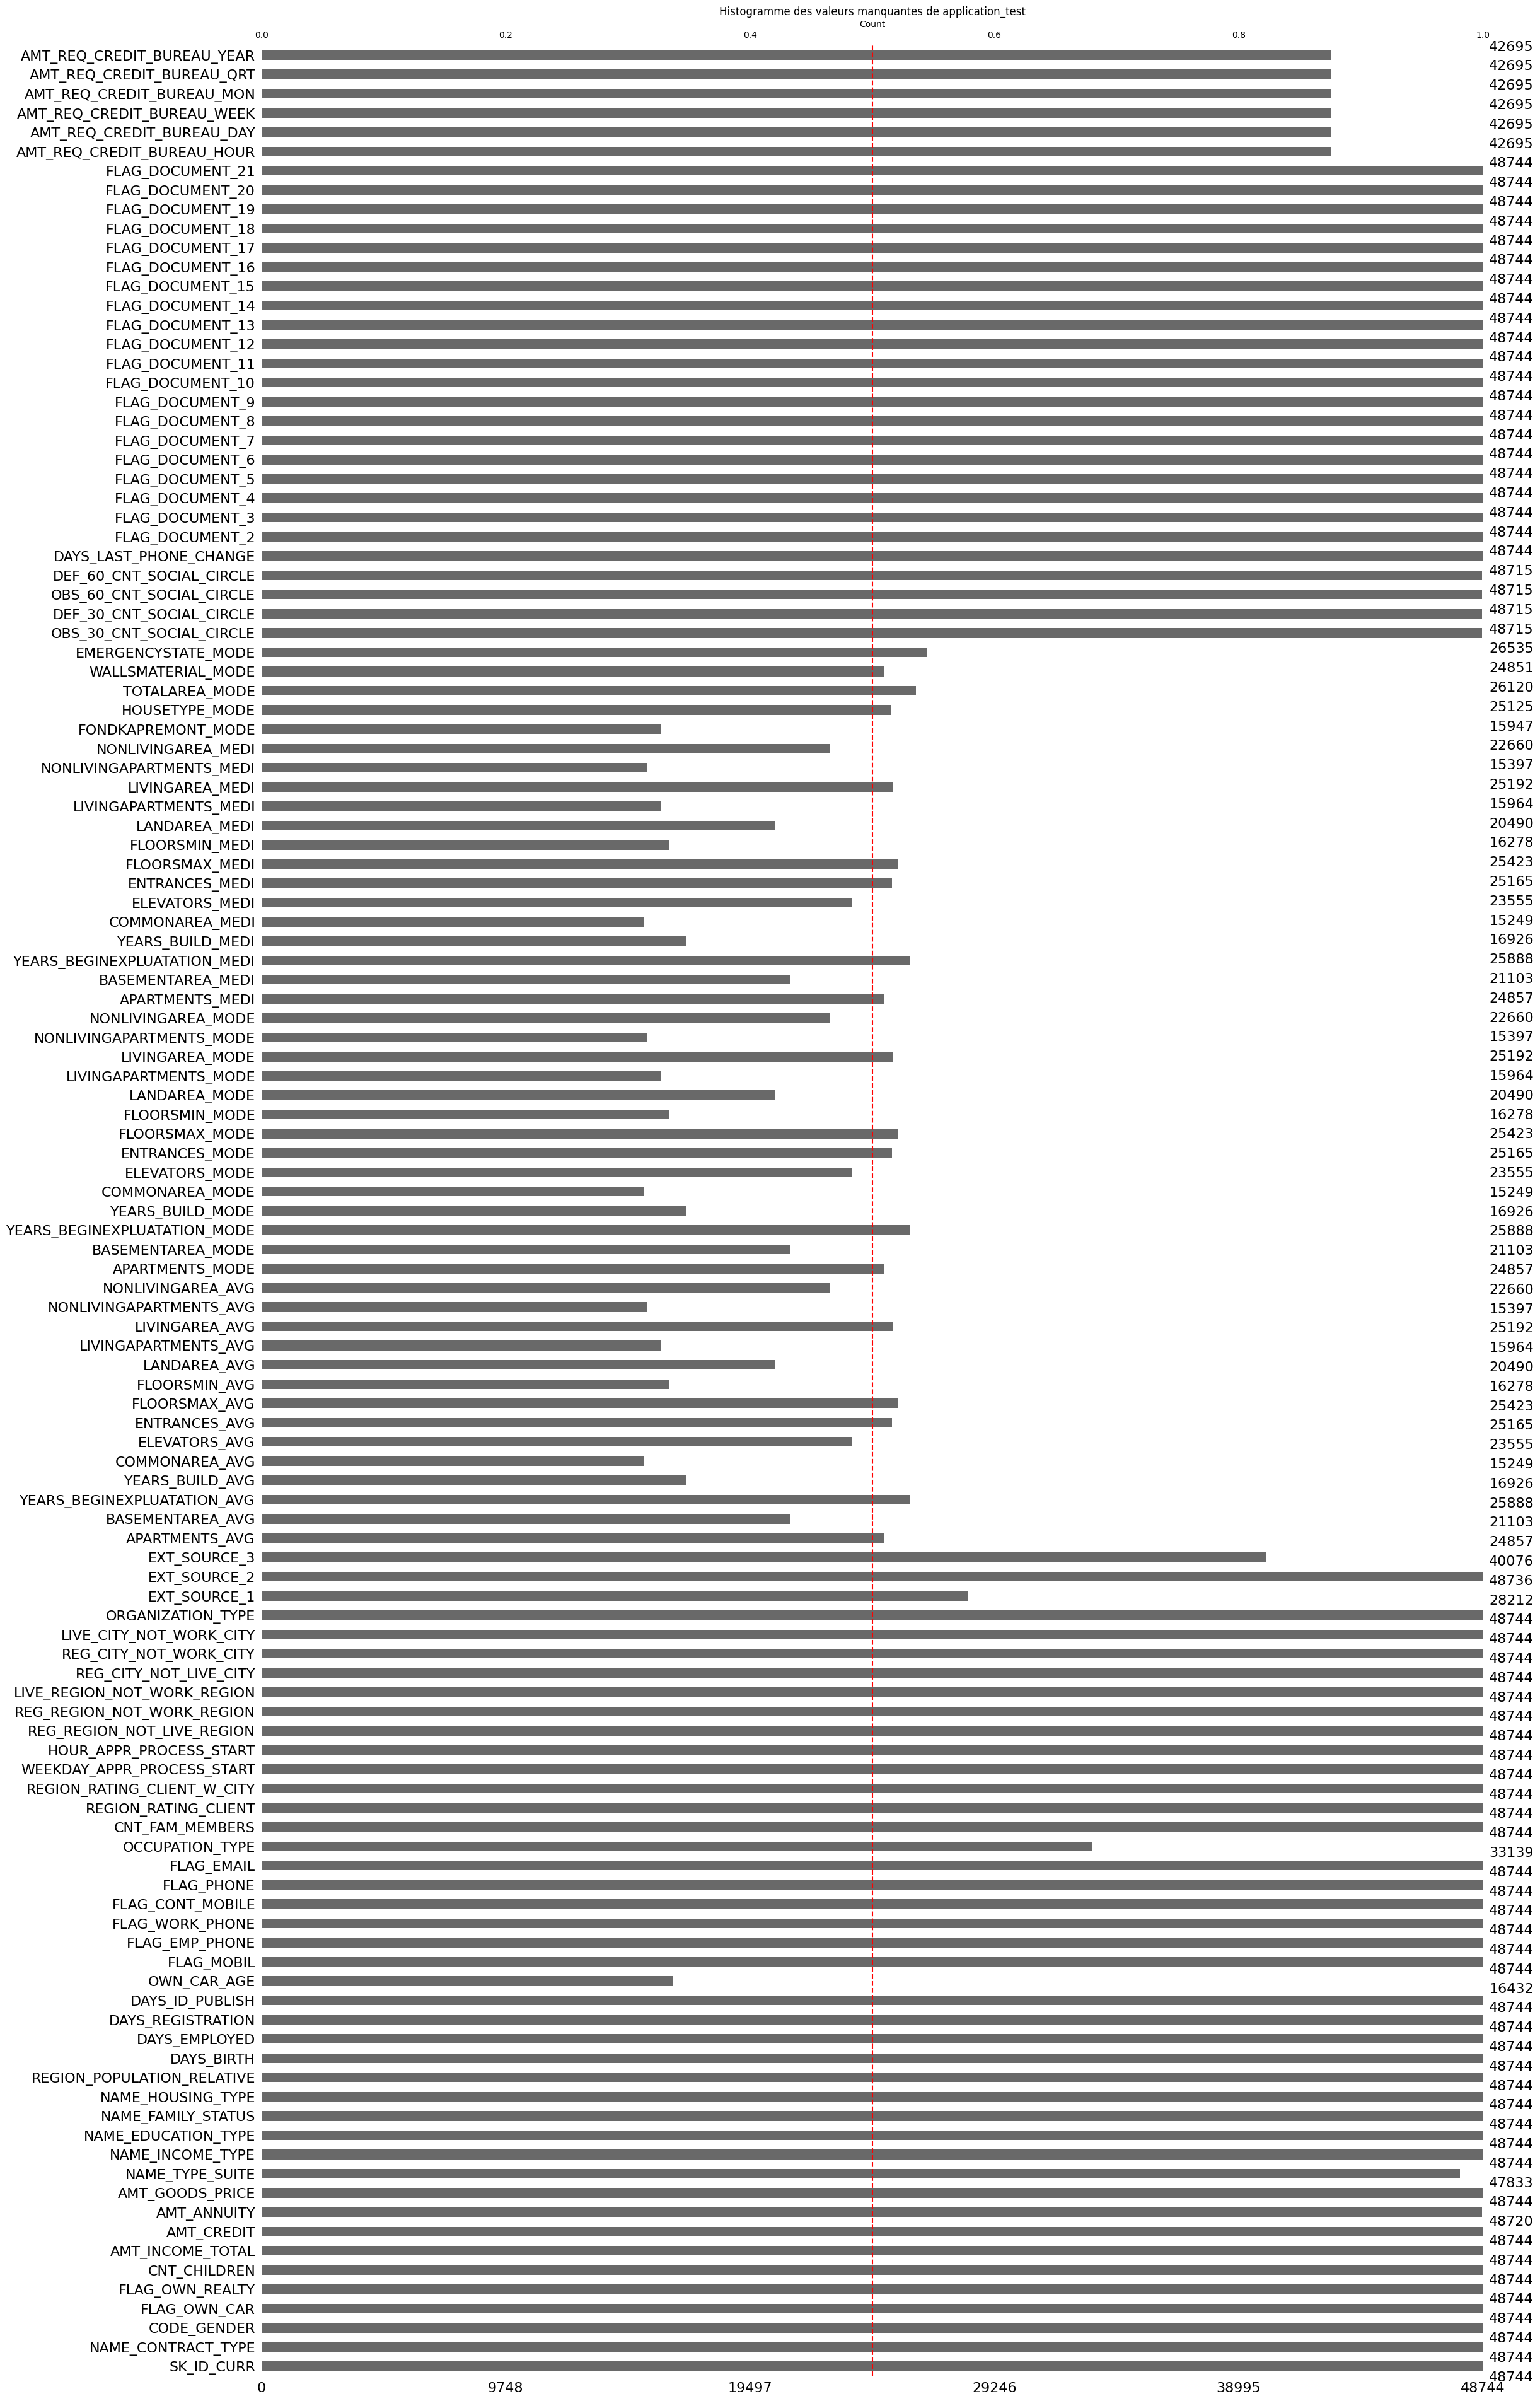

In [11]:
plt.figure(figsize=(15,10))
msno.bar(application_test)

plt.axvline(x=0.5, color='red', linestyle='--', label='Mean Missing Percentage')
plt.title("Histogramme des valeurs manquantes de application_test")
plt.xlabel("Count")
plt.ylabel("Features")
plt.show()

In [12]:
list_cols_missing_values(application_test)

Il y a : 29
Colonnes avec plus de 50% de valeurs manquantes :
Index(['OWN_CAR_AGE', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE'],
      dtype='object')


bureau

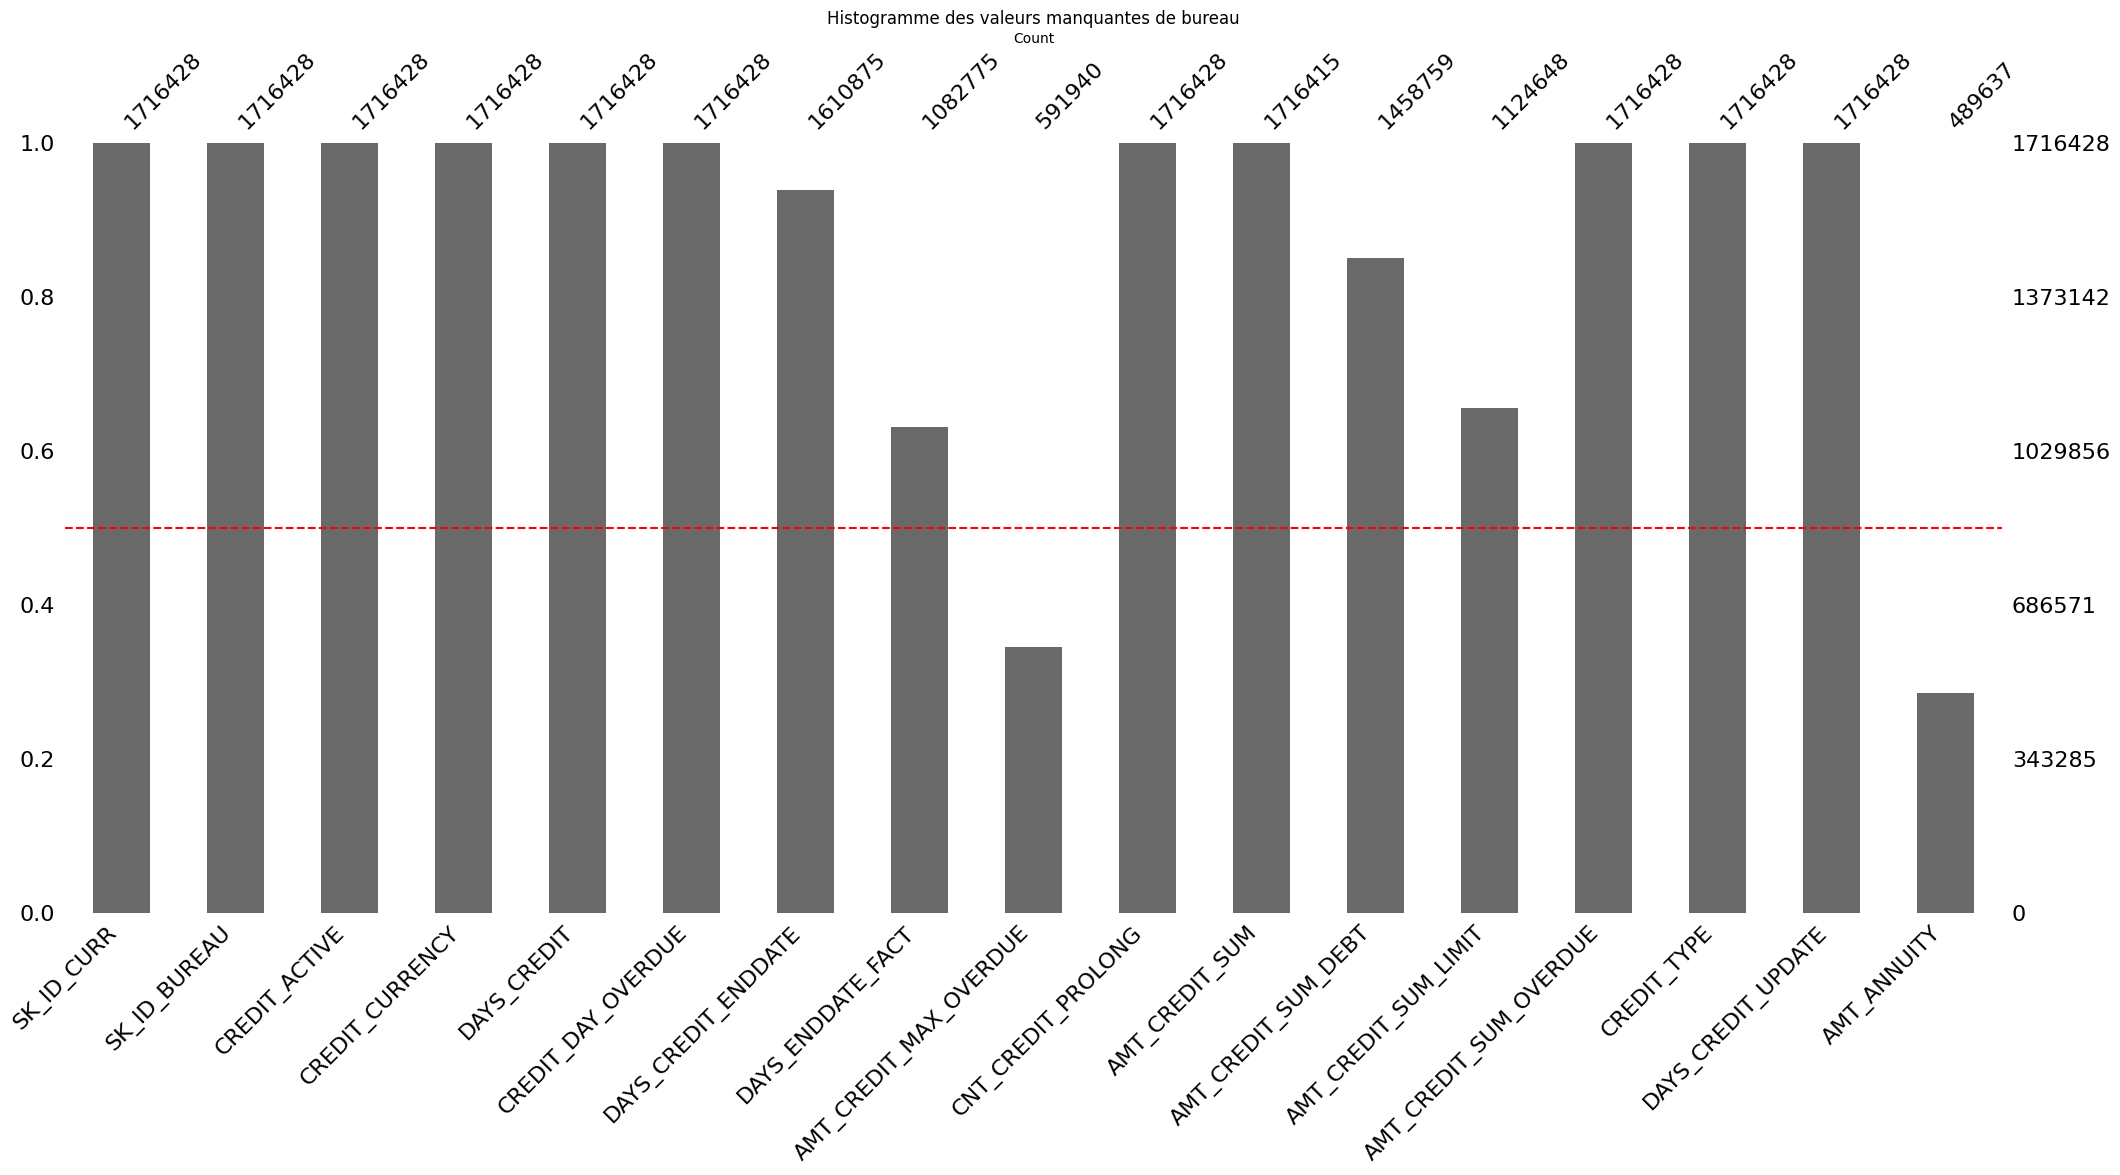

In [13]:
plt.figure(figsize=(15,10))
msno.bar(bureau)

plt.axhline(y=0.5, color='red', linestyle='--', label='Mean Missing Percentage')
plt.title("Histogramme des valeurs manquantes de bureau")
plt.xlabel("Count")
plt.show()

In [14]:
list_cols_missing_values(bureau)

Il y a : 2
Colonnes avec plus de 50% de valeurs manquantes :
Index(['AMT_CREDIT_MAX_OVERDUE', 'AMT_ANNUITY'], dtype='object')


bureau_balance

<Axes: >

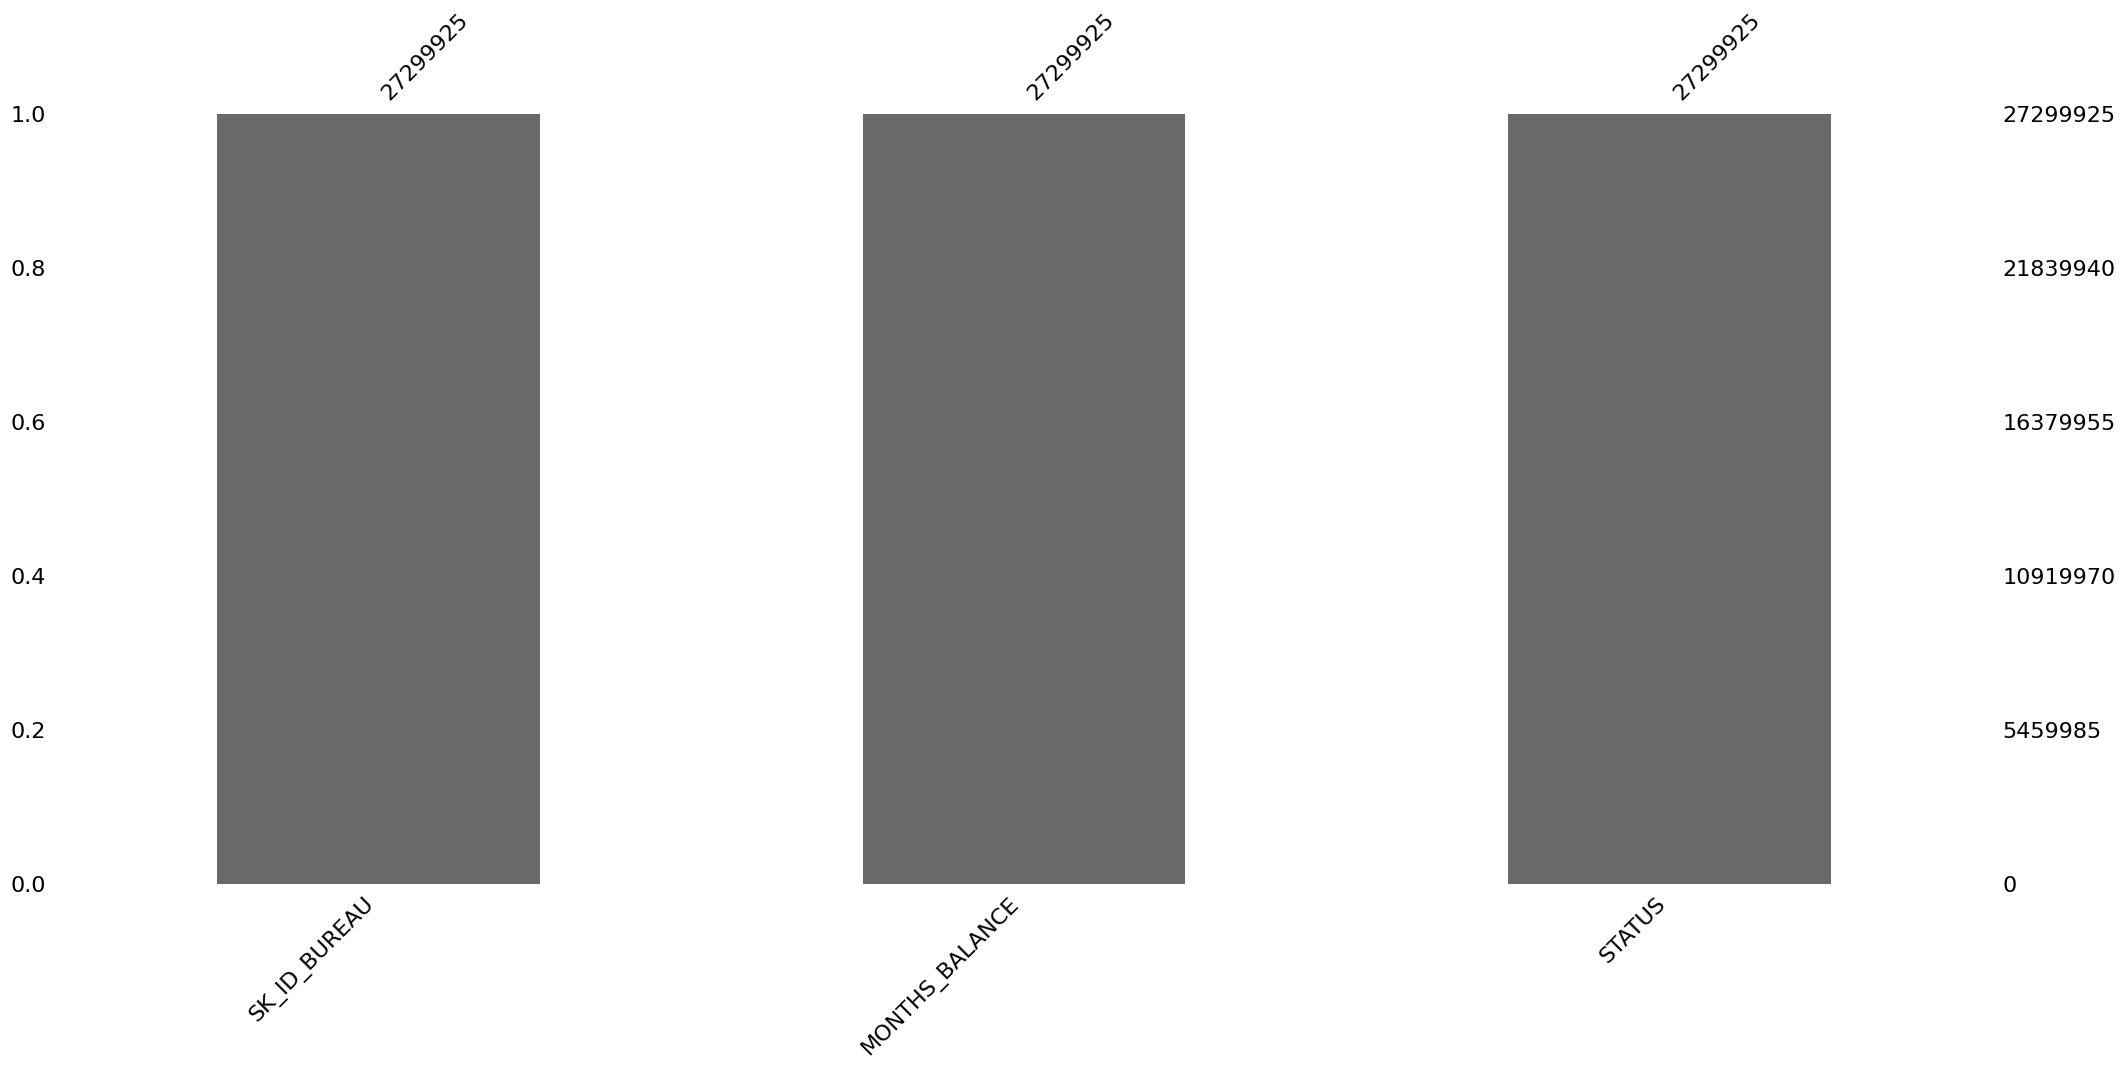

In [15]:
plt.figure(figsize=(15,10))
msno.bar(bureau_balance)

credit_card_balance

<Axes: >

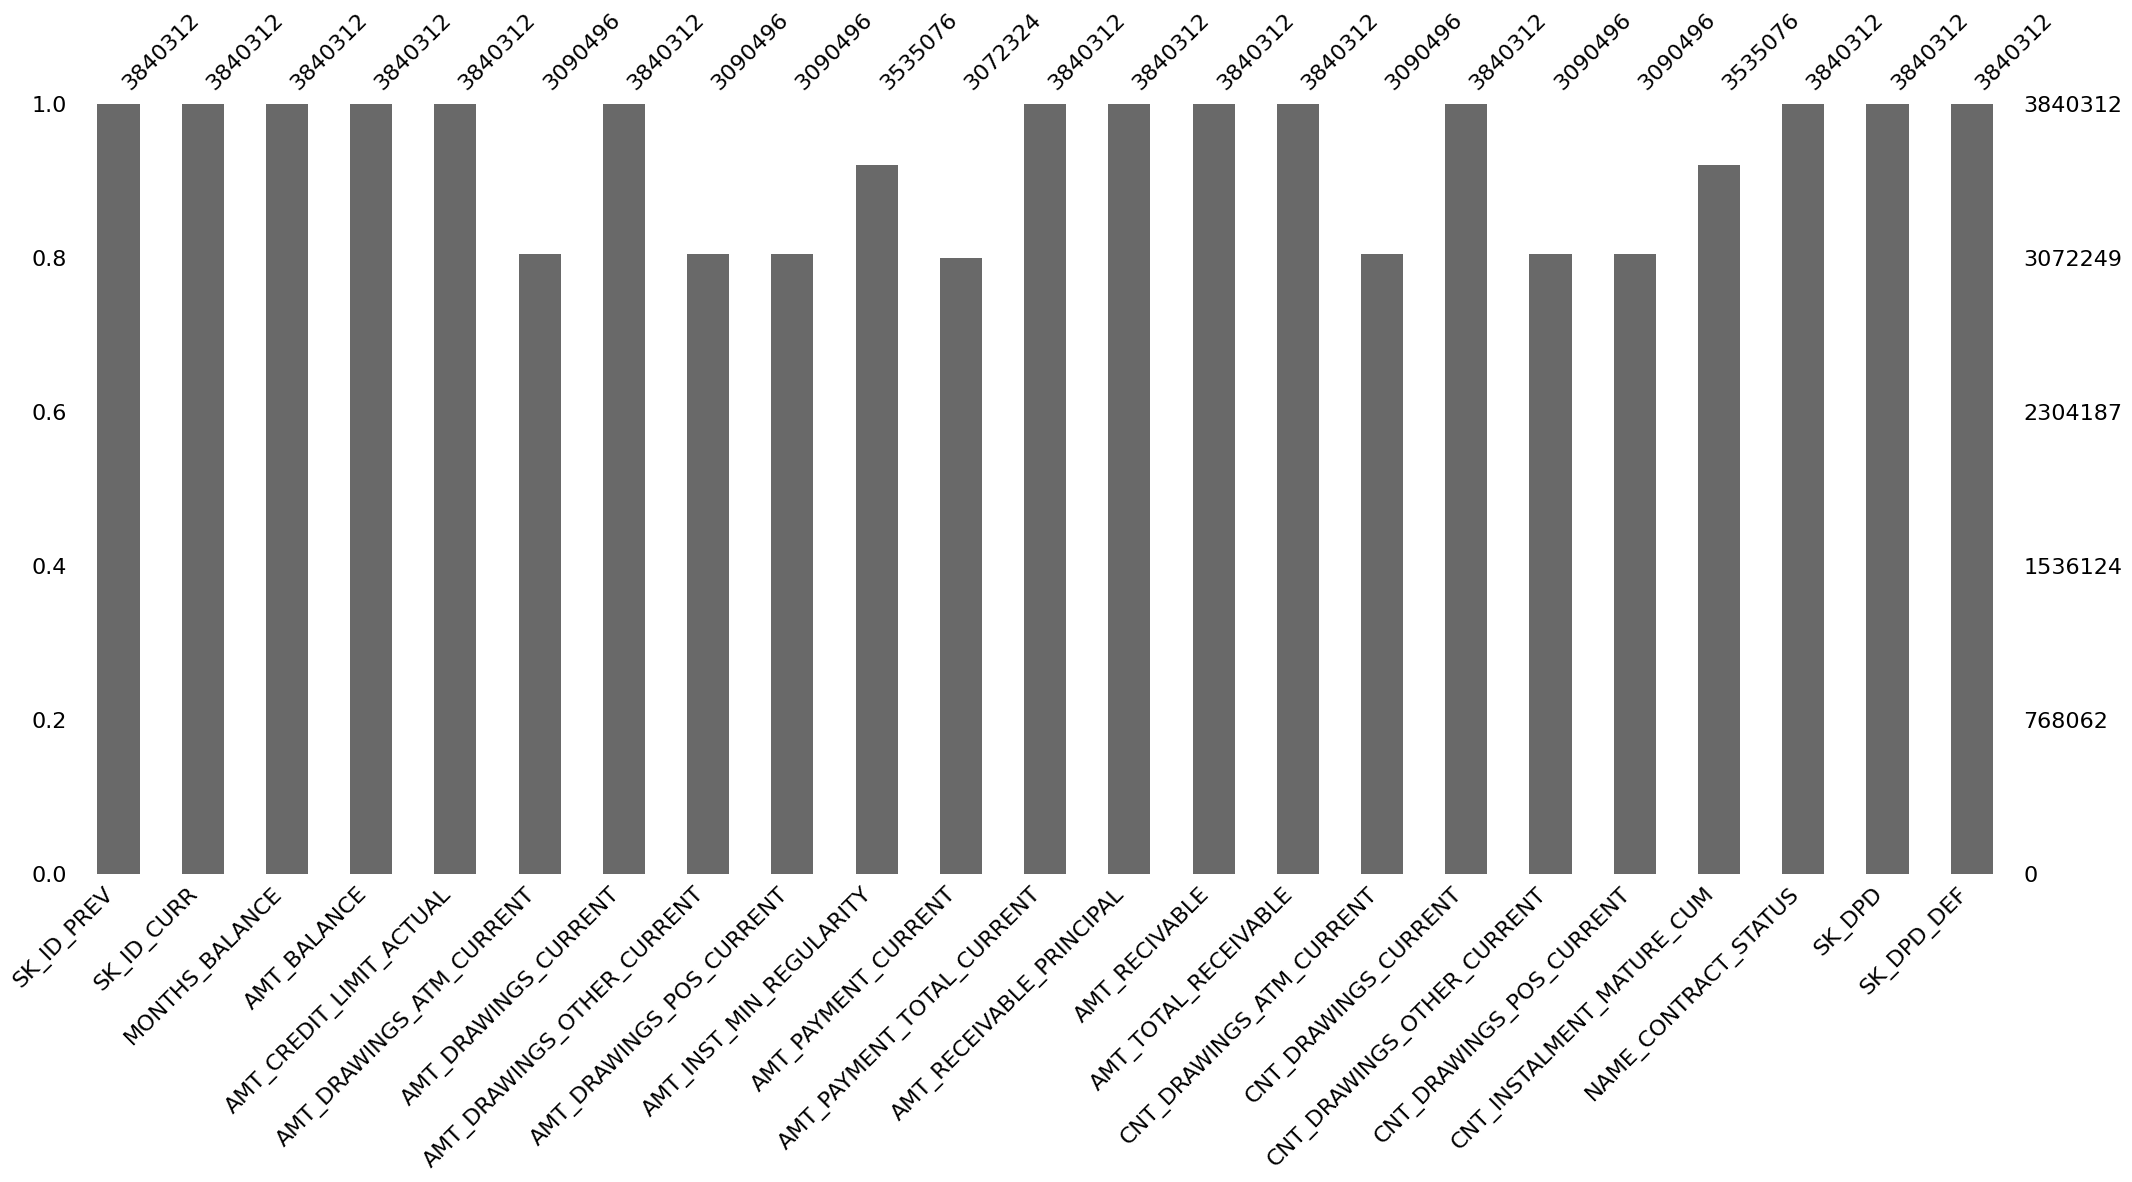

In [16]:
plt.figure(figsize=(15,10))
msno.bar(credit_card_balance)

previous_application

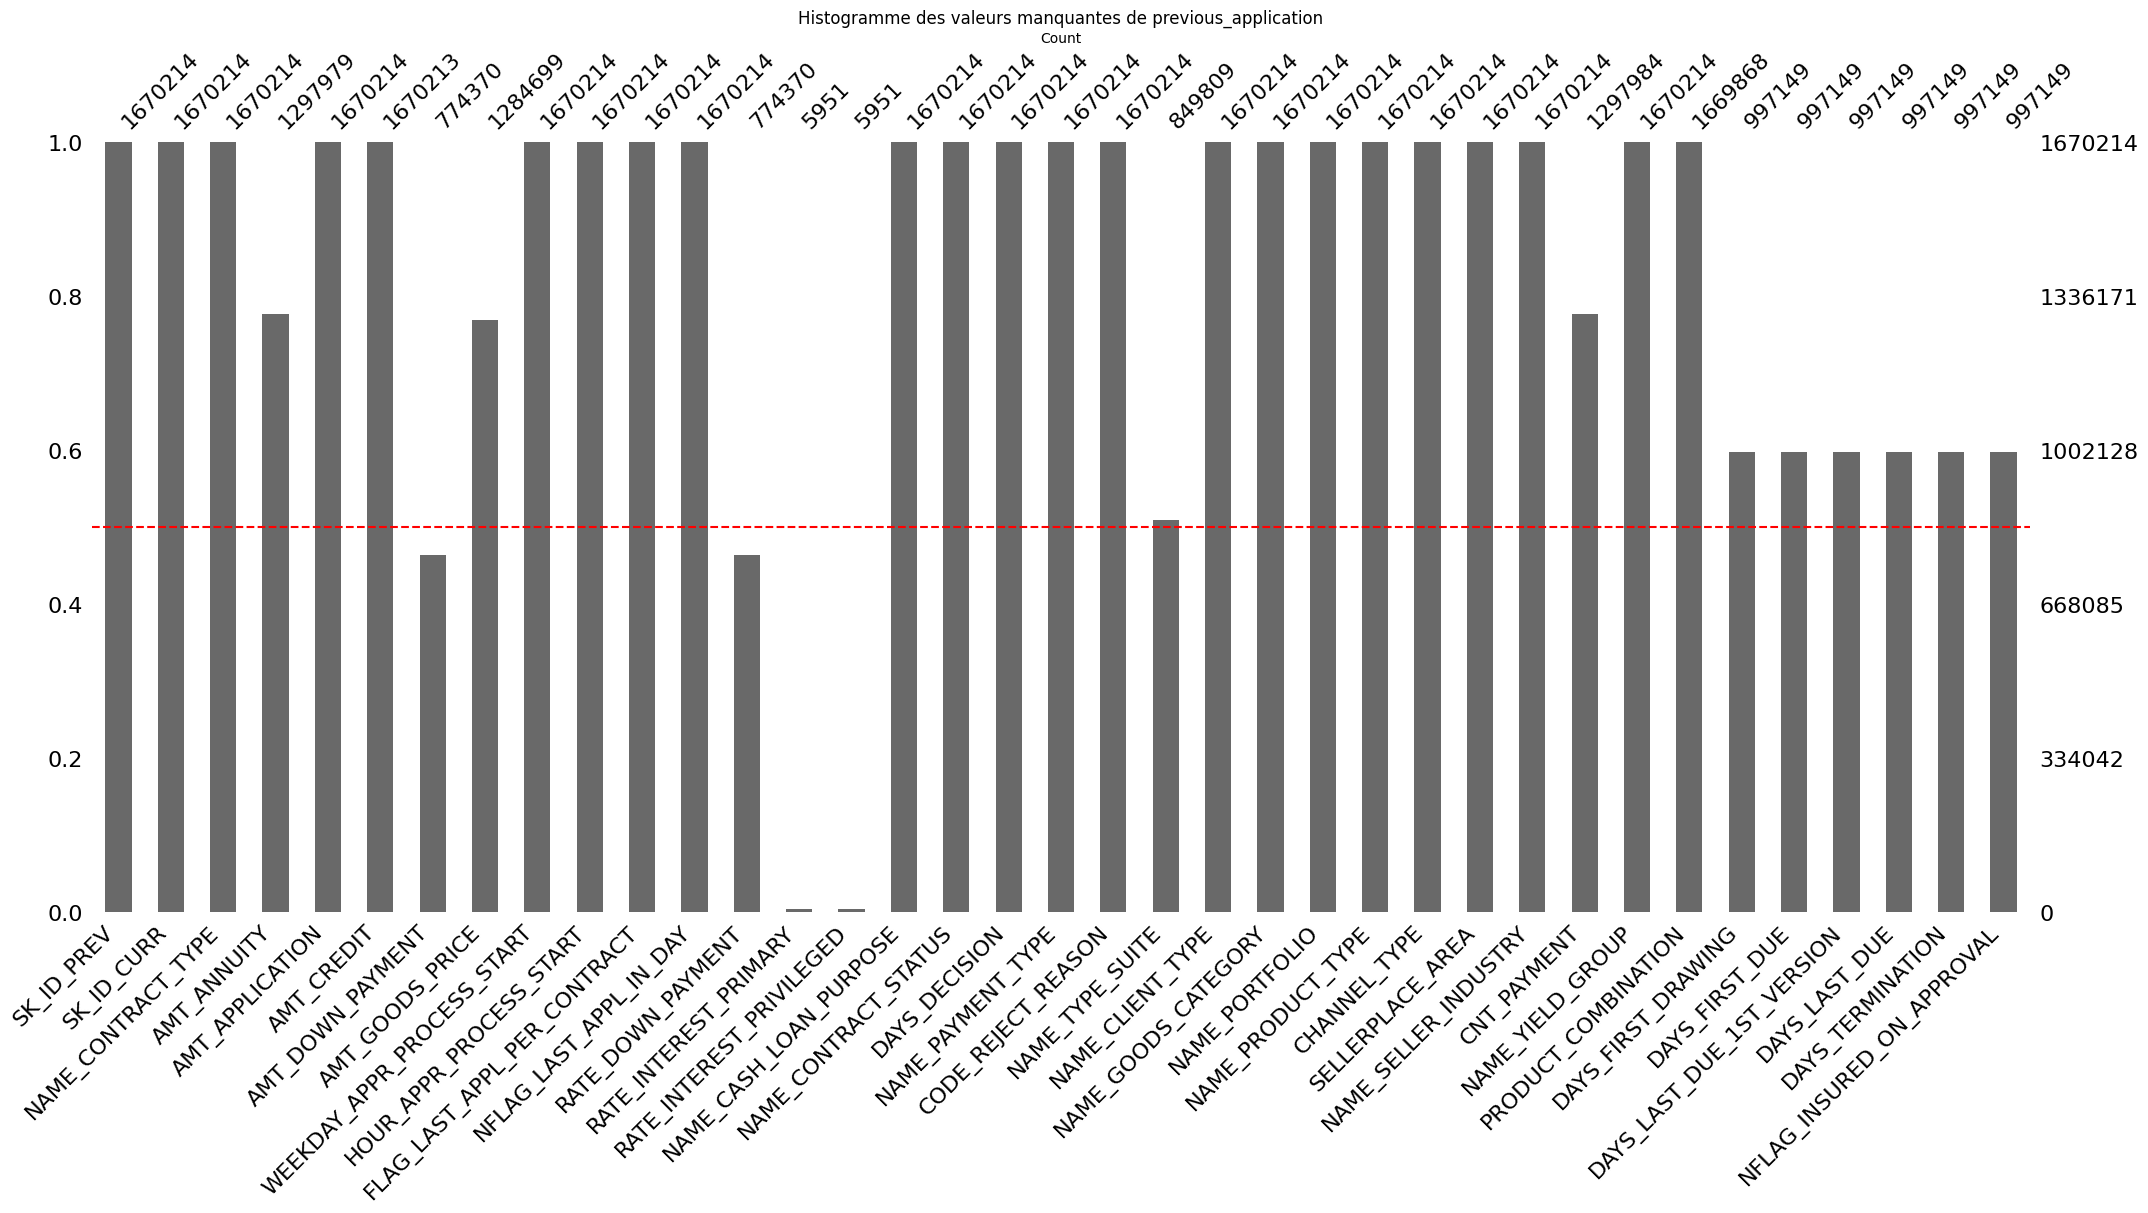

In [17]:
plt.figure(figsize=(15,10))
msno.bar(previous_application)

plt.axhline(y=0.5, color='red', linestyle='--', label='Mean Missing Percentage')
plt.title("Histogramme des valeurs manquantes de previous_application")
plt.xlabel("Count")
plt.show()

In [18]:
list_cols_missing_values(previous_application)

Il y a : 4
Colonnes avec plus de 50% de valeurs manquantes :
Index(['AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED'],
      dtype='object')


installments_payments

<Axes: >

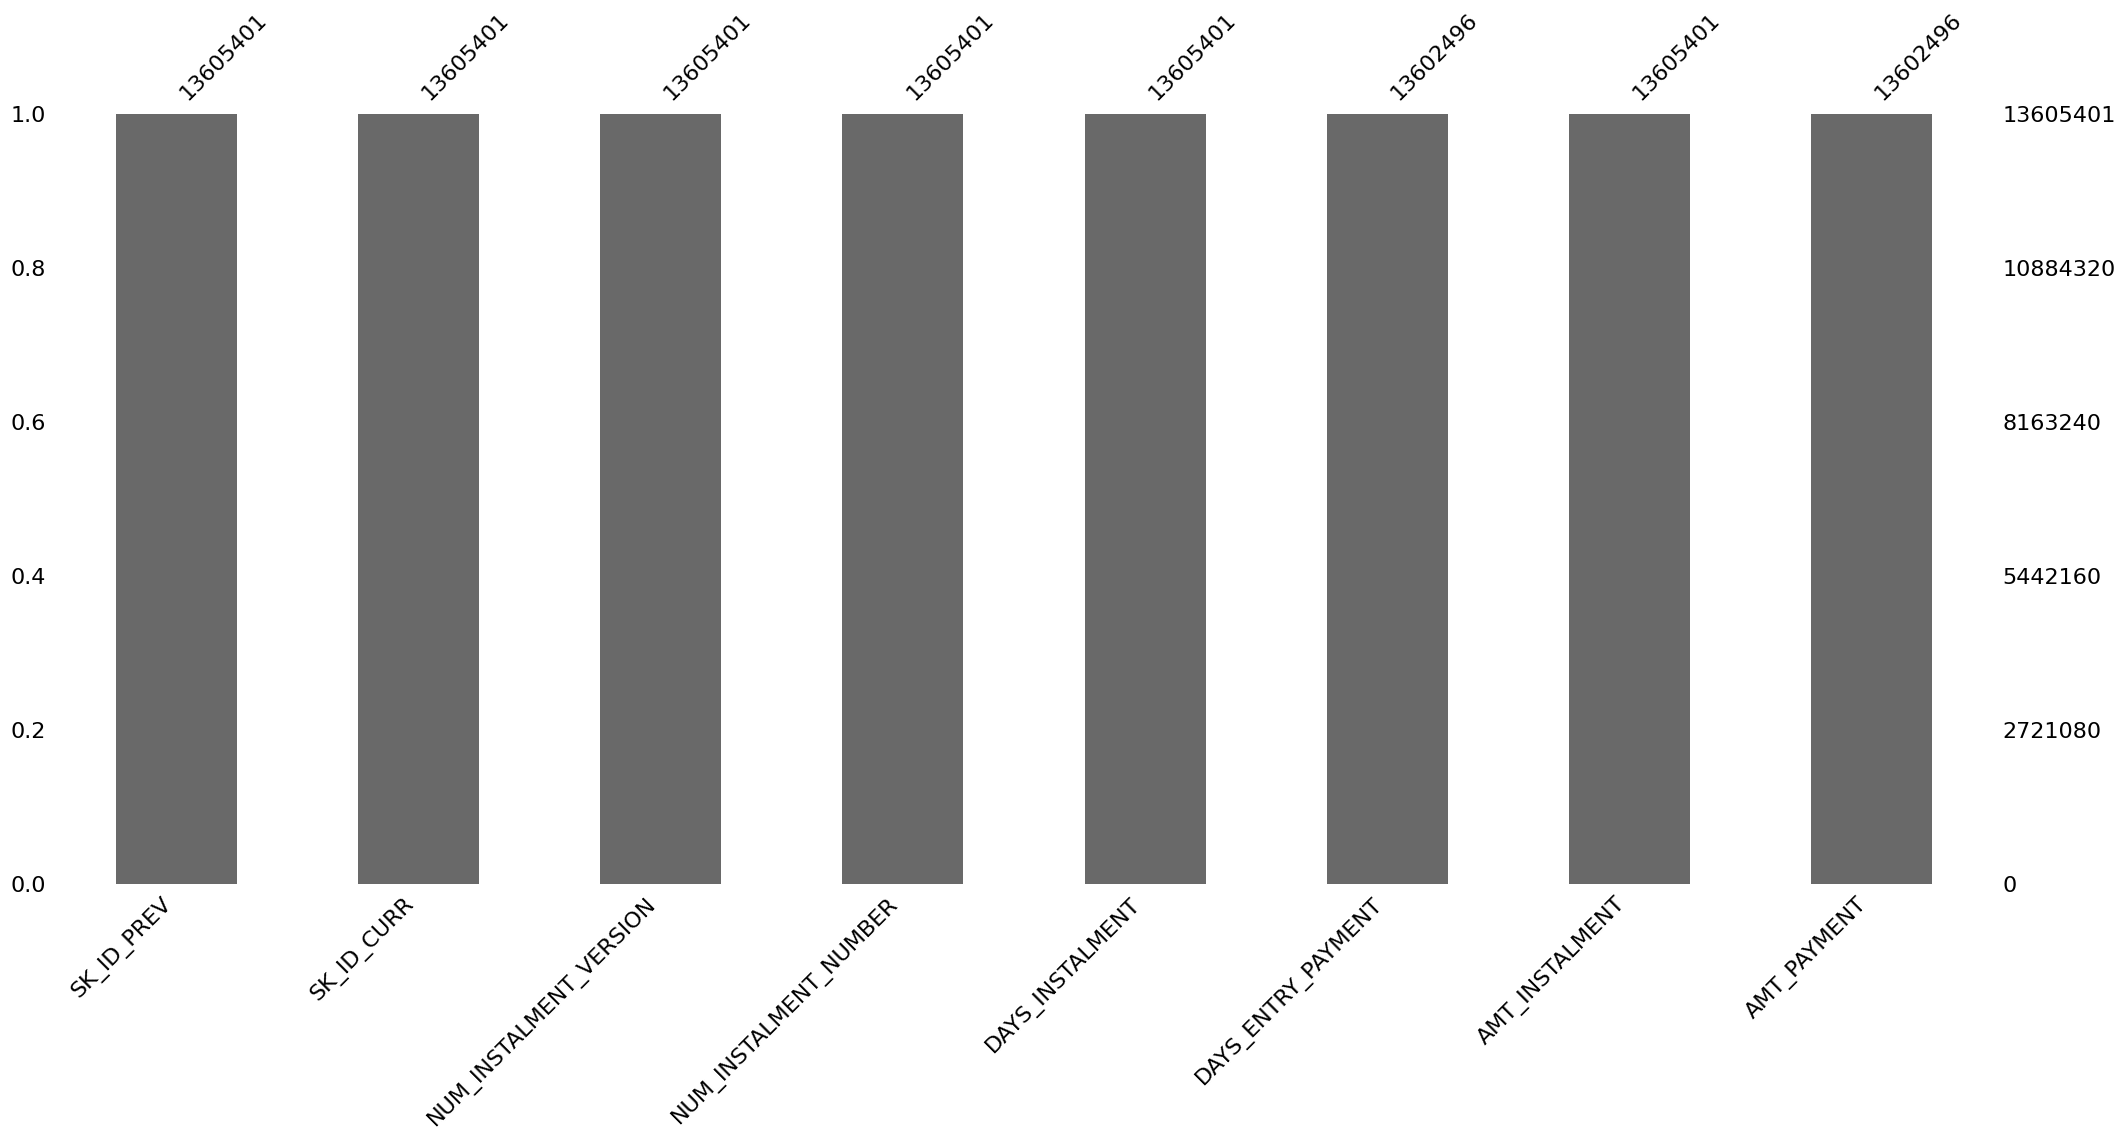

In [19]:
msno.bar(installments_payments)

sample_submission

<Axes: >

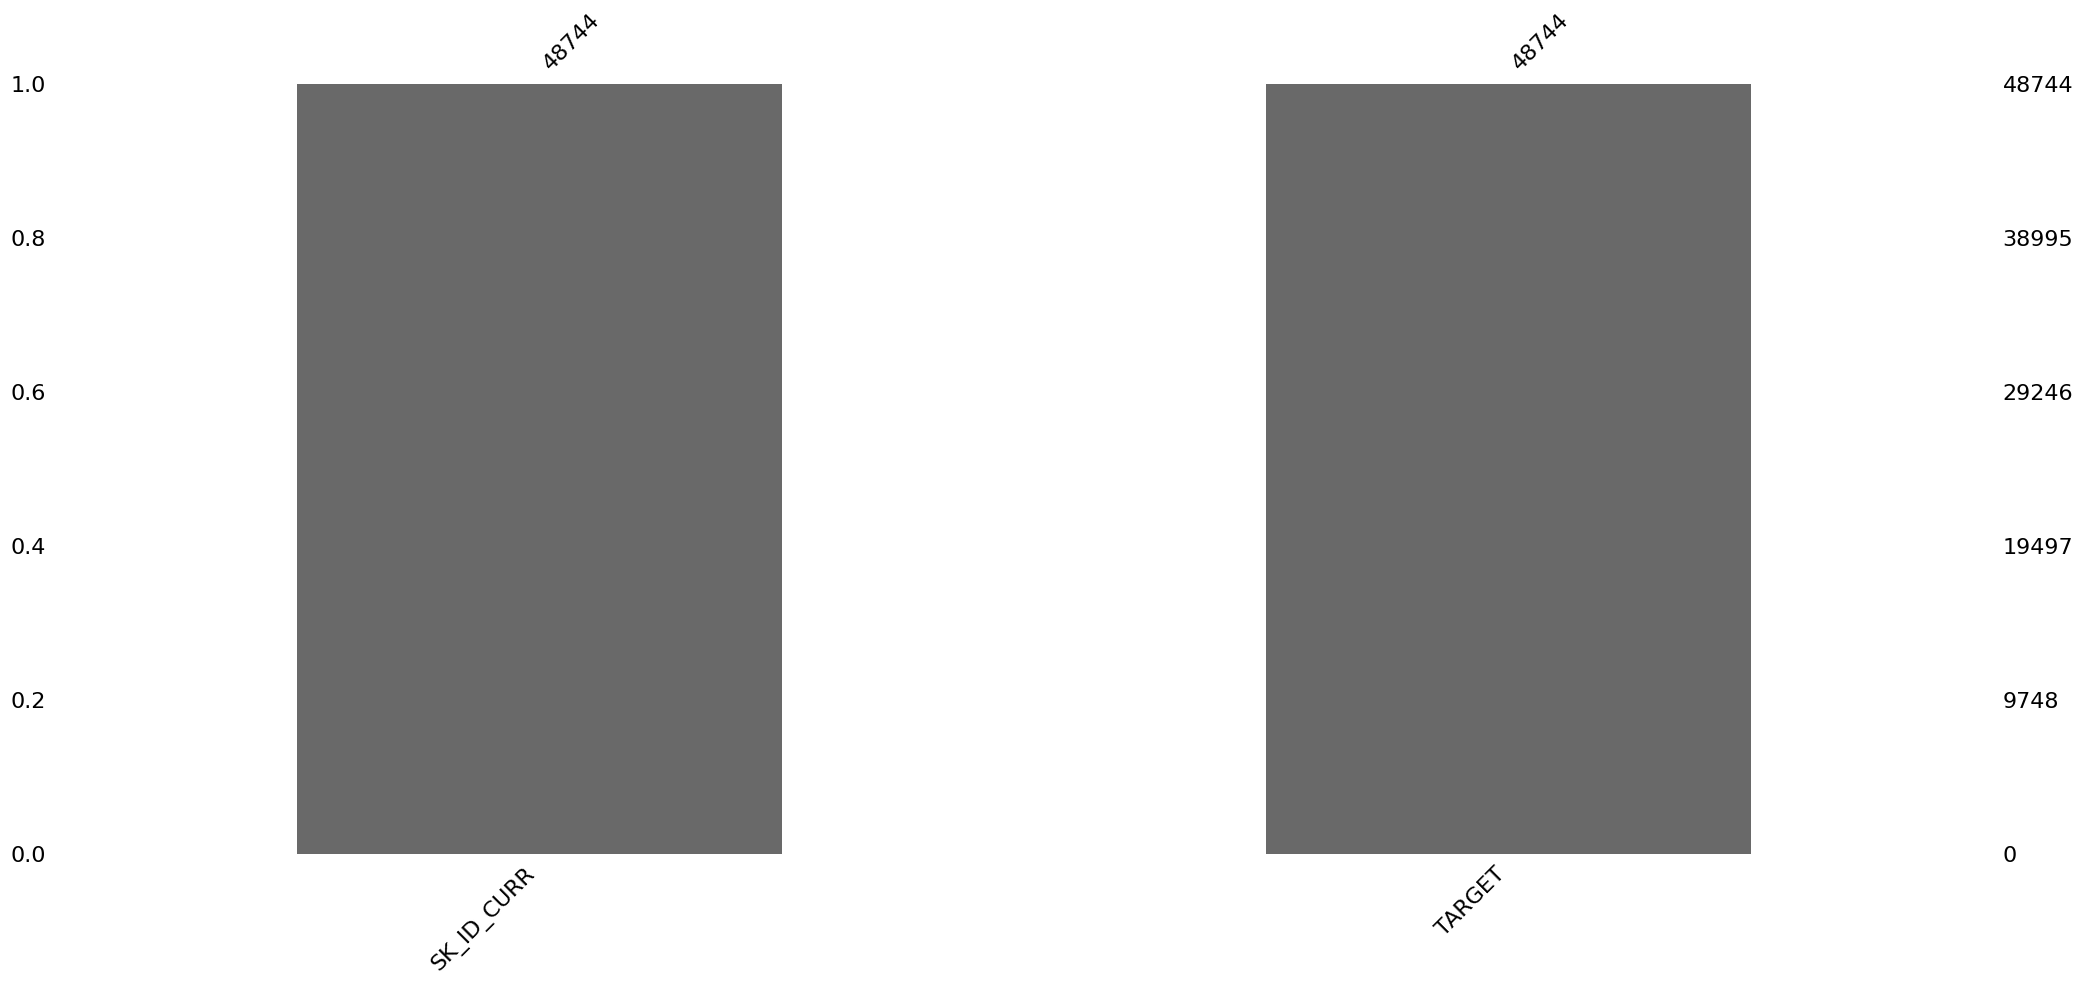

In [20]:
msno.bar(sample_submission)

#### 2 - Doublons

In [21]:
for df, title in zip(list_dfs, list_dfs_title):
  print(title)
  print()
  print(df.duplicated().sum())
  print("-" * 30)

pos_cash_balance

0
------------------------------
application_test

0
------------------------------
application_train

0
------------------------------
bureau

0
------------------------------
bureau_balance

0
------------------------------
credit_card_balance

0
------------------------------
previous_application

0
------------------------------
installments_payments

0
------------------------------
sample_submission

0
------------------------------


#### 3 - Univariate analysis

Chart the distribution of features (boxplot, kdeplot)

Inclure skewness, kurtosis

Test statistiques --> Distribution normale ?

Ecart interquartile IQR

Identifications des valeurs abbérantes

FEATURE NUMERIQUE

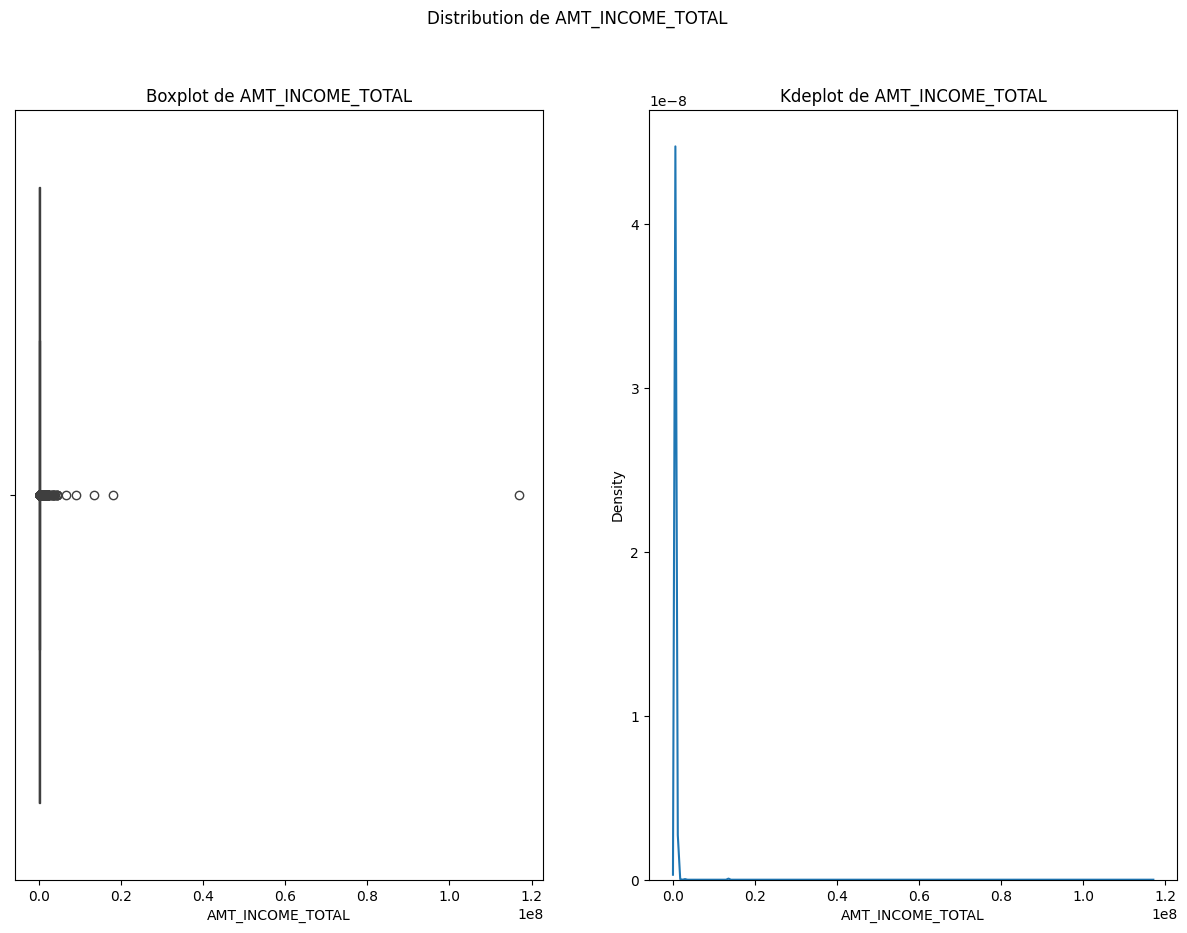

In [22]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
sns.boxplot(application_train['AMT_INCOME_TOTAL'], orient='h')
plt.title('Boxplot de AMT_INCOME_TOTAL')

plt.subplot(1,2,2)
sns.kdeplot(application_train['AMT_INCOME_TOTAL'])
plt.title('Kdeplot de AMT_INCOME_TOTAL')

plt.suptitle("Distribution de AMT_INCOME_TOTAL")
plt.show()

In [23]:
app_train_income_amt_total_skew = round(skew(application_train['AMT_INCOME_TOTAL'], bias=True, axis=0),2)
app_train_income_amt_total_kurt = round(kurtosis(application_train['AMT_INCOME_TOTAL'], fisher=True, bias=True, axis=0),2)
app_train_income_amt_total_mean = round(application_train['AMT_INCOME_TOTAL'].mean(),2)
app_train_income_amt_total_med = round(application_train['AMT_INCOME_TOTAL'].median(),2)

print("Skewness :", app_train_income_amt_total_skew)
print("Kurtosis :", app_train_income_amt_total_kurt)
print("Moyenne :", app_train_income_amt_total_mean, "USD")
print("Médiane :", app_train_income_amt_total_med, "USD")
print("Minimum :", application_train['AMT_INCOME_TOTAL'].min(), "USD")
print("Maximum :", application_train['AMT_INCOME_TOTAL'].max(), "USD")
app_train_amt_income_total_q1 = np.percentile(application_train['AMT_INCOME_TOTAL'], 25)
app_train_amt_income_total_q3 = np.percentile(application_train['AMT_INCOME_TOTAL'], 75)
app_train_amt_income_total_iqr = app_train_amt_income_total_q3 - app_train_amt_income_total_q1
print("IQR AMT_INCOME_TOTAL:", app_train_amt_income_total_iqr)

Skewness : 391.56
Kurtosis : 191783.44
Moyenne : 168797.92 USD
Médiane : 147150.0 USD
Minimum : 25650.0 USD
Maximum : 117000000.0 USD
IQR AMT_INCOME_TOTAL: 90000.0


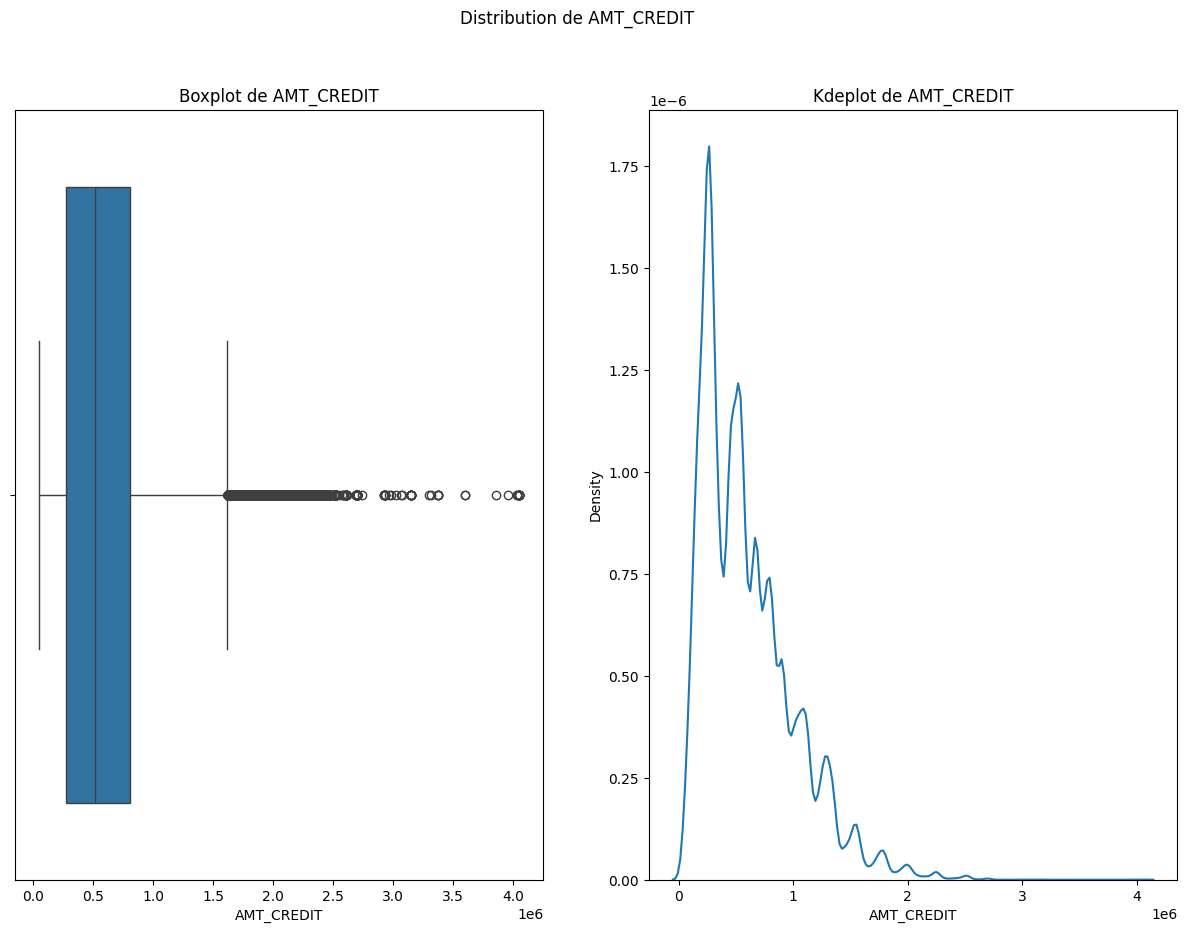

In [24]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
sns.boxplot(application_train['AMT_CREDIT'], orient='h')
plt.title('Boxplot de AMT_CREDIT')

plt.subplot(1,2,2)
sns.kdeplot(application_train['AMT_CREDIT'])
plt.title('Kdeplot de AMT_CREDIT')

plt.suptitle("Distribution de AMT_CREDIT")
plt.show()

In [25]:
app_train_amt_credit_skew = round(skew(application_train['AMT_CREDIT'], bias=True, axis=0),2)
app_train_amt_credit_kurt = round(kurtosis(application_train['AMT_CREDIT'], fisher=True, bias=True, axis=0),2)
app_train_amt_credit_mean = round(application_train['AMT_CREDIT'].mean(),2)
app_train_amt_credit_med = round(application_train['AMT_CREDIT'].median(),2)

print("Skewness :", app_train_amt_credit_skew)
print("Kurtosis :", app_train_amt_credit_kurt)
print("Moyenne :", app_train_amt_credit_mean, "USD")
print("Médiane :", app_train_amt_credit_med, "USD")
print("Minimum :", application_train['AMT_CREDIT'].min(), "USD")
print("Maximum :", application_train['AMT_CREDIT'].max(), "USD")
app_train_amt_credit_q1 = np.percentile(application_train['AMT_CREDIT'], 25)
app_train_amt_credit_q3 = np.percentile(application_train['AMT_CREDIT'], 75)
app_train_amt_credit_iqr = app_train_amt_credit_q3 - app_train_amt_credit_q1
print("IQR AMT_INCOME_TOTAL:", app_train_amt_credit_iqr)

Skewness : 1.23
Kurtosis : 1.93
Moyenne : 599026.0 USD
Médiane : 513531.0 USD
Minimum : 45000.0 USD
Maximum : 4050000.0 USD
IQR AMT_INCOME_TOTAL: 538650.0


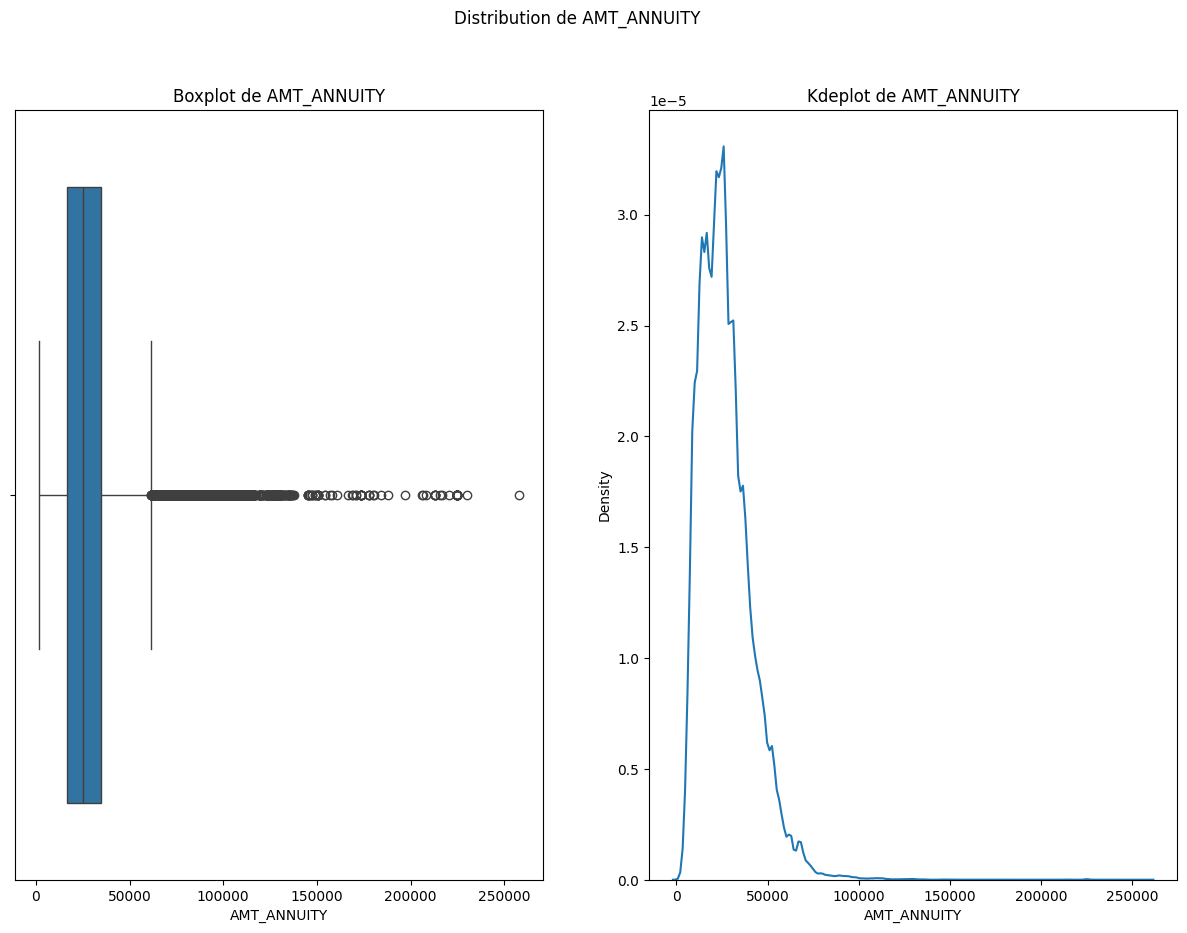

In [26]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
sns.boxplot(application_train['AMT_ANNUITY'], orient='h')
plt.title('Boxplot de AMT_ANNUITY')

plt.subplot(1,2,2)
sns.kdeplot(application_train['AMT_ANNUITY'])
plt.title('Kdeplot de AMT_ANNUITY')

plt.suptitle("Distribution de AMT_ANNUITY")
plt.show()

In [27]:
app_train_amt_annuity_skew = round(skew(application_train['AMT_ANNUITY'], bias=True, axis=0),2)
app_train_amt_annuity_kurt = round(kurtosis(application_train['AMT_ANNUITY'], fisher=True, bias=True, axis=0),2)
app_train_amt_annuity_mean = round(application_train['AMT_ANNUITY'].mean(),2)
app_train_amt_annuity_med = round(application_train['AMT_ANNUITY'].median(),2)

print("Skewness :", app_train_amt_annuity_skew)
print("Kurtosis :", app_train_amt_annuity_kurt)
print("Moyenne :", app_train_amt_annuity_mean, "USD")
print("Médiane :", app_train_amt_annuity_med, "USD")
print("Minimum :", application_train['AMT_ANNUITY'].min(), "USD")
print("Maximum :", application_train['AMT_ANNUITY'].max(), "USD")
app_train_amt_annuity_q1 = np.percentile(application_train['AMT_ANNUITY'], 25)
app_train_amt_annuity_q3 = np.percentile(application_train['AMT_ANNUITY'], 75)
app_train_amt_annuity_iqr = app_train_amt_annuity_q3 - app_train_amt_annuity_q1
print("IQR AMT_INCOME_TOTAL:", app_train_amt_annuity_iqr)

Skewness : nan
Kurtosis : nan
Moyenne : 27108.57 USD
Médiane : 24903.0 USD
Minimum : 1615.5 USD
Maximum : 258025.5 USD
IQR AMT_INCOME_TOTAL: nan


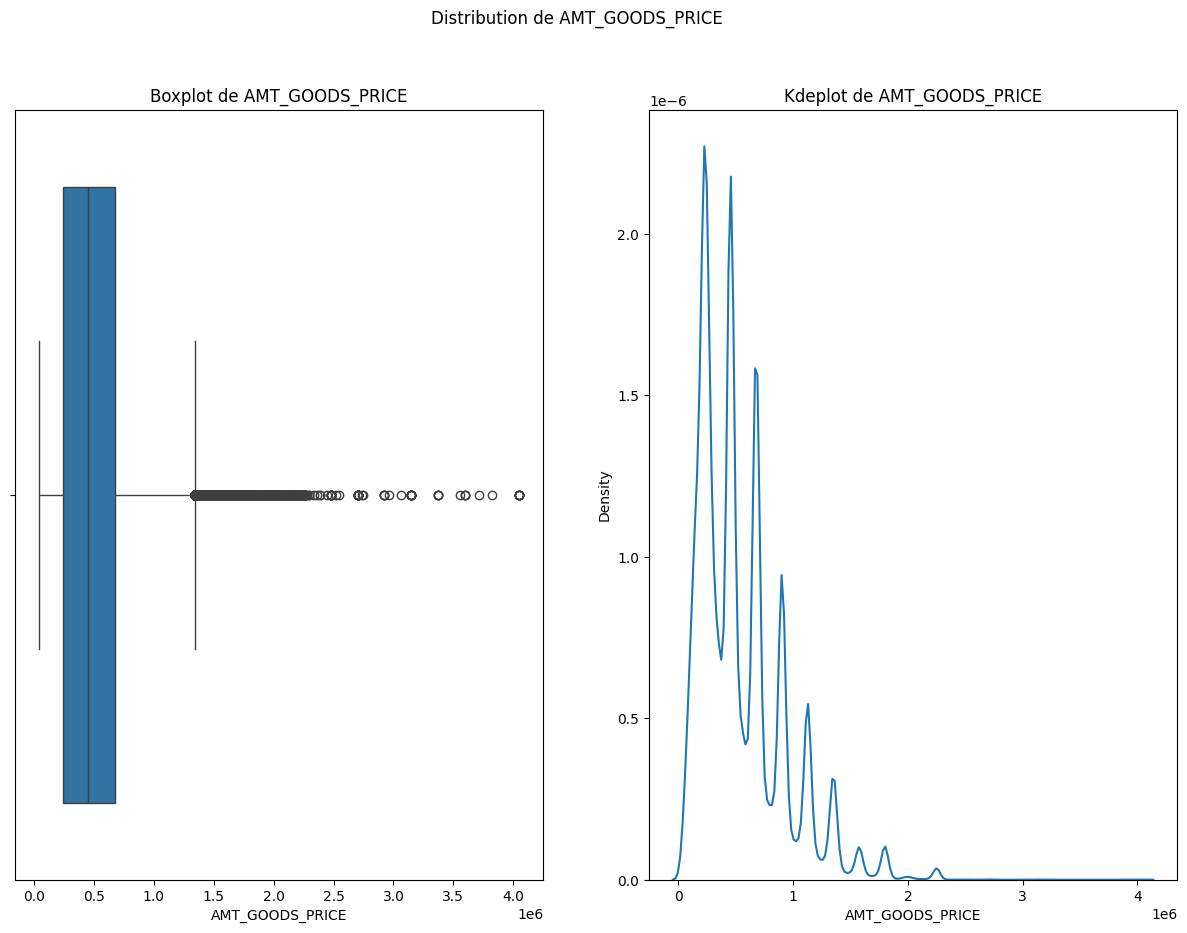

In [28]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
sns.boxplot(application_train['AMT_GOODS_PRICE'], orient='h')
plt.title('Boxplot de AMT_GOODS_PRICE')

plt.subplot(1,2,2)
sns.kdeplot(application_train['AMT_GOODS_PRICE'])
plt.title('Kdeplot de AMT_GOODS_PRICE')

plt.suptitle("Distribution de AMT_GOODS_PRICE")
plt.show()

In [29]:
app_train_amt_goods_price_skew = round(skew(application_train['AMT_GOODS_PRICE'], bias=True, axis=0),2)
app_train_amt_goods_price_kurt = round(kurtosis(application_train['AMT_GOODS_PRICE'], fisher=True, bias=True, axis=0),2)
app_train_amt_goods_price_mean = round(application_train['AMT_GOODS_PRICE'].mean(),2)
app_train_amt_goods_price_med = round(application_train['AMT_GOODS_PRICE'].median(),2)

print("Skewness :", app_train_amt_goods_price_skew)
print("Kurtosis :", app_train_amt_goods_price_kurt)
print("Moyenne :", app_train_amt_goods_price_mean, "USD")
print("Médiane :", app_train_amt_goods_price_med, "USD")
print("Minimum :", application_train['AMT_GOODS_PRICE'].min(), "USD")
print("Maximum :", application_train['AMT_GOODS_PRICE'].max(), "USD")
app_train_amt_goods_price_q1 = np.percentile(application_train['AMT_GOODS_PRICE'], 25)
app_train_amt_goods_price_q3 = np.percentile(application_train['AMT_GOODS_PRICE'], 75)
app_train_amt_goods_price_iqr = app_train_amt_goods_price_q3 - app_train_amt_goods_price_q1
print("IQR AMT_GOODS_PRICE:", app_train_amt_goods_price_iqr)

Skewness : nan
Kurtosis : nan
Moyenne : 538396.21 USD
Médiane : 450000.0 USD
Minimum : 40500.0 USD
Maximum : 4050000.0 USD
IQR AMT_GOODS_PRICE: nan


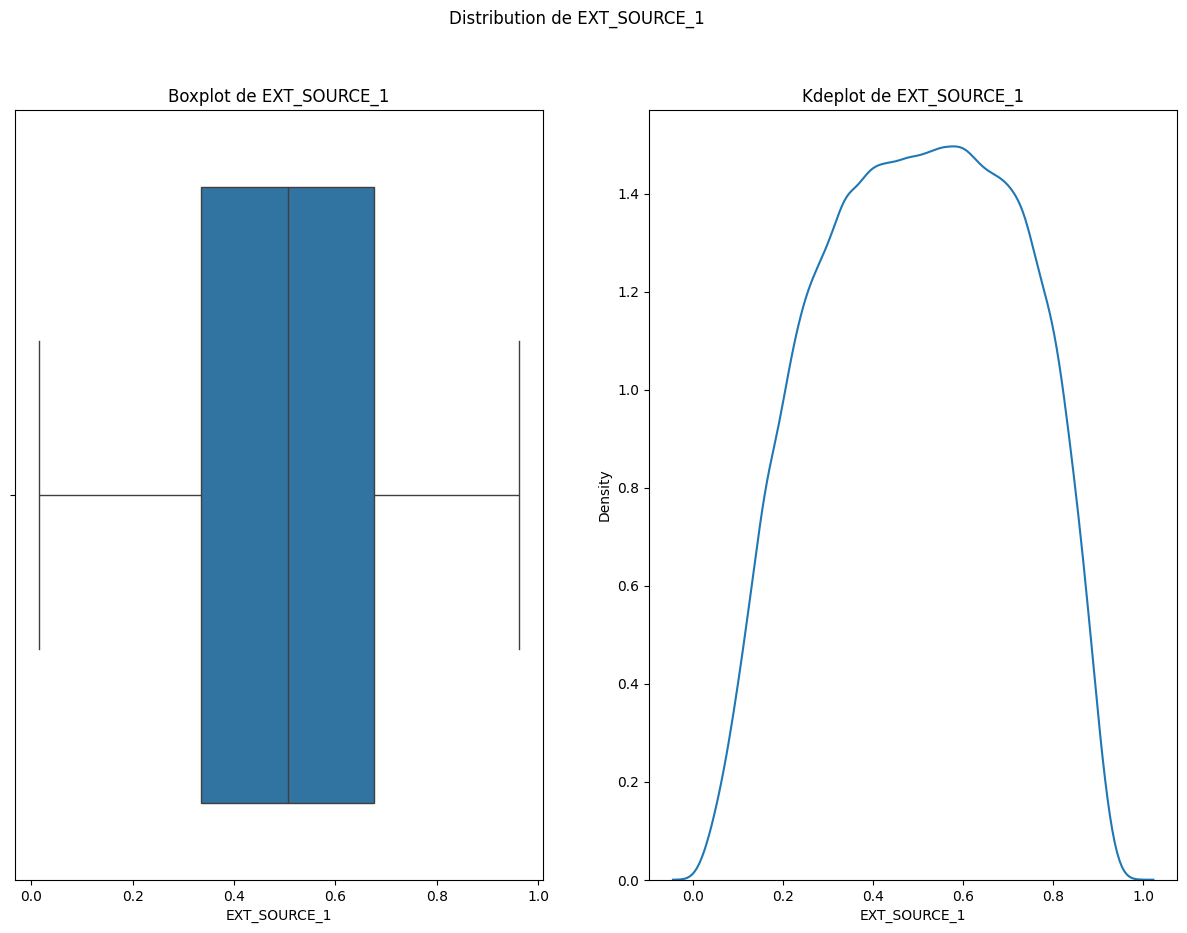

In [30]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
sns.boxplot(application_train['EXT_SOURCE_1'], orient='h')
plt.title('Boxplot de EXT_SOURCE_1')

plt.subplot(1,2,2)
sns.kdeplot(application_train['EXT_SOURCE_1'])
plt.title('Kdeplot de EXT_SOURCE_1')

plt.suptitle("Distribution de EXT_SOURCE_1")
plt.show()

In [31]:
app_train_ext_src_1_skew = round(skew(application_train['EXT_SOURCE_1'], bias=True, axis=0),2)
app_train_ext_src_1_kurt = round(kurtosis(application_train['EXT_SOURCE_1'], fisher=True, bias=True, axis=0),2)
app_train_ext_src_1_mean = round(application_train['EXT_SOURCE_1'].mean(),2)
app_train_ext_src_1_med = round(application_train['EXT_SOURCE_1'].median(),2)

print("Skewness :", app_train_ext_src_1_skew)
print("Kurtosis :", app_train_ext_src_1_kurt)
print("Moyenne :", app_train_ext_src_1_mean, "USD")
print("Médiane :", app_train_ext_src_1_med, "USD")
print("Minimum :", application_train['EXT_SOURCE_1'].min())
print("Maximum :", application_train['EXT_SOURCE_1'].max())
app_train_ext_src_1_q1 = np.percentile(application_train['EXT_SOURCE_1'], 25)
app_train_ext_src_1_q3 = np.percentile(application_train['EXT_SOURCE_1'], 75)
app_train_ext_src_1_iqr = app_train_ext_src_1_q3 - app_train_ext_src_1_q1
print("IQR EXT_SOURCE_1:", app_train_ext_src_1_iqr)

shapiro_test = shapiro(application_train['EXT_SOURCE_1'])
print("Test de Shapiro-Wilk :", shapiro_test)

Skewness : nan
Kurtosis : nan
Moyenne : 0.5 USD
Médiane : 0.51 USD
Minimum : 0.0145681324124455
Maximum : 0.962692770561306
IQR EXT_SOURCE_1: nan
Test de Shapiro-Wilk : ShapiroResult(statistic=np.float64(nan), pvalue=np.float64(nan))


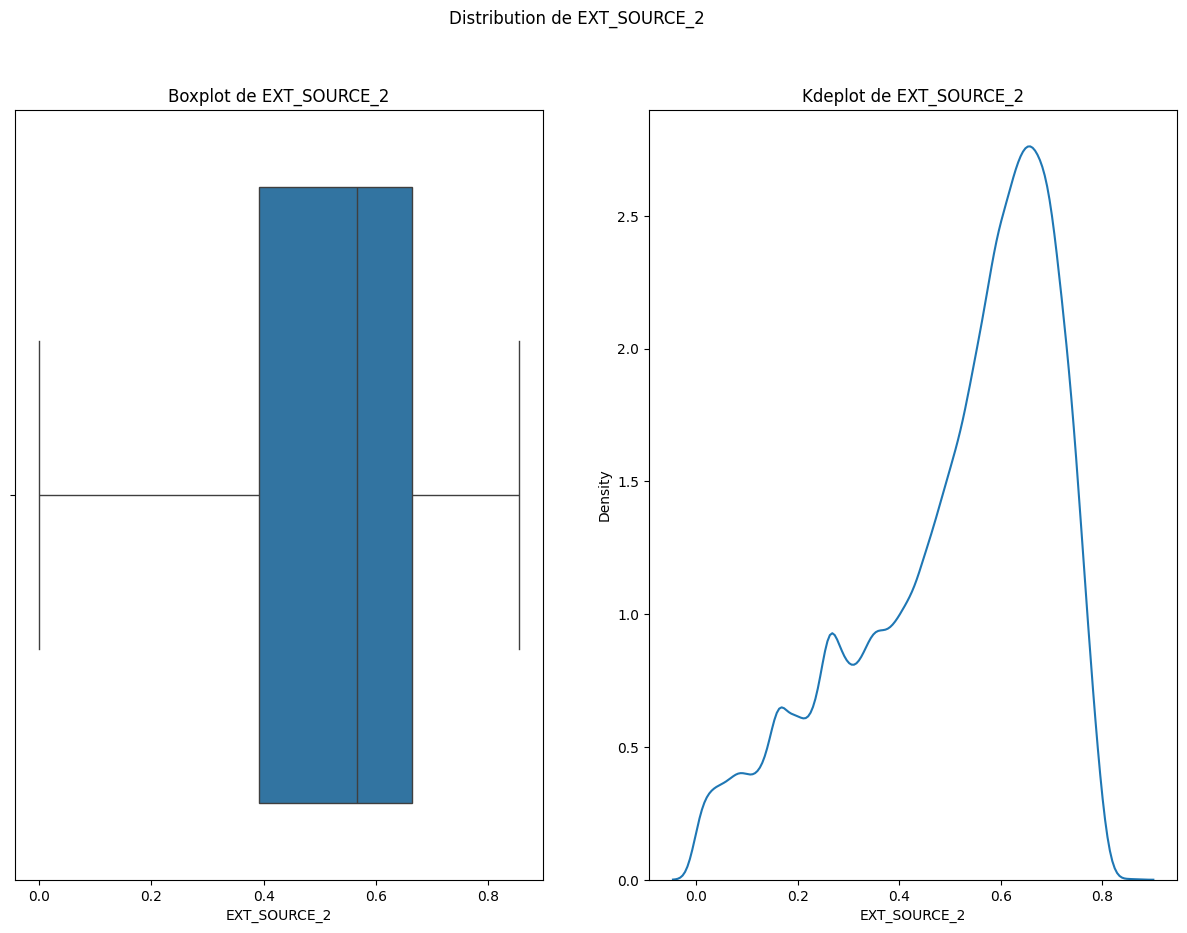

In [32]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
sns.boxplot(application_train['EXT_SOURCE_2'], orient='h')
plt.title('Boxplot de EXT_SOURCE_2')

plt.subplot(1,2,2)
sns.kdeplot(application_train['EXT_SOURCE_2'])
plt.title('Kdeplot de EXT_SOURCE_2')

plt.suptitle("Distribution de EXT_SOURCE_2")
plt.show()

In [33]:
app_train_ext_src_2_skew = round(skew(application_train['EXT_SOURCE_2'], bias=True, axis=0),2)
app_train_ext_src_2_kurt = round(kurtosis(application_train['EXT_SOURCE_2'], fisher=True, bias=True, axis=0),2)
app_train_ext_src_2_mean = round(application_train['EXT_SOURCE_2'].mean(),2)
app_train_ext_src_2_med = round(application_train['EXT_SOURCE_2'].median(),2)

print("Skewness :", app_train_ext_src_2_skew)
print("Kurtosis :", app_train_ext_src_2_kurt)
print("Moyenne :", app_train_ext_src_2_mean, "USD")
print("Médiane :", app_train_ext_src_2_med, "USD")
print("Minimum :", application_train['EXT_SOURCE_2'].min())
print("Maximum :", application_train['EXT_SOURCE_2'].max())
app_train_ext_src_2_q1 = np.percentile(application_train['EXT_SOURCE_2'], 25)
app_train_ext_src_2_q3 = np.percentile(application_train['EXT_SOURCE_2'], 75)
app_train_ext_src_2_iqr = app_train_ext_src_2_q3 - app_train_ext_src_2_q1
print("IQR EXT_SOURCE_2:", app_train_ext_src_2_iqr)

shapiro_test = shapiro(application_train['EXT_SOURCE_2'])
print("Test de Shapiro-Wilk :", shapiro_test)

Skewness : nan
Kurtosis : nan
Moyenne : 0.51 USD
Médiane : 0.57 USD
Minimum : 8.173616518884397e-08
Maximum : 0.8549996664047012
IQR EXT_SOURCE_2: nan
Test de Shapiro-Wilk : ShapiroResult(statistic=np.float64(nan), pvalue=np.float64(nan))


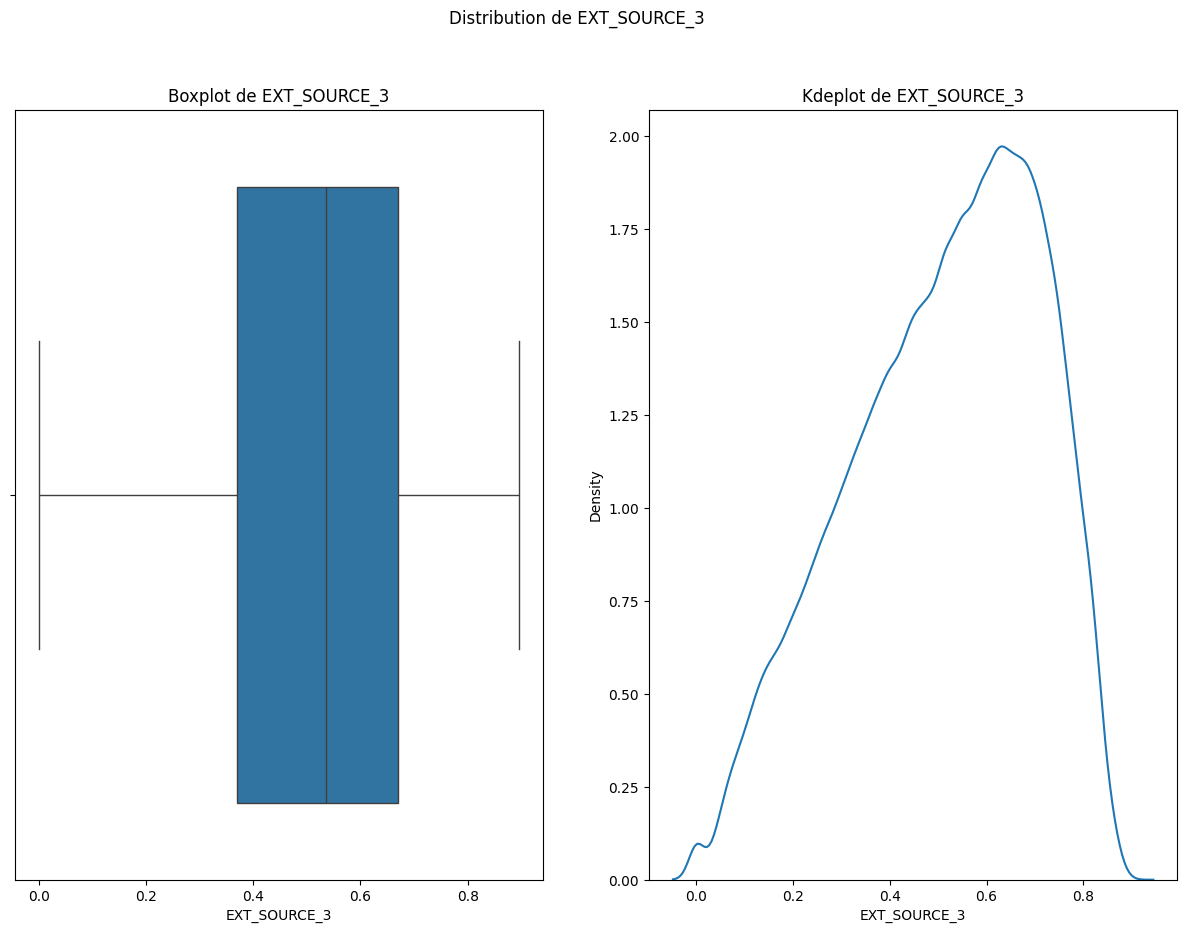

In [34]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
sns.boxplot(application_train['EXT_SOURCE_3'], orient='h')
plt.title('Boxplot de EXT_SOURCE_3')

plt.subplot(1,2,2)
sns.kdeplot(application_train['EXT_SOURCE_3'])
plt.title('Kdeplot de EXT_SOURCE_3')

plt.suptitle("Distribution de EXT_SOURCE_3")
plt.show()

In [35]:
app_train_ext_src_3_skew = round(skew(application_train['EXT_SOURCE_3'], bias=True, axis=0),2)
app_train_ext_src_3_kurt = round(kurtosis(application_train['EXT_SOURCE_3'], fisher=True, bias=True, axis=0),2)
app_train_ext_src_3_mean = round(application_train['EXT_SOURCE_3'].mean(),2)
app_train_ext_src_3_med = round(application_train['EXT_SOURCE_3'].median(),2)

print("Skewness :", app_train_ext_src_3_skew)
print("Kurtosis :", app_train_ext_src_3_kurt)
print("Moyenne :", app_train_ext_src_3_mean, "USD")
print("Médiane :", app_train_ext_src_3_med, "USD")
print("Minimum :", application_train['EXT_SOURCE_3'].min())
print("Maximum :", application_train['EXT_SOURCE_3'].max())
app_train_ext_src_3_q1 = np.percentile(application_train['EXT_SOURCE_3'], 25)
app_train_ext_src_3_q3 = np.percentile(application_train['EXT_SOURCE_3'], 75)
app_train_ext_src_3_iqr = app_train_ext_src_3_q3 - app_train_ext_src_3_q1
print("IQR EXT_SOURCE_3:", app_train_ext_src_3_iqr)

shapiro_test = shapiro(application_train['EXT_SOURCE_3'])
print("Test de Shapiro-Wilk :", shapiro_test)

Skewness : nan
Kurtosis : nan
Moyenne : 0.51 USD
Médiane : 0.54 USD
Minimum : 0.0005272652387098
Maximum : 0.8960095494948396
IQR EXT_SOURCE_3: nan
Test de Shapiro-Wilk : ShapiroResult(statistic=np.float64(nan), pvalue=np.float64(nan))


In [36]:
application_train['AGE'] = (application_train['DAYS_BIRTH'] / -365).astype(int)
application_train['AGE'].describe()

count    307511.000000
mean         43.435968
std          11.954593
min          20.000000
25%          34.000000
50%          43.000000
75%          53.000000
max          69.000000
Name: AGE, dtype: float64

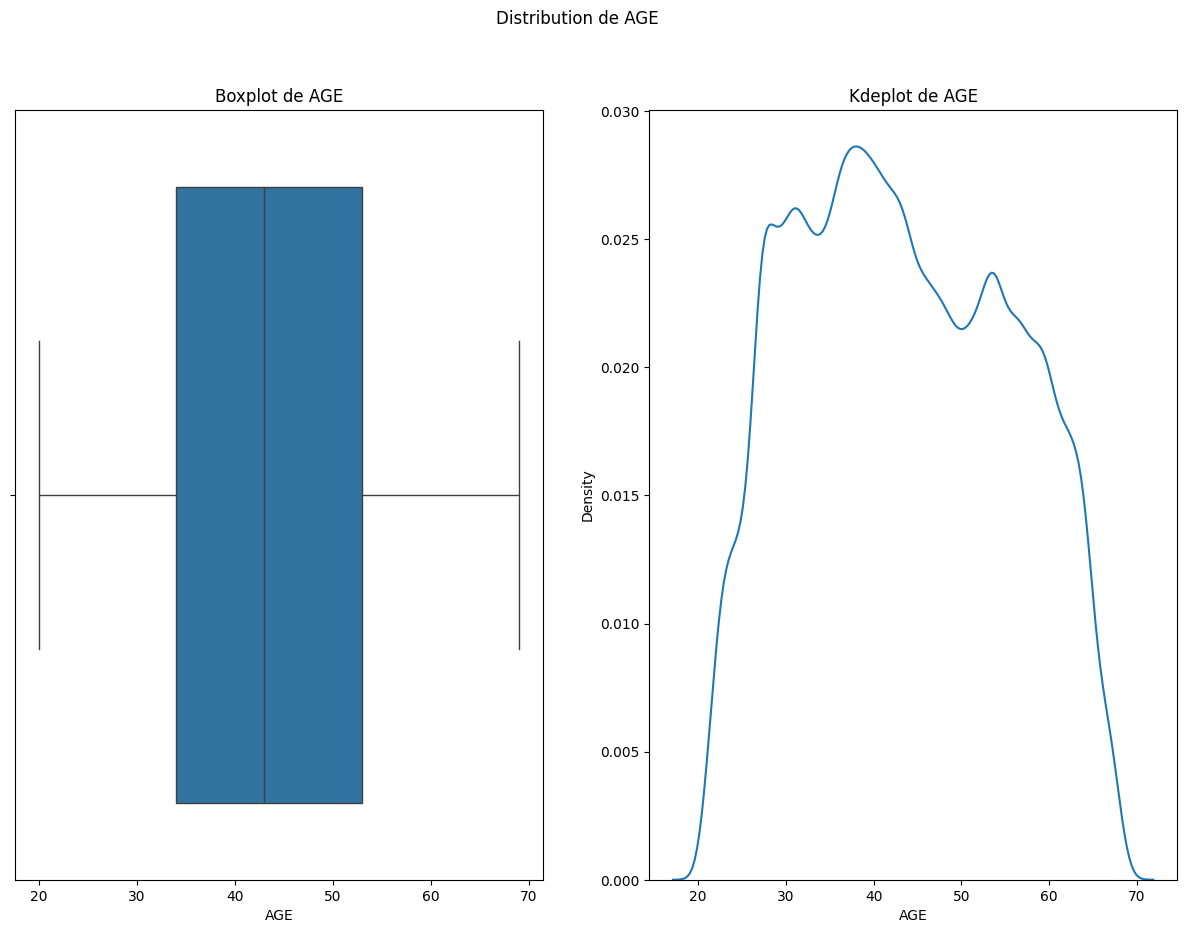

In [37]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
sns.boxplot(application_train['AGE'], orient='h')
plt.title('Boxplot de AGE')

plt.subplot(1,2,2)
sns.kdeplot(application_train['AGE'])
plt.title('Kdeplot de AGE')

plt.suptitle("Distribution de AGE")
plt.show()

In [38]:
application_test['AGE'] = (application_test['DAYS_BIRTH'] / -365).astype(int)
application_test['AGE'].describe()

count    48744.000000
mean        43.526649
std         11.854446
min         20.000000
25%         34.000000
50%         43.000000
75%         53.000000
max         69.000000
Name: AGE, dtype: float64

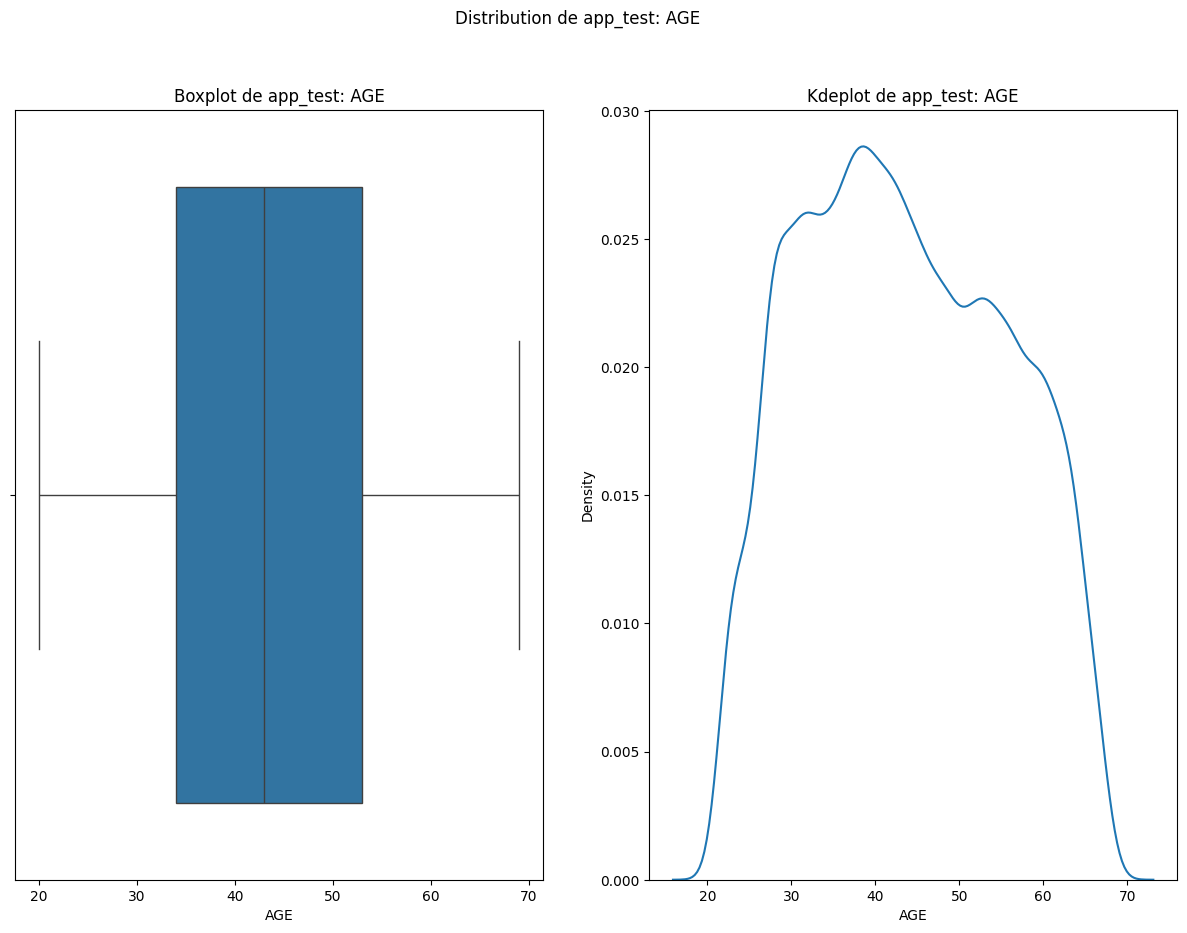

In [39]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
sns.boxplot(application_test['AGE'], orient='h')
plt.title('Boxplot de app_test: AGE')

plt.subplot(1,2,2)
sns.kdeplot(application_test['AGE'])
plt.title('Kdeplot de app_test: AGE')

plt.suptitle("Distribution de app_test: AGE")
plt.show()

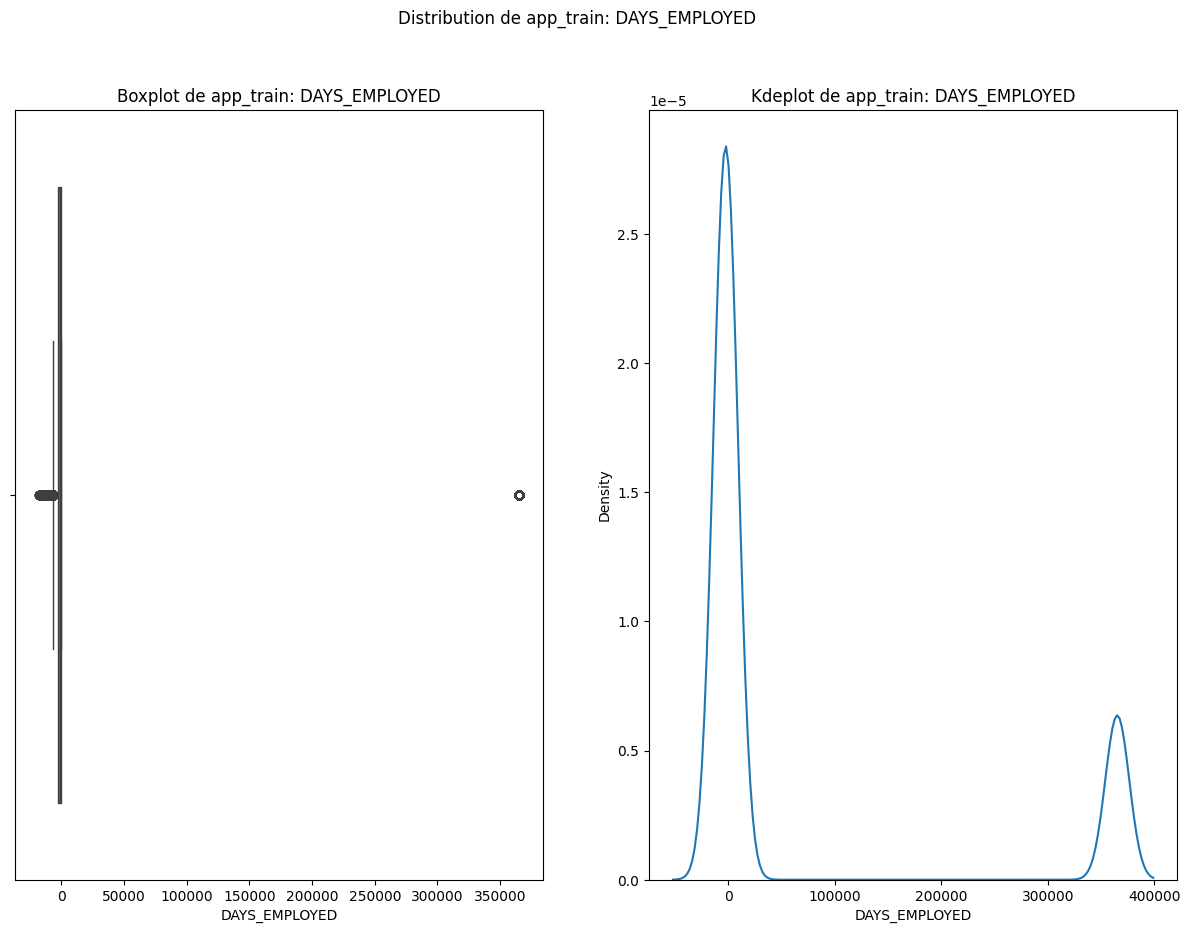

In [40]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
sns.boxplot(application_train['DAYS_EMPLOYED'], orient='h')
plt.title('Boxplot de app_train: DAYS_EMPLOYED')

plt.subplot(1,2,2)
sns.kdeplot(application_train['DAYS_EMPLOYED'])
plt.title('Kdeplot de app_train: DAYS_EMPLOYED')

plt.suptitle("Distribution de app_train: DAYS_EMPLOYED")
plt.show()

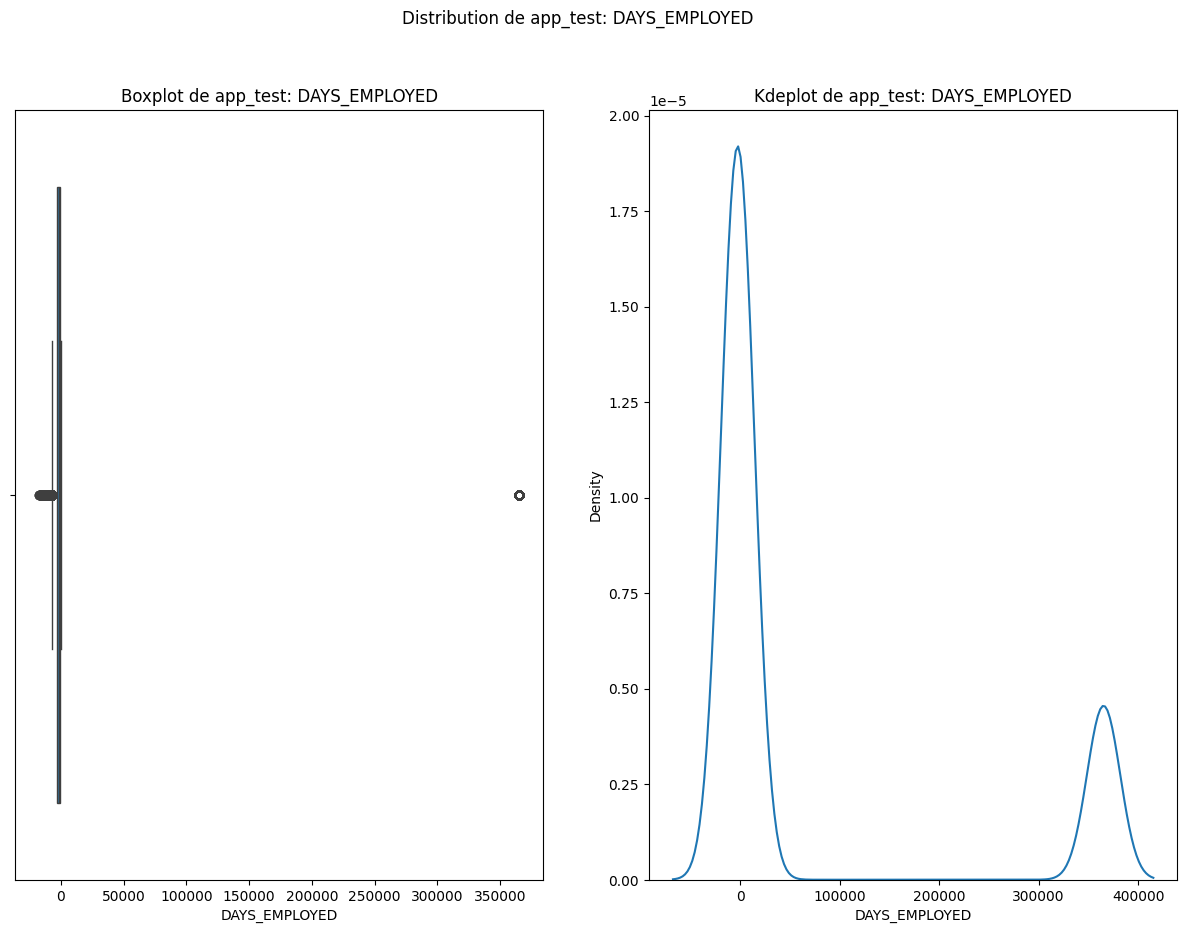

In [41]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
sns.boxplot(application_test['DAYS_EMPLOYED'], orient='h')
plt.title('Boxplot de app_test: DAYS_EMPLOYED')

plt.subplot(1,2,2)
sns.kdeplot(application_test['DAYS_EMPLOYED'])
plt.title('Kdeplot de app_test: DAYS_EMPLOYED')

plt.suptitle("Distribution de app_test: DAYS_EMPLOYED")
plt.show()

In [42]:
anom = application_train[application_train['DAYS_EMPLOYED'] == 365243]
non_anom = application_train[application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


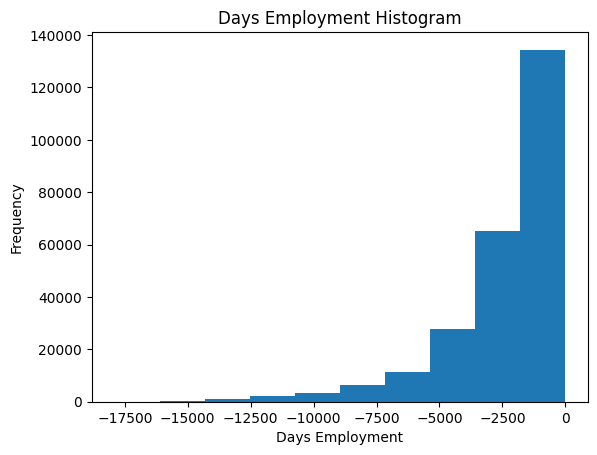

In [43]:
# Create an anomalous flag column
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [44]:
application_test['DAYS_EMPLOYED_ANOM'] = application_test["DAYS_EMPLOYED"] == 365243
application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (application_test["DAYS_EMPLOYED_ANOM"].sum(), len(application_test)))

There are 9274 anomalies in the test data out of 48744 entries


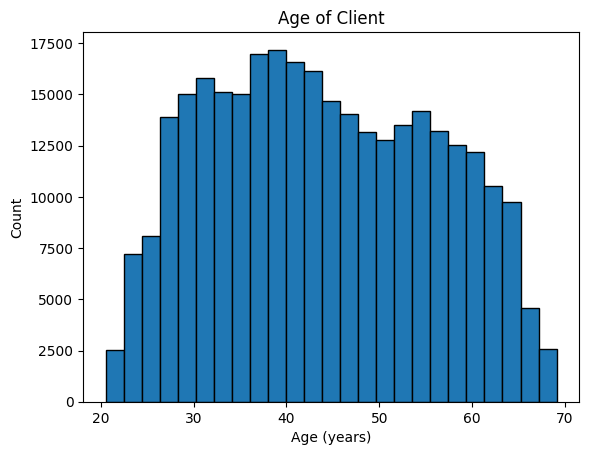

In [45]:
# Plot the distribution of ages in years
plt.hist(application_train['DAYS_BIRTH'] / - 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

#### 4 - Bivariate analysis

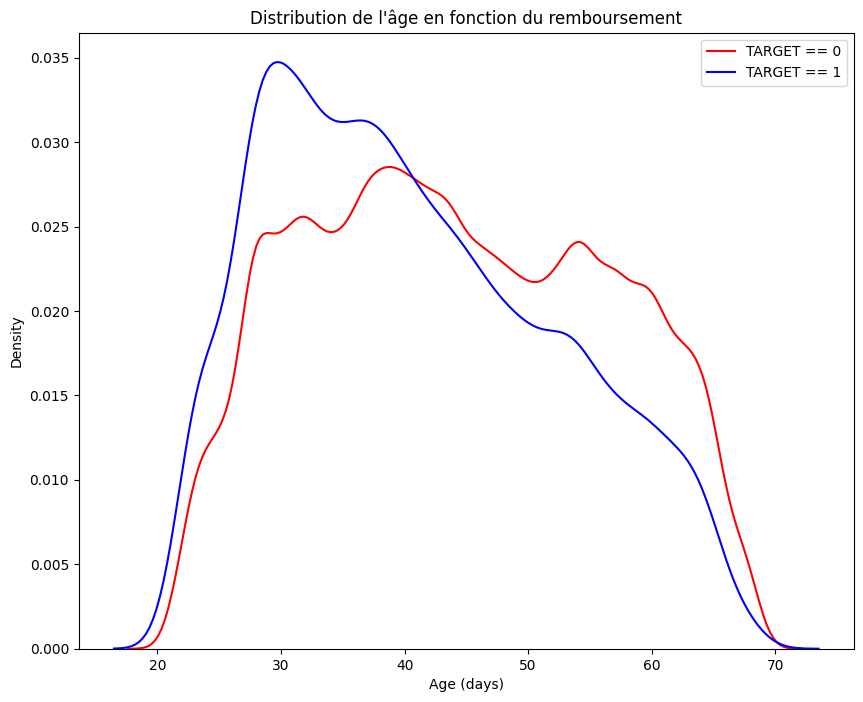

In [46]:
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

application_train['AGE_BINNED'] = pd.cut(application_train['AGE'], bins=np.linspace(20, 70, num=6))

plt.figure(figsize = (10,8))

sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, color='r', label='TARGET == 0')

sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, color='b', label='TARGET == 1')

plt.xlabel('Age (days)')
plt.ylabel('Density')
plt.title("Distribution de l'âge en fonction du remboursement")
plt.legend()

plt.show()

In [47]:
# Créer des tranches d'âge
application_train['AGE_GROUP'] = pd.cut(application_train['AGE'],
                                        bins=[0, 25, 35, 45, 55, 70],
                                        labels=['<25', '25-35', '35-45', '45-55', '55+'])

# Calculer le taux de défaut par groupe d'âge
age_default_rate = application_train.groupby('AGE_GROUP')['TARGET'].mean()
print("Taux de défaut par groupe d'âge:")
print(age_default_rate)

# Mapper ce taux à chaque ligne
application_train['AGE_GROUP_DEFAULT_RATE'] = application_train['AGE_GROUP'].map(age_default_rate)

Taux de défaut par groupe d'âge:
AGE_GROUP
<25      0.117416
25-35    0.105854
35-45    0.082376
45-55    0.068488
55+      0.051844
Name: TARGET, dtype: float64


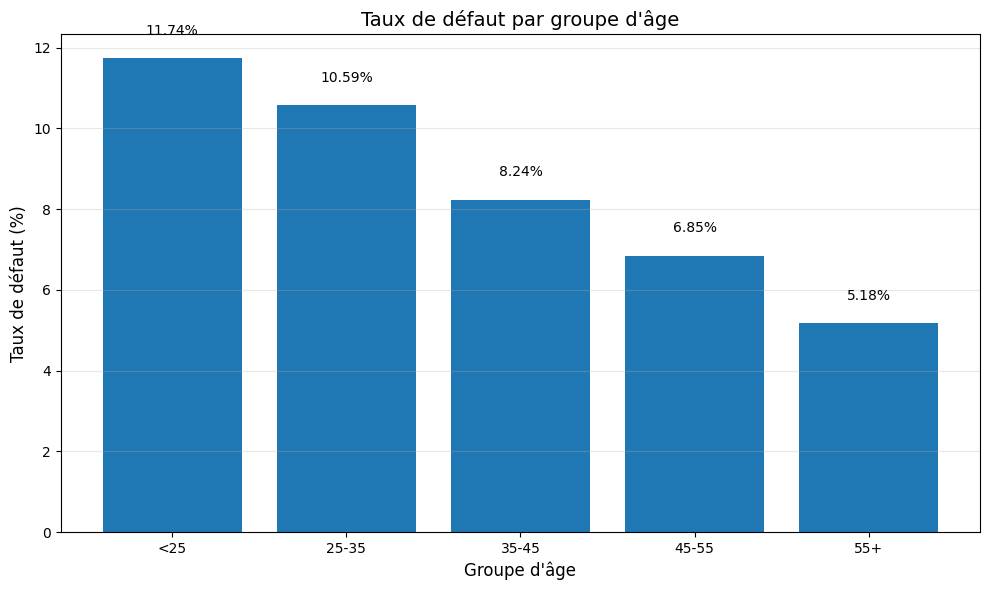

In [48]:
plt.figure(figsize=(10, 6))
plt.bar(age_default_rate.index.astype(str), 100 * age_default_rate)

# Plot labeling
plt.xlabel('Groupe d\'âge', fontsize=12)
plt.ylabel('Taux de défaut (%)', fontsize=12)
plt.title('Taux de défaut par groupe d\'âge', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, (idx, value) in enumerate(age_default_rate.items()):
    plt.text(i, 100 * value + 0.5, f'{100 * value:.2f}%',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [49]:
# Find correlations with the target and sort
correlations = application_train.corr(numeric_only=True)['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_BIRTH                   -0.078239
AGE                          -0.078234
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768


In [50]:
# Extract the EXT_SOURCE variables and show correlations
income_df = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL']]
income_df_corrs = income_df.corr()
income_df_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
TARGET            1.000000     -0.155317     -0.160472     -0.178919   
EXT_SOURCE_1     -0.155317      1.000000      0.213982      0.186846   
EXT_SOURCE_2     -0.160472      0.213982      1.000000      0.109167   
EXT_SOURCE_3     -0.178919      0.186846      0.109167      1.000000   
DAYS_BIRTH       -0.078239      0.600610      0.091996      0.205478   
AMT_INCOME_TOTAL -0.003982      0.026232      0.060925     -0.030229   

                  DAYS_BIRTH  AMT_INCOME_TOTAL  
TARGET             -0.078239         -0.003982  
EXT_SOURCE_1        0.600610          0.026232  
EXT_SOURCE_2        0.091996          0.060925  
EXT_SOURCE_3        0.205478         -0.030229  
DAYS_BIRTH          1.000000         -0.027261  
AMT_INCOME_TOTAL   -0.027261          1.000000

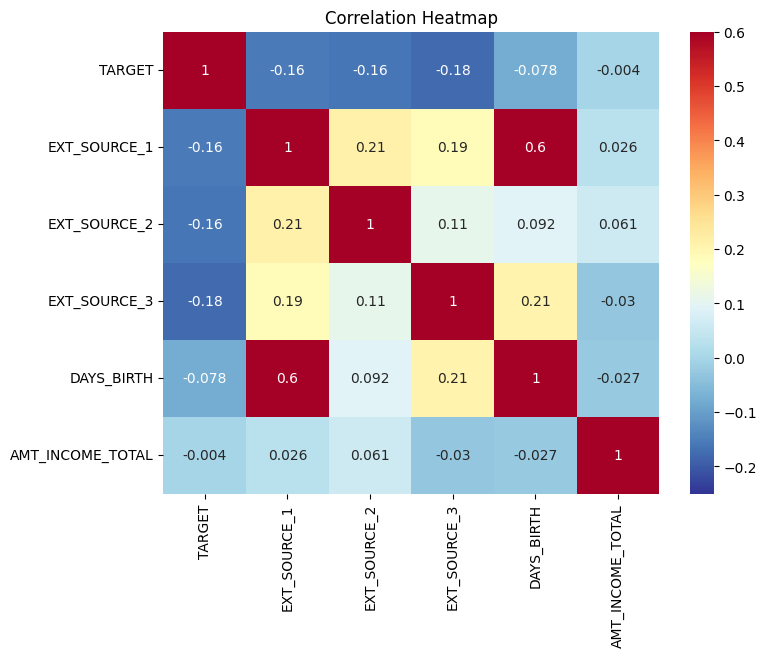

In [51]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(income_df_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

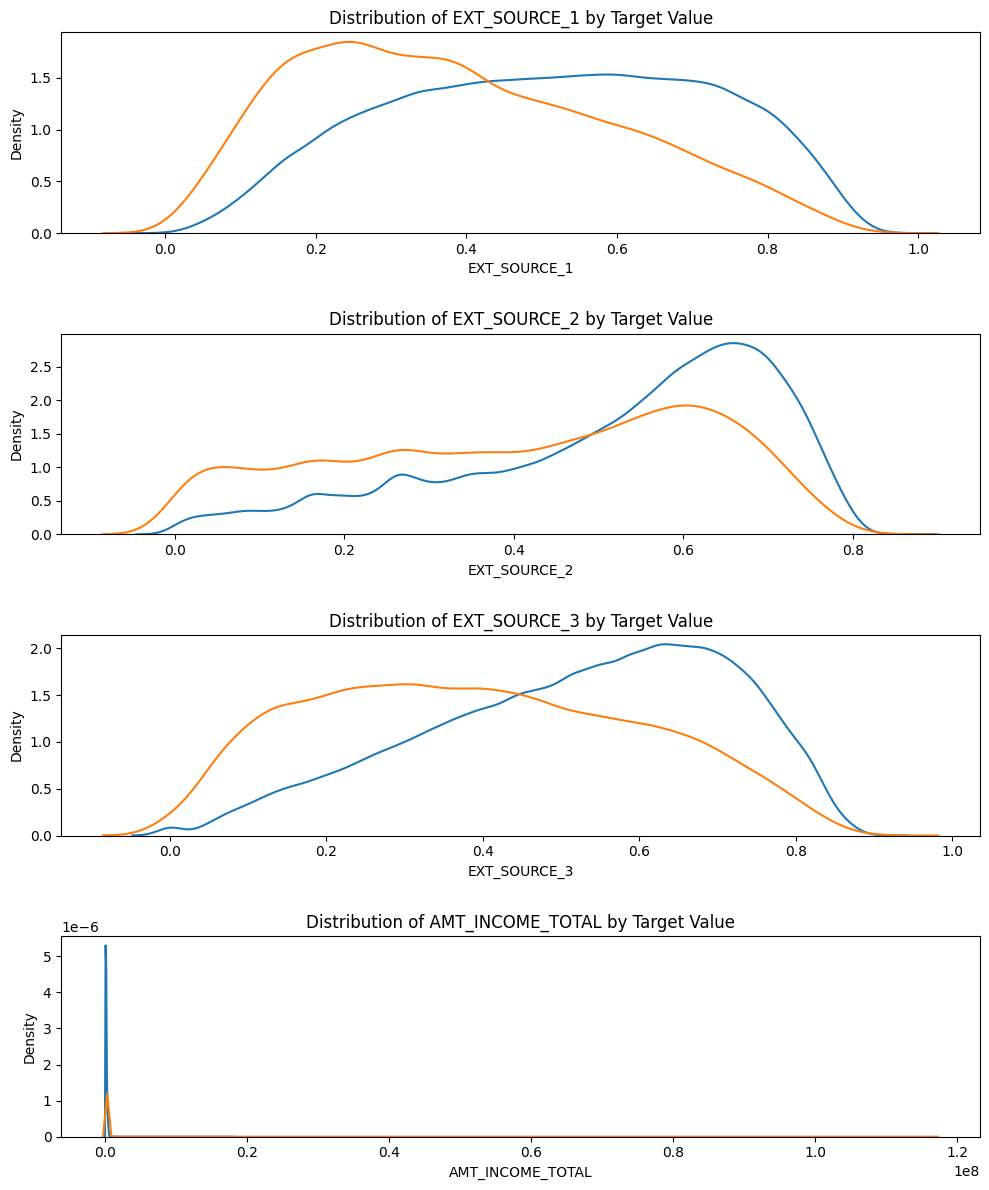

In [52]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_INCOME_TOTAL']):

    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, source], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

Correlation

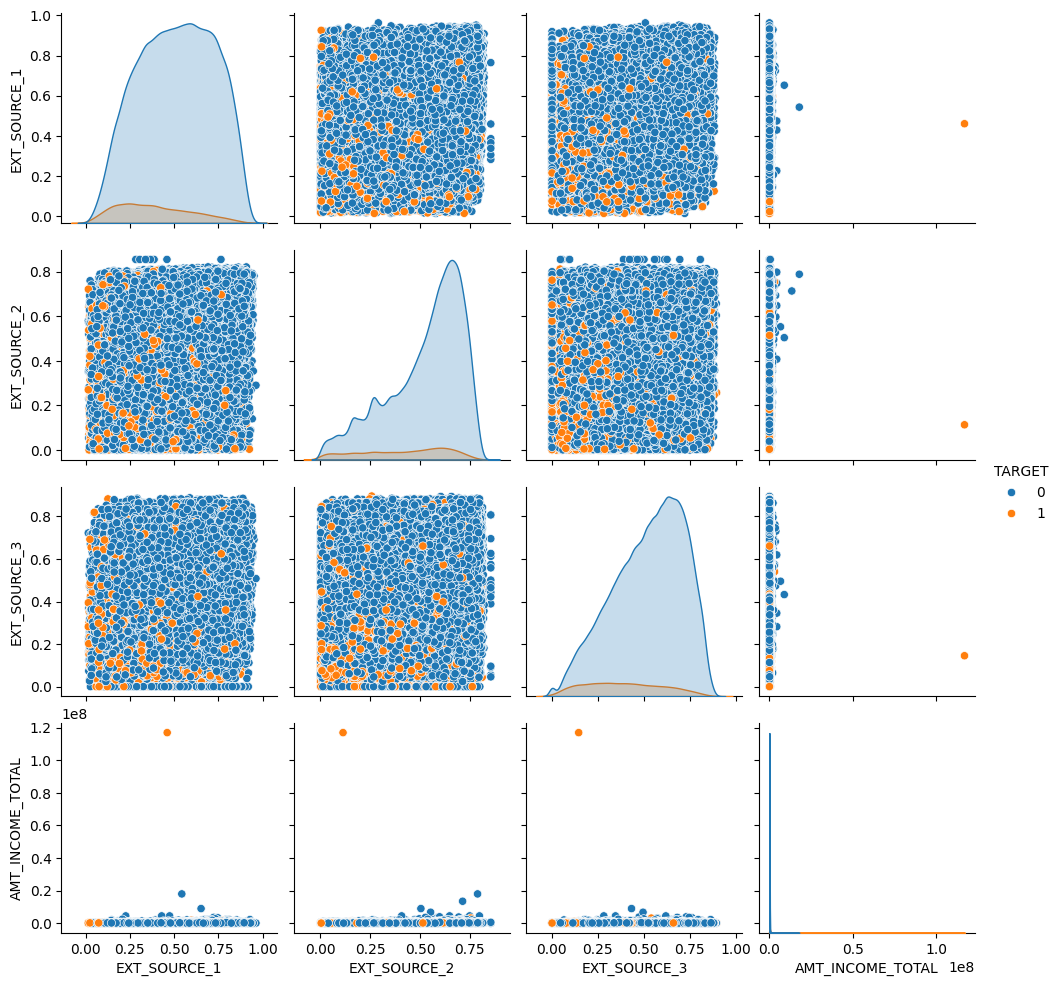

In [53]:
sns.pairplot(income_df, hue = 'TARGET', vars = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_INCOME_TOTAL'])

FEATURE CATEGORIELLE

In [54]:
uniqueclass_df = application_train.select_dtypes('object').apply(pd.Series.nunique, axis= 0)
display(uniqueclass_df)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [55]:
list_cols_sup_2_class = uniqueclass_df[uniqueclass_df > 2].index.tolist()
print(list_cols_sup_2_class)

['CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']


### D - FEATURES ENGINEERING

In [56]:
list_cols_inf_2_class = uniqueclass_df[uniqueclass_df <= 2].index.tolist()

le = LabelEncoder()
for col in list_cols_inf_2_class:
  application_train[col] = le.fit_transform(application_train[col])

In [57]:
app_train_ohe = pd.get_dummies(application_train)

print("Les dimensions de app_train_ohe sont:", app_train_ohe.shape)

Les dimensions de app_train_ohe sont: (307511, 259)


In [58]:
uniquetestclass_df = application_test.select_dtypes('object').apply(pd.Series.nunique, axis= 0)
display(uniquetestclass_df)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [59]:
list_cols_sup_2_test_class = uniquetestclass_df[uniquetestclass_df > 2].index.tolist()
print(list_cols_sup_2_test_class)

['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']


In [60]:
list_cols_inf_2_test_class = uniquetestclass_df[uniquetestclass_df <= 2].index.tolist()

le = LabelEncoder()
for col in list_cols_inf_2_test_class:
  application_test[col] = le.fit_transform(application_test[col])

In [61]:
app_test_ohe = pd.get_dummies(application_test)

print("Les dimensions de app_test_ohe sont:", app_test_ohe.shape)

Les dimensions de app_test_ohe sont: (48744, 239)


In [62]:
train_labels = application_train['TARGET']

app_train_ohe, app_test_ohe = app_train_ohe.align(app_test_ohe, join = 'inner', axis = 1)

app_train_ohe['TARGET'] = train_labels

print('Training Features shape: ', app_train_ohe.shape)
print('Testing Features shape: ', app_test_ohe.shape)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 238)


In [63]:
# Make a new dataframe for polynomial features
poly_features = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [64]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [65]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [66]:
# Create a dataframe of the features
poly_features = pd.DataFrame(poly_features,
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [67]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test,
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = application_train['SK_ID_CURR']
app_train_poly = application_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = application_test['SK_ID_CURR']
app_test_poly = application_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(application_test, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 119)
Testing data with polynomial features shape:   (48744, 119)


In [68]:
app_train_domain = application_train.copy()
app_test_domain = application_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [69]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

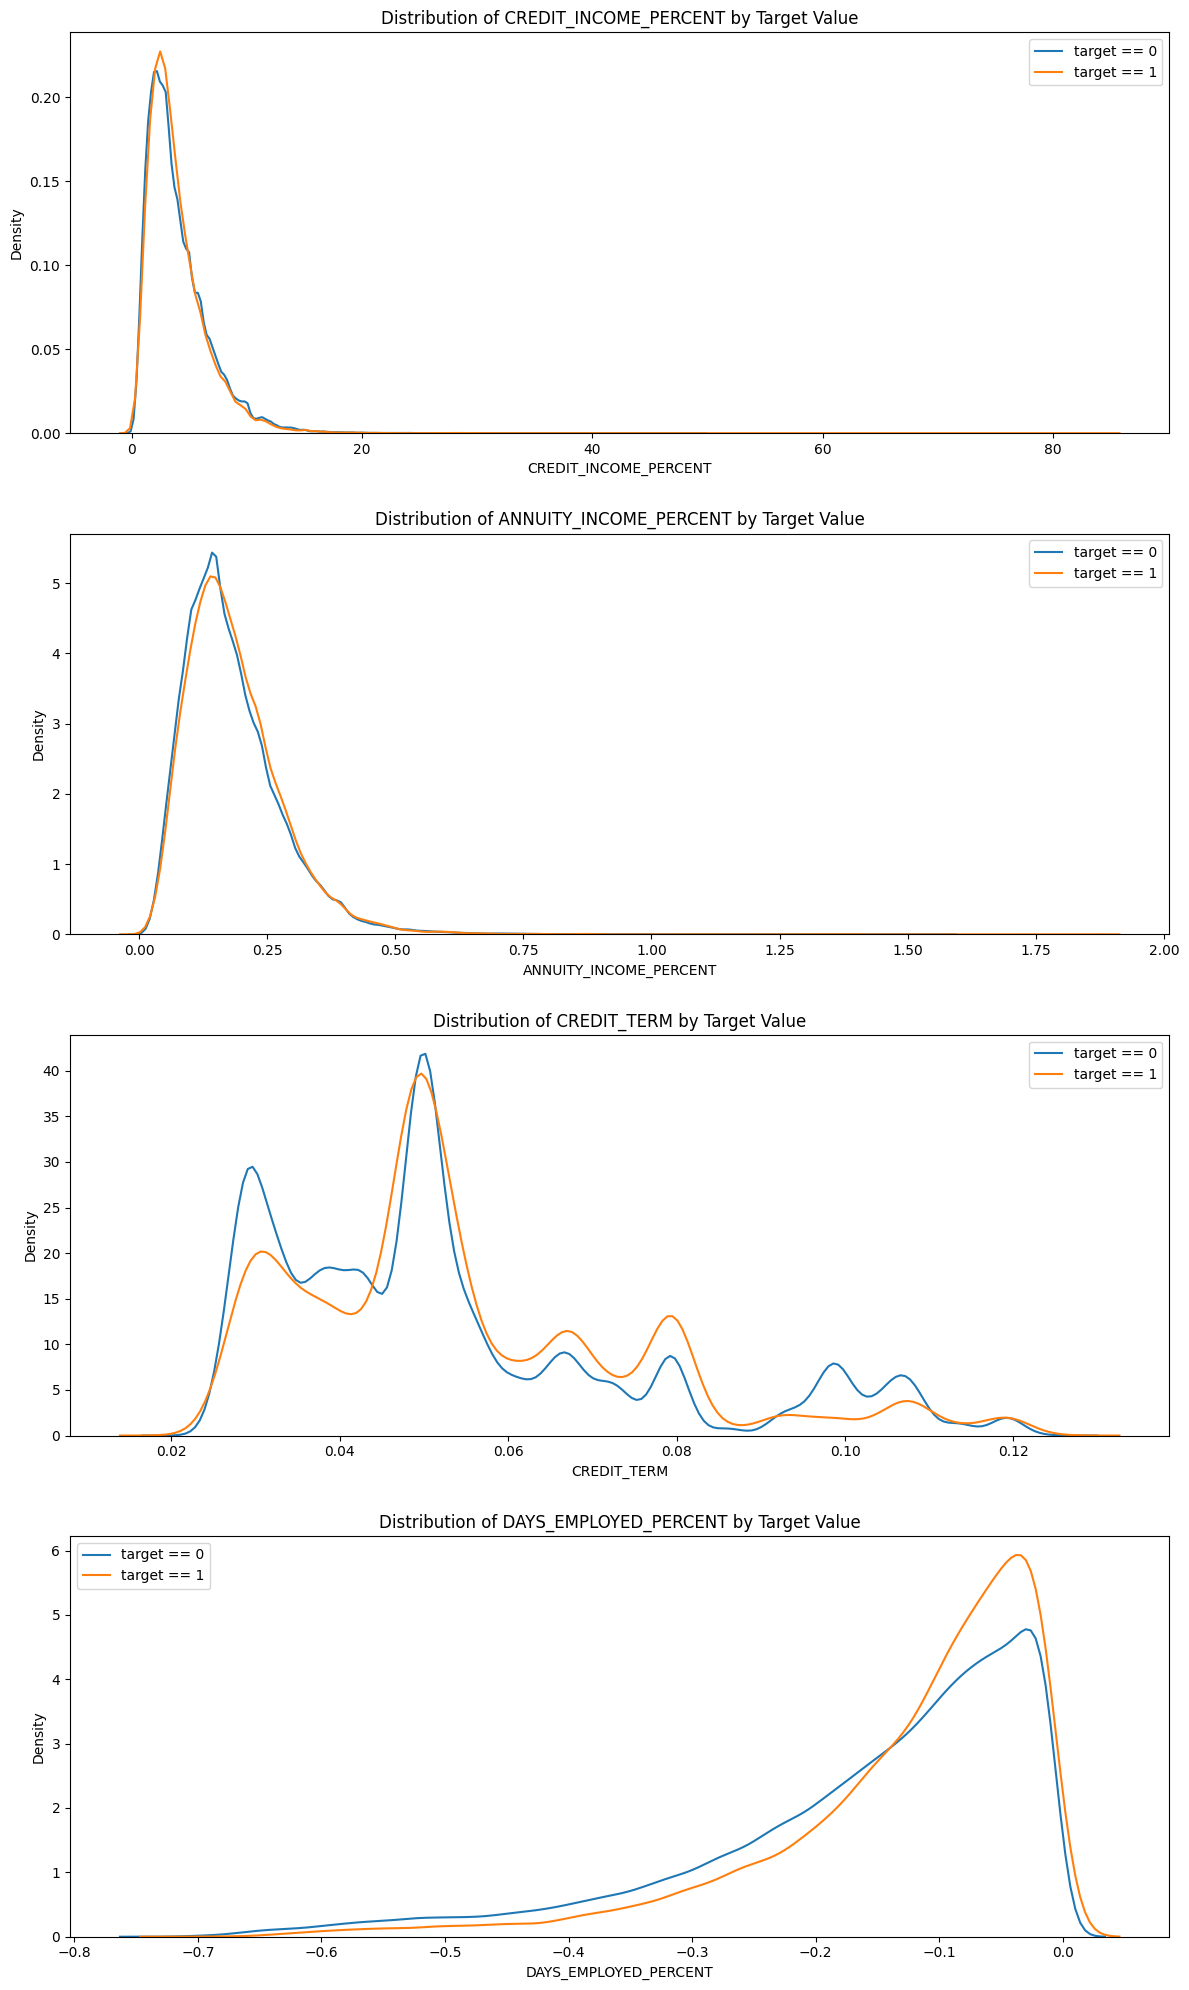

In [70]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):

    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density')
    plt.legend();

plt.tight_layout(h_pad = 2.5)

## DATA PREPROCESSING

In [71]:
from sklearn.preprocessing import MinMaxScaler

# Drop the target from the training data
train = app_train_ohe.drop(columns=['TARGET'])
test = app_test_ohe.copy()

# Feature names
features = list(train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 238)
Testing data shape:  (48744, 238)


# BASELINE (avec gestion du déséquilibre de classe)

In [72]:
def Score_metier(y_true, y_pred, fn_value=-10, fp_value=-1, tp_value=1, tn_value=1):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)

    # Nombre de True Negatifs
    tn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    tp = mat_conf[1, 1]

    # Gain total
    J = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value

    # Gain maximum
    max_J = (fp + tn)*tn_value + (fn + tp)*tp_value

    # Gain minimum
    min_J = (fp + tn)*fp_value + (fn + tp)*fn_value

    # Gain normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)

    return J_normalized  # Retourne la fonction d'évaluation

In [73]:
from sklearn.dummy import DummyClassifier
import lightgbm as lgb
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, 
    recall_score, f1_score, classification_report, 
    confusion_matrix, roc_curve
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Démarre une expérimentation
mlflow.set_experiment("CREDIT_RISKS_CLASSIFICATION_V8")

X_train, X_val, y_train, y_val = train_test_split(
    train, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {test.shape}")
print(f"Number of features: {len(features)}")
print(f"Class distribution: {y_train.value_counts().to_dict()}\n")


# 1. DUMMY CLASSIFIER (BASELINE)
print("=" * 50)
print("DUMMY CLASSIFIER")
print("=" * 50)

with mlflow.start_run(run_name="Dummy_classifier"):
    # Log parameters
    mlflow.log_param('strategy', 'most_frequent')
    mlflow.log_param('model_type', "DummyClassifier")
    
    # Train
    dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
    dummy_clf.fit(X_train, y_train)
    
    # Predict probabilities
    dummy_proba_train = dummy_clf.predict_proba(X_train)[:, 1]
    dummy_proba_val = dummy_clf.predict_proba(X_val)[:, 1]
    
    # Calculate optimal threshold
    fpr, tpr, thresholds = roc_curve(y_train, dummy_proba_train)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    mlflow.log_param("optimal_threshold", optimal_threshold)
    
    # Predict with optimal threshold
    dummy_pred_train = [1 if i >= optimal_threshold else 0 for i in dummy_proba_train]
    dummy_pred_val = [1 if i >= optimal_threshold else 0 for i in dummy_proba_val]
    
    # Evaluate on TRAIN
    accuracy_train = accuracy_score(y_train, dummy_pred_train)
    roc_auc_train = roc_auc_score(y_train, dummy_proba_train)
    precision_train = precision_score(y_train, dummy_pred_train, zero_division=0)
    recall_train = recall_score(y_train, dummy_pred_train, zero_division=0)
    f1_train = f1_score(y_train, dummy_pred_train, zero_division=0)
    score_metier_train = Score_metier(y_train, dummy_pred_train)
    
    # Evaluate on VALIDATION
    accuracy_val = accuracy_score(y_val, dummy_pred_val)
    roc_auc_val = roc_auc_score(y_val, dummy_proba_val)
    precision_val = precision_score(y_val, dummy_pred_val, zero_division=0)
    recall_val = recall_score(y_val, dummy_pred_val, zero_division=0)
    f1_val = f1_score(y_val, dummy_pred_val, zero_division=0)
    score_metier_val = Score_metier(y_val, dummy_pred_val)
    
    # Log metrics - TRAIN
    mlflow.log_metric("train_accuracy", accuracy_train)
    mlflow.log_metric("train_roc_auc", roc_auc_train)
    mlflow.log_metric("train_precision", precision_train)
    mlflow.log_metric("train_recall", recall_train)
    mlflow.log_metric("f1_train_score", f1_train)
    mlflow.log_metric("train_score_metier", score_metier_train)
    
    # Log metrics - VALIDATION
    mlflow.log_metric("val_accuracy", accuracy_val)
    mlflow.log_metric("val_roc_auc", roc_auc_val)
    mlflow.log_metric("val_precision", precision_val)
    mlflow.log_metric("val_recall", recall_val)
    mlflow.log_metric("f1_val_score", f1_val)
    mlflow.log_metric("val_score_metier", score_metier_val)
    
    # Log model
    mlflow.sklearn.log_model(dummy_clf, "model")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Train - Accuracy: {accuracy_train:.4f}, ROC_AUC: {roc_auc_train:.4f}, Score Métier: {score_metier_train:.4f}")
    print(f"Val - Accuracy: {accuracy_val:.4f}, ROC AUC: {roc_auc_val:.4f}, Score Métier: {score_metier_val:.4f}")
    print(f"\nValidation Classification Report:")
    print(classification_report(y_val, dummy_pred_val))


# 2. LOGISTIC REGRESSION
print("\n" + "=" * 50)
print("LOGISTIC REGRESSION")
print("=" * 50)

with mlflow.start_run(run_name="Logistic_Regression"):
    # Log parameters
    C_value = 0.0001
    class_weight = {0: 1, 1: 10}
    mlflow.log_param("C", C_value)
    mlflow.log_param("class_weight", str(class_weight))
    mlflow.log_param("penalty", "l2")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("model_type", "LogisticRegression")
    
    # Train
    log_reg = LogisticRegression(
        C=C_value,
        class_weight=class_weight,
        max_iter=1000,
        random_state=42
    )
    log_reg.fit(X_train, y_train)
    
    # Predict probabilities
    log_proba_train = log_reg.predict_proba(X_train)[:, 1]
    log_proba_val = log_reg.predict_proba(X_val)[:, 1]
    
    # Calculate optimal threshold
    fpr, tpr, thresholds = roc_curve(y_train, log_proba_train)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    mlflow.log_param("optimal_threshold", optimal_threshold)
    
    # Predict with optimal threshold
    log_pred_train = [1 if i >= optimal_threshold else 0 for i in log_proba_train]
    log_pred_val = [1 if i >= optimal_threshold else 0 for i in log_proba_val]
    
    # Evaluate on TRAIN
    accuracy_train = accuracy_score(y_train, log_pred_train)
    roc_auc_train = roc_auc_score(y_train, log_proba_train)
    precision_train = precision_score(y_train, log_pred_train)
    recall_train = recall_score(y_train, log_pred_train)
    f1_train = f1_score(y_train, log_pred_train)
    score_metier_train = Score_metier(y_train, log_pred_train)
    
    # Evaluate on VALIDATION
    accuracy_val = accuracy_score(y_val, log_pred_val)
    roc_auc_val = roc_auc_score(y_val, log_proba_val)
    precision_val = precision_score(y_val, log_pred_val)
    recall_val = recall_score(y_val, log_pred_val)
    f1_val = f1_score(y_val, log_pred_val)
    score_metier_val = Score_metier(y_val, log_pred_val)
    
    # Log metrics - TRAIN
    mlflow.log_metric("train_accuracy", accuracy_train)
    mlflow.log_metric("train_roc_auc", roc_auc_train)
    mlflow.log_metric("train_precision", precision_train)
    mlflow.log_metric("train_recall", recall_train)
    mlflow.log_metric("f1_train_score", f1_train)
    mlflow.log_metric("train_score_metier", score_metier_train)
    
    # Log metrics - VALIDATION
    mlflow.log_metric("val_accuracy", accuracy_val)
    mlflow.log_metric("val_roc_auc", roc_auc_val)
    mlflow.log_metric("val_precision", precision_val)
    mlflow.log_metric("val_recall", recall_val)
    mlflow.log_metric("f1_val_score", f1_val)
    mlflow.log_metric("val_score_metier", score_metier_val)
    
    # GRAPHIQUES ADDITIONNELS
    
    # 1. Courbe ROC AUC
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    fpr_val, tpr_val, _ = roc_curve(y_val, log_proba_val)
    auc_val = roc_auc_score(y_val, log_proba_val)
    plt.plot(fpr_val, tpr_val, color='orange', linewidth=3, label='AUC = %0.4f' % auc_val)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Logistic Regression', fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('logreg_ROC_AUC.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/01-ROC_AUC_logreg.png')
    mlflow.log_artifact('logreg_ROC_AUC.png')
    plt.close()
    
    # 2. Matrice de confusion
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    cf_matrix = confusion_matrix(y_val, log_pred_val)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', cbar=True)
    plt.title('Confusion Matrix - Logistic Regression', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('logreg_confusion_matrix.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/02-Confusion_Matrix_logreg.png')
    mlflow.log_artifact('logreg_confusion_matrix.png')
    plt.close()
    
    # 3. Seuil de solvabilité (Score Métier vs Threshold)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 50)
    
    for threshold in threshold_x:
        y_pred_threshold = (log_proba_val >= threshold).astype(int)
        cost_function.append(Score_metier(y_val, y_pred_threshold))
    
    plt.plot(threshold_x, cost_function, linewidth=3, color='green')
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal threshold: {optimal_threshold:.4f}')
    plt.xlabel("Seuil de probabilité", fontsize=12)
    plt.ylabel("Score Métier", fontsize=12)
    plt.title("Score Métier en fonction du seuil - Logistic Regression", fontsize=14)
    plt.xticks(np.linspace(0.0, 1, 11))
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('logreg_seuil_solvabilite.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/03-Seuil_Solvabilite_logreg.png')
    mlflow.log_artifact('logreg_seuil_solvabilite.png')
    plt.close()
    
    # SHAP Analysis for Logistic Regression
    print("\nGenerating SHAP plots for Logistic Regression...")
    try:
        # Créer un échantillon en préservant les noms de colonnes
        if isinstance(X_train, pd.DataFrame):
            X_train_sample = X_train.sample(n=min(1000, len(X_train)), random_state=42)
        else:
            indices = np.random.choice(len(X_train), min(1000, len(X_train)), replace=False)
            X_train_sample = pd.DataFrame(X_train[indices], columns=features)
        
        # Create SHAP explainer
        explainer = shap.LinearExplainer(log_reg, X_train_sample)
        shap_values = explainer.shap_values(X_train_sample)

        if not isinstance(shap_values, list):
            shap_values = [-shap_values, shap_values]
        
        # SHAP Summary Plot (bar)
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_train_sample, plot_type="bar", show=False, class_names=['Class 0', 'Class 1'])
        plt.tight_layout()
        plt.savefig('logreg_shap_summary_bar.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('logreg_shap_summary_bar.png')
        plt.close()
        
        # SHAP Summary Plot (beeswarm) - classe positive
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values[1], X_train_sample, show=False)
        plt.tight_layout()
        plt.savefig('logreg_shap_summary_beeswarm.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('logreg_shap_summary_beeswarm.png')
        plt.close()
        
        print("SHAP plots saved successfully!")
    except Exception as e:
        print(f"Error generating SHAP plots: {e}")
    
    # Log model
    mlflow.sklearn.log_model(log_reg, "model")
    
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Train - Accuracy: {accuracy_train:.4f}, ROC_AUC: {roc_auc_train:.4f}, Score Métier: {score_metier_train:.4f}")
    print(f"Val - Accuracy: {accuracy_val:.4f}, ROC AUC: {roc_auc_val:.4f}, Score Métier: {score_metier_val:.4f}")
    print(f"\nValidation Classification Report:")
    print(classification_report(y_val, log_pred_val))


# 3. RANDOM FOREST
print("\n" + "=" * 50)
print("RANDOM FOREST")
print("=" * 50)

with mlflow.start_run(run_name="Random_Forest"):
    # Log parameters
    n_est = 100
    class_weight = {0: 1, 1: 10}
    mlflow.log_param("n_estimators", n_est)
    mlflow.log_param("class_weight", str(class_weight))
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_jobs", -1)
    mlflow.log_param("model_type", "RandomForest")
    
    # Train
    random_forest = RandomForestClassifier(
        n_estimators=n_est,
        random_state=42,
        verbose=1,
        n_jobs=-1
    )
    random_forest.fit(X_train, y_train)
    
    # Predict probabilities
    rf_proba_train = random_forest.predict_proba(X_train)[:, 1]
    rf_proba_val = random_forest.predict_proba(X_val)[:, 1]
    
    # Calculate optimal threshold
    fpr, tpr, thresholds = roc_curve(y_train, rf_proba_train)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    mlflow.log_param("optimal_threshold", optimal_threshold)
    
    # Predict with optimal threshold
    rf_pred_train = [1 if i >= optimal_threshold else 0 for i in rf_proba_train]
    rf_pred_val = [1 if i >= optimal_threshold else 0 for i in rf_proba_val]
    
    # Evaluate on TRAIN
    accuracy_train = accuracy_score(y_train, rf_pred_train)
    roc_auc_train = roc_auc_score(y_train, rf_proba_train)
    precision_train = precision_score(y_train, rf_pred_train)
    recall_train = recall_score(y_train, rf_pred_train)
    f1_train = f1_score(y_train, rf_pred_train)
    score_metier_train = Score_metier(y_train, rf_pred_train)
    
    # Evaluate on VALIDATION
    accuracy_val = accuracy_score(y_val, rf_pred_val)
    roc_auc_val = roc_auc_score(y_val, rf_proba_val)
    precision_val = precision_score(y_val, rf_pred_val)
    recall_val = recall_score(y_val, rf_pred_val)
    f1_val = f1_score(y_val, rf_pred_val)
    score_metier_val = Score_metier(y_val, rf_pred_val)
    
    # Log metrics TRAIN
    mlflow.log_metric("train_accuracy", accuracy_train)
    mlflow.log_metric("train_roc_auc", roc_auc_train)
    mlflow.log_metric("train_precision", precision_train)
    mlflow.log_metric("train_recall", recall_train)
    mlflow.log_metric("train_f1_score", f1_train)
    mlflow.log_metric("train_score_metier", score_metier_train)
    
    # Log metrics VALIDATION
    mlflow.log_metric("val_accuracy", accuracy_val)
    mlflow.log_metric("val_roc_auc", roc_auc_val)
    mlflow.log_metric("val_precision", precision_val)
    mlflow.log_metric("val_recall", recall_val)
    mlflow.log_metric("val_f1_score", f1_val)
    mlflow.log_metric("val_score_metier", score_metier_val)
    
    # GRAPHIQUES ADDITIONNELS
    
    # 1. Courbe ROC AUC
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    fpr_val, tpr_val, _ = roc_curve(y_val, rf_proba_val)
    auc_val = roc_auc_score(y_val, rf_proba_val)
    plt.plot(fpr_val, tpr_val, color='orange', linewidth=3, label='AUC = %0.4f' % auc_val)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Random Forest', fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('rf_ROC_AUC.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/01-ROC_AUC_rf.png')
    mlflow.log_artifact('rf_ROC_AUC.png')
    plt.close()
    
    # 2. Matrice de confusion
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    cf_matrix = confusion_matrix(y_val, rf_pred_val)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', cbar=True)
    plt.title('Confusion Matrix - Random Forest', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('rf_confusion_matrix.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/02-Confusion_Matrix_rf.png')
    mlflow.log_artifact('rf_confusion_matrix.png')
    plt.close()
    
    # 3. Seuil de solvabilité
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 50)
    
    for threshold in threshold_x:
        y_pred_threshold = (rf_proba_val >= threshold).astype(int)
        cost_function.append(Score_metier(y_val, y_pred_threshold))
    
    plt.plot(threshold_x, cost_function, linewidth=3, color='green')
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal threshold: {optimal_threshold:.4f}')
    plt.xlabel("Seuil de probabilité", fontsize=12)
    plt.ylabel("Score Métier", fontsize=12)
    plt.title("Score Métier en fonction du seuil - Random Forest", fontsize=14)
    plt.xticks(np.linspace(0.0, 1, 11))
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('rf_seuil_solvabilite.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/03-Seuil_Solvabilite_rf.png')
    mlflow.log_artifact('rf_seuil_solvabilite.png')
    plt.close()
    
    # Log feature importances
    feature_importance_values = random_forest.feature_importances_
    feature_importances = pd.DataFrame({
        'feature': features,
        'importance': feature_importance_values
    }).sort_values('importance', ascending=False)
    
    feature_importances.to_csv('feature_importances.csv', index=False)
    mlflow.log_artifact('feature_importances.csv')
    
    # Plot Feature Importances
    plt.figure(figsize=(10, 8))
    top_features = feature_importances.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances - Random Forest')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('rf_feature_importances.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('rf_feature_importances.png')
    plt.close()
    
    # SHAP Analysis for Random Forest
    print("\nGenerating SHAP plots for Random Forest...")
    try:
        # Créer un échantillon en préservant les noms de colonnes
        if isinstance(X_train, pd.DataFrame):
            X_train_sample = X_train.sample(n=min(1000, len(X_train)), random_state=42)
        else:
            indices = np.random.choice(len(X_train), min(1000, len(X_train)), replace=False)
            X_train_sample = pd.DataFrame(X_train[indices], columns=features)
        
        # Create SHAP TreeExplainer
        explainer = shap.TreeExplainer(random_forest)
        shap_values = explainer.shap_values(X_train_sample)

        # Gestion compatibilité SHAP
        if isinstance(shap_values, list):
            shap_values_class0 = shap_values[0]
            shap_values_class1 = shap_values[1]
        else:
            # Nouvelle version de SHAP : un seul tableau -> classe positive
            shap_values_class1 = shap_values
            shap_values_class0 = shap_values # miroir pour classe 0
        
        # Moyenne absolue des valeurs SHAP pour chaque feature
        mean_abs_shap_class0 = np.abs(shap_values_class0).mean(axis=0)
        mean_abs_shap_class1 = np.abs(shap_values_class1).mean(axis=0)

        # Construction d'un DataFrame
        df_importance = pd.DataFrame({
            'feature' : X_train_sample.columns,
            'Class 0' : mean_abs_shap_class0,
            'Class 1' : mean_abs_shap_class1
        }) 
        
        # Trier par importande totale (somme des deux classes)*
        df_importance['total'] = df_importance['Class 0'] + df_importance['Class 1']
        df_importance = df_importance.sort_values('total', ascending=False).head(20)

        # Graphiques en barres empilées
        plt.figure(figsize=(10,7))
        plt.barh(df_importance['feature'],
                 df_importance['Class 0'],
                 color='skyblue',
                 label='Class 0')
        plt.barh(df_importance['feature'],
                 df_importance['Class 1'],
                 left=df_importance['Class 0'],
                 color='salmon',
                 label='Class 1')
        plt.xlabel("Mean(SHAP value)")
        plt.ylabel("Feature")
        plt.title('SHAP Feature Importance (stacked for both classes)')
        plt.legend()
        plt.gca().invert_yaxis() # Pour avoir la feature la plus importante en haut
        plt.tight_layout()
        plt.savefig('rf_shap_stacked_bar.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('rf_shap_stacked_bar.png')
        plt.close()


        # SHAP Summary Plot (bar)
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, feature_names=X_train_sample.columns, plot_type="bar", show=False, class_names=['Class 0', 'Class 1'])
        plt.tight_layout()
        plt.savefig('rf_shap_summary_bar.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('rf_shap_summary_bar.png')
        plt.close()
        
        # SHAP Summary Plot (beeswarm) - classe positive (classe 1)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values[1], X_train_sample, show=False)
        plt.tight_layout()
        plt.savefig('rf_shap_summary_beeswarm_class1.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('rf_shap_summary_beeswarm_class1.png')
        plt.close()
        
        print("SHAP plots saved successfully!")
    except Exception as e:
        print(f"Error generating SHAP plots: {e}")
    
    # Log model
    mlflow.sklearn.log_model(random_forest, "model")
    
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Train - Accuracy: {accuracy_train:.4f}, ROC_AUC: {roc_auc_train:.4f}, Score Métier: {score_metier_train:.4f}")
    print(f"Val - Accuracy: {accuracy_val:.4f}, ROC AUC: {roc_auc_val:.4f}, Score Métier: {score_metier_val:.4f}")
    print(f"\nTop 10 Most Important Features:")
    print(feature_importances.head(10))
    print(f"\nValidation Classification Report:")
    print(classification_report(y_val, rf_pred_val))


# 4. LGBM CLASSIFIER
print("\n" + "=" * 50)
print("LGBMClassifier")
print("=" * 50)

with mlflow.start_run(run_name="LGBM"):
    # Log parameters
    n_est = 100
    learning_rate = 0.05
    class_weight = {0: 1, 1: 10}
    num_leaves = 31
    max_depth = -1
    random_state = 42
    n_jobs = -1
    
    mlflow.log_param('n_estimators', n_est)
    mlflow.log_param('learning_rate', learning_rate)
    mlflow.log_param('class_weight', str(class_weight))
    mlflow.log_param('num_leaves', num_leaves)
    mlflow.log_param('max_depth', max_depth)
    mlflow.log_param('random_state', random_state)
    mlflow.log_param('n_jobs', n_jobs)
    mlflow.log_param("model_type", "LGBM")
    
    # Train
    lgbm_params = {
        'n_estimators': n_est,
        'learning_rate': learning_rate,
        'class_weight': class_weight,
        'num_leaves': num_leaves,
        'max_depth': max_depth,
        'random_state': random_state,
        'n_jobs': n_jobs
    }
    lgbm_model = lgb.LGBMClassifier(**lgbm_params)
    lgbm_model.fit(X_train, y_train)
    
    # Predict probabilities
    lgbm_proba_train = lgbm_model.predict_proba(X_train)[:, 1]
    lgbm_proba_val = lgbm_model.predict_proba(X_val)[:, 1]
    
    # Calculate optimal threshold
    fpr, tpr, thresholds = roc_curve(y_train, lgbm_proba_train)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    mlflow.log_param("optimal_threshold", optimal_threshold)
    
    # Predict with optimal threshold
    lgbm_pred_train = [1 if i >= optimal_threshold else 0 for i in lgbm_proba_train]
    lgbm_pred_val = [1 if i >= optimal_threshold else 0 for i in lgbm_proba_val]
    
    # Evaluate on TRAIN
    accuracy_train = accuracy_score(y_train, lgbm_pred_train)
    roc_auc_train = roc_auc_score(y_train, lgbm_proba_train)
    precision_train = precision_score(y_train, lgbm_pred_train)
    recall_train = recall_score(y_train, lgbm_pred_train)
    f1_train = f1_score(y_train, lgbm_pred_train)
    score_metier_train = Score_metier(y_train, lgbm_pred_train)
    
    # Evaluate on VALIDATION
    accuracy_val = accuracy_score(y_val, lgbm_pred_val)
    roc_auc_val = roc_auc_score(y_val, lgbm_proba_val)
    precision_val = precision_score(y_val, lgbm_pred_val)
    recall_val = recall_score(y_val, lgbm_pred_val)
    f1_val = f1_score(y_val, lgbm_pred_val)
    score_metier_val = Score_metier(y_val, lgbm_pred_val)
    
    # Log metrics - TRAIN
    mlflow.log_metric("train_accuracy", accuracy_train)
    mlflow.log_metric("train_roc_auc", roc_auc_train)
    mlflow.log_metric("train_precision", precision_train)
    mlflow.log_metric("train_recall", recall_train)
    mlflow.log_metric("train_f1_score", f1_train)
    mlflow.log_metric("train_score_metier", score_metier_train)
    
    # Log metrics - VALIDATION
    mlflow.log_metric("val_accuracy", accuracy_val)
    mlflow.log_metric("val_roc_auc", roc_auc_val)
    mlflow.log_metric("val_precision", precision_val)
    mlflow.log_metric("val_recall", recall_val)
    mlflow.log_metric("val_f1_score", f1_val)
    mlflow.log_metric("val_score_metier", score_metier_val)
    
    # GRAPHIQUES ADDITIONNELS
    
    # 1. Courbe ROC AUC
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    fpr_val, tpr_val, _ = roc_curve(y_val, lgbm_proba_val)
    auc_val = roc_auc_score(y_val, lgbm_proba_val)
    plt.plot(fpr_val, tpr_val, color='orange', linewidth=3, label='AUC = %0.4f' % auc_val)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - LGBM', fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('lgbm_ROC_AUC.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/01-ROC_AUC_lgbm.png')
    mlflow.log_artifact('lgbm_ROC_AUC.png')
    plt.close()
    
    # 2. Matrice de confusion
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    cf_matrix = confusion_matrix(y_val, lgbm_pred_val)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', cbar=True)
    plt.title('Confusion Matrix - LGBM', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('lgbm_confusion_matrix.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/02-Confusion_Matrix_lgbm.png')
    mlflow.log_artifact('lgbm_confusion_matrix.png')
    plt.close()
    
    # 3. Seuil de solvabilité
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 50)
    
    for threshold in threshold_x:
        y_pred_threshold = (lgbm_proba_val >= threshold).astype(int)
        cost_function.append(Score_metier(y_val, y_pred_threshold))
    
    plt.plot(threshold_x, cost_function, linewidth=3, color='green')
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal threshold: {optimal_threshold:.4f}')
    plt.xlabel("Seuil de probabilité", fontsize=12)
    plt.ylabel("Score Métier", fontsize=12)
    plt.title("Score Métier en fonction du seuil - LGBM", fontsize=14)
    plt.xticks(np.linspace(0.0, 1, 11))
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('lgbm_seuil_solvabilite.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/03-Seuil_Solvabilite_lgbm.png')
    mlflow.log_artifact('lgbm_seuil_solvabilite.png')
    plt.close()
    
    # Log feature importances
    feature_importance_values = lgbm_model.feature_importances_
    feature_importances = pd.DataFrame({
        'feature': features,
        'importance': feature_importance_values
    }).sort_values('importance', ascending=False)
    
    feature_importances.to_csv('lgbm_feature_importances.csv', index=False)
    mlflow.log_artifact('lgbm_feature_importances.csv')
    
    # Plot Feature Importances
    plt.figure(figsize=(10, 8))
    top_features = feature_importances.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances - LGBM')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('lgbm_feature_importances.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('lgbm_feature_importances.png')
    plt.close()
    
    # SHAP Analysis for LGBM
    print("\nGenerating SHAP plots for LGBM...")
    try:
        # Créer un échantillon en préservant les noms de colonnes
        if isinstance(X_train, pd.DataFrame):
            X_train_sample = X_train.sample(n=min(1000, len(X_train)), random_state=42)
        else:
            indices = np.random.choice(len(X_train), min(1000, len(X_train)), replace=False)
            X_train_sample = pd.DataFrame(X_train[indices], columns=features)
        
        # Create SHAP TreeExplainer
        explainer = shap.TreeExplainer(lgbm_model)
        shap_values = explainer.shap_values(X_train_sample)

        # Gestion compatibilité SHAP
        if isinstance(shap_values, list):
            shap_values_class0 = shap_values[0]
            shap_values_class1 = shap_values[1]
        else:
            # Nouvelle version de SHAP : un seul tableau -> classe positive
            shap_values_class1 = shap_values
            shap_values_class0 = shap_values # miroir pour classe 0
        
        # Moyenne absolue des valeurs SHAP pour chaque feature
        mean_abs_shap_class0 = np.abs(shap_values_class0).mean(axis=0)
        mean_abs_shap_class1 = np.abs(shap_values_class1).mean(axis=0)

        # Construction d'un DataFrame
        df_importance = pd.DataFrame({
            'feature' : X_train_sample.columns,
            'Class 0' : mean_abs_shap_class0,
            'Class 1' : mean_abs_shap_class1
        }) 
        
        # Trier par importande totale (somme des deux classes)*
        df_importance['total'] = df_importance['Class 0'] + df_importance['Class 1']
        df_importance = df_importance.sort_values('total', ascending=False).head(20)

        # Graphiques en barres empilées
        plt.figure(figsize=(10,7))
        plt.barh(df_importance['feature'],
                 df_importance['Class 0'],
                 color='skyblue',
                 label='Class 0')
        plt.barh(df_importance['feature'],
                 df_importance['Class 1'],
                 left=df_importance['Class 0'],
                 color='salmon',
                 label='Class 1')
        plt.xlabel("Mean(SHAP value)")
        plt.ylabel("Feature")
        plt.title('SHAP Feature Importance (stacked for both classes)')
        plt.legend()
        plt.gca().invert_yaxis() # Pour avoir la feature la plus importante en haut
        plt.tight_layout()
        plt.savefig('lgbm_shap_stacked_bar.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('lgbm_shap_stacked_bar.png')
        plt.close()
        
        # SHAP Summary Plot (bar)
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, feature_names=X_train_sample.columns, plot_type="bar", show=False, class_names=['Class 0', 'Class 1'])
        plt.tight_layout()
        plt.savefig('lgbm_shap_summary_bar.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('lgbm_shap_summary_bar.png')
        plt.close()
        
        # SHAP Summary Plot (beeswarm) - classe positive (classe 1)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values[1], X_train_sample, show=False)
        plt.tight_layout()
        plt.savefig('lgbm_shap_summary_beeswarm_class1.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('lgbm_shap_summary_beeswarm_class1.png')
        plt.close()
        
        print("SHAP plots saved successfully!")
    except Exception as e:
        print(f"Error generating SHAP plots: {e}")
    
    # Log model
    mlflow.lightgbm.log_model(lgbm_model, "model")
    
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Train - Accuracy: {accuracy_train:.4f}, ROC AUC: {roc_auc_train:.4f}, Score Métier: {score_metier_train:.4f}")
    print(f"Val - Accuracy: {accuracy_val:.4f}, ROC AUC: {roc_auc_val:.4f}, Score Métier: {score_metier_val:.4f}")
    print("\nTop 10 Most Important Features:")
    print(feature_importances.head(10))
    print("\nValidation Classification Report:")
    print(classification_report(y_val, lgbm_pred_val))

Training set: (246008, 238)
Validation set: (61503, 238)
Test set: (48744, 238)
Number of features: 238
Class distribution: {0: 226148, 1: 19860}

DUMMY CLASSIFIER


2025/11/17 10:53:42 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2025/11/17 10:53:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instea

Optimal Threshold: inf
Train - Accuracy: 0.9193, ROC_AUC: 0.5000, Score Métier: 0.6743
Val - Accuracy: 0.9193, ROC AUC: 0.5000, Score Métier: 0.6743

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503


LOGISTIC REGRESSION

Generating SHAP plots for Logistic Regression...


2025/11/17 10:54:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


SHAP plots saved successfully!


2025/11/17 10:54:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Optimal Threshold: 0.4719
Train - Accuracy: 0.6669, ROC_AUC: 0.7195, Score Métier: 0.6645
Val - Accuracy: 0.6693, ROC AUC: 0.7231, Score Métier: 0.6662

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56538
           1       0.15      0.66      0.24      4965

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.52     61503
weighted avg       0.89      0.67      0.74     61503


RANDOM FOREST


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished



Generating SHAP plots for Random Forest...


2025/11/17 12:53:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Error generating SHAP plots: Per-column arrays must each be 1-dimensional


2025/11/17 12:53:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Optimal Threshold: 0.4800
Train - Accuracy: 1.0000, ROC_AUC: 1.0000, Score Métier: 1.0000
Val - Accuracy: 0.9194, ROC AUC: 0.7077, Score Métier: 0.6752

Top 10 Most Important Features:
                   feature  importance
32            EXT_SOURCE_2    0.049499
33            EXT_SOURCE_3    0.046087
13         DAYS_ID_PUBLISH    0.030805
12       DAYS_REGISTRATION    0.030756
10              DAYS_BIRTH    0.030228
0               SK_ID_CURR    0.029899
7              AMT_ANNUITY    0.028880
11           DAYS_EMPLOYED    0.028719
82  DAYS_LAST_PHONE_CHANGE    0.027168
6               AMT_CREDIT    0.026686

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.60      0.00      0.01      4965

    accuracy                           0.92     61503
   macro avg       0.76      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503


LGBMClassifier
[LightGB

2025/11/17 12:53:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Error generating SHAP plots: Summary plots need a matrix of shap_values, not a vector.


2025/11/17 12:53:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Optimal Threshold: 0.4779
Train - Accuracy: 0.7123, ROC AUC: 0.7737, Score Métier: 0.7064
Val - Accuracy: 0.7086, ROC AUC: 0.7549, Score Métier: 0.6963

Top 10 Most Important Features:
                                  feature  importance
31                           EXT_SOURCE_1         330
33                           EXT_SOURCE_3         293
32                           EXT_SOURCE_2         267
6                              AMT_CREDIT         217
11                          DAYS_EMPLOYED         175
7                             AMT_ANNUITY         174
8                         AMT_GOODS_PRICE         164
10                             DAYS_BIRTH         158
13                        DAYS_ID_PUBLISH          99
126  NAME_EDUCATION_TYPE_Higher education          74

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56538
           1       0.17      0.66      0.27      4965

    accuracy          

<Figure size 1000x800 with 0 Axes>

In [74]:
from sklearn.dummy import DummyClassifier
import lightgbm as lgb
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, classification_report, confusion_matrix
)

# Démarre une expérimentation

#mlflow.set_tracking_uri("http//localhost:5000")
mlflow.set_experiment("CREDIT_RISKS_CLASSIFICATION_V1")

X_train, X_val, y_train, y_val = train_test_split(train, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {test.shape}")
print(f"Number of features: {len(features)}")
print(f"Class distribution: {y_train.value_counts().to_dict()}\n")

# 1. DUMMY CLASSIFIER (BASELINE)

print("DUMMY CLASSIFIER")

with mlflow.start_run(run_name="Dummy_classifier"):
    # log parameters
    mlflow.log_param('strategy', 'most_frequent')
    mlflow.log_param('model_type', "DummyClassifier")

    # Train
    dummy_clf =DummyClassifier(strategy='most_frequent', random_state = 42)
    dummy_clf.fit(X_train, y_train)

    # Predict on train
    dummy_pred_train = dummy_clf.predict(X_train)
    dummy_proba_train = dummy_clf.predict_proba(X_train)[:,1]

    # Predict on validation
    dummy_pred_val = dummy_clf.predict(X_val)
    dummy_proba_val = dummy_clf.predict_proba(X_val)[:,1]

    # Evaluate on TRAIN
    accuracy_train = accuracy_score(y_train, dummy_pred_train)
    roc_auc_train = roc_auc_score(y_train, dummy_proba_train)
    precision_train = precision_score(y_train, dummy_pred_train, zero_division=0)
    recall_train = recall_score(y_train, dummy_pred_train, zero_division=0)
    f1_train = f1_score(y_train, dummy_pred_train, zero_division=0)
    score_metier_train = Score_metier(y_train, dummy_pred_train)

    # Evaluate on VALIDATION
    accuracy_val = accuracy_score(y_val, dummy_pred_val)
    roc_auc_val = roc_auc_score(y_val, dummy_proba_val)
    precision_val = precision_score(y_val, dummy_pred_val, zero_division=0)
    recall_val = recall_score(y_val, dummy_pred_val, zero_division=0)
    f1_val = f1_score(y_val, dummy_pred_val, zero_division=0)
    score_metier_val = Score_metier(y_val, dummy_pred_val)

    # Log metrics - TRAIN
    mlflow.log_metric("train_accuracy", accuracy_train)
    mlflow.log_metric("train_roc_auc", roc_auc_train)
    mlflow.log_metric("train_precison", precision_train)
    mlflow.log_metric("train_recall", recall_train)
    mlflow.log_metric("f1_train_score", f1_train)
    mlflow.log_metric("train_score_metier", score_metier_train)

    # Log metrics - VALIDATION
    mlflow.log_metric("val_accuracy", accuracy_val)
    mlflow.log_metric("val_roc_auc", roc_auc_val)
    mlflow.log_metric("val_precison", precision_val)
    mlflow.log_metric("val_recall", recall_val)
    mlflow.log_metric("f1_val_score", f1_val)
    mlflow.log_metric("val_score_metier", score_metier_val)

    # log model
    mlflow.sklearn.log_model(dummy_clf, "model")
    
    print("Dummy Classifier")
    print(f"Train-accuracy: {accuracy_train:.4f}, ROC_AUC: {roc_auc_train:.4f}, Score Métier: {score_metier_train:.4f}")
    print(f"VAL_accuracy: {accuracy_val:.4f}, ROC AUC: {roc_auc_val:.4f}, Score Métier: {score_metier_val:.4f}")
    print(f"\n Validation Classification Report:")
    print(classification_report(y_val, dummy_pred_val))

# 2. LOGISTIC REGRESSION

print('LOGISTIC REGRESSION')

with mlflow.start_run(run_name="Logistic_Regression"):
    # Log parameters
    C_value = 0.0001
    class_weight = {0:1, 1:10}
    mlflow.log_param("C", C_value)
    mlflow.log_param("class_weight", str(class_weight))
    mlflow.log_param("penalty", "l2")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("model_type", "LogisticRegression")

    # Train
    log_reg = LogisticRegression(
        C=C_value,
        class_weight = class_weight,
        max_iter = 1000,
        random_state = 42
    )
    log_reg.fit(X_train, y_train)

    # Predict on train
    log_pred_train = log_reg.predict(X_train)
    log_proba_train = log_reg.predict_proba(X_train)[:,1]

    # Predict on validation
    log_pred_val = log_reg.predict(X_val)
    log_proba_val = log_reg.predict_proba(X_val)[:,1]

     # Evaluate on TRAIN
    accuracy_train = accuracy_score(y_train, log_pred_train)
    roc_auc_train = roc_auc_score(y_train, log_proba_train)
    precision_train = precision_score(y_train, log_pred_train)
    recall_train = recall_score(y_train, log_pred_train)
    f1_train = f1_score(y_train, log_pred_train)
    score_metier_train = Score_metier(y_train, log_pred_train)

    # Evaluate on VALIDATION
    accuracy_val = accuracy_score(y_val, log_pred_val)
    roc_auc_val = roc_auc_score(y_val, log_proba_val)
    precision_val = precision_score(y_val, log_pred_val)
    recall_val = recall_score(y_val, log_pred_val)
    f1_val = f1_score(y_val, log_pred_val)
    score_metier_val = Score_metier(y_val, log_pred_val)

    # Log metrics - TRAIN
    mlflow.log_metric("train_accuracy", accuracy_train)
    mlflow.log_metric("train_roc_auc", roc_auc_train)
    mlflow.log_metric("train_precision", precision_train)
    mlflow.log_metric("train_recall", recall_train)
    mlflow.log_metric("f1_train_score", f1_train)
    mlflow.log_metric("train_score_metier", score_metier_train)

    # Log metrics - VALIDATION
    mlflow.log_metric("val_accuracy", accuracy_val)
    mlflow.log_metric("val_roc_auc", roc_auc_val)
    mlflow.log_metric("val_precision", precision_val)
    mlflow.log_metric("val_recall", recall_val)
    mlflow.log_metric("f1_val_score", f1_val)
    mlflow.log_metric("val_score_metier", score_metier_val)

    # Log model
    mlflow.sklearn.log_model(log_reg, "model")

    print("Logistic Regression")
    print(f"Train_accuracy: {accuracy_train:.4f}, ROC_AUC: {roc_auc_train:.4f}, Score Métier: {score_metier_train:.4f}")
    print(f"Val_accuracy: {accuracy_val:.4f}, ROC AUC: {roc_auc_val:.4f}, Score Métier: {score_metier_val:.4f}")
    print(f"\n Validation Classification Report:")
    print(classification_report(y_val, log_pred_val))

# RAMDOM FOREST

print("RANDOM FOREST")

with mlflow.start_run(run_name="Random_Forest"):
    # Log parameters
    n_est = 100
    class_weight = {0:1, 1:10}
    mlflow.log_param("n_estimators", n_est)
    mlflow.log_param("class_weight", str(class_weight))
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_jobs", -1)
    mlflow.log_param("model_type", "RandomForest")

    # Train
    random_forest = RandomForestClassifier(
        n_estimators=n_est,
        random_state=42,
        verbose=1,
        n_jobs=-1
    )

    random_forest.fit(X_train, y_train)

    # Predict on Train
    rf_pred_train = random_forest.predict(X_train)
    rf_proba_train = random_forest.predict_proba(X_train)[:,1]

    # Predict on Validation
    rf_pred_val = random_forest.predict(X_val)
    rf_proba_val = random_forest.predict_proba(X_val)[:,1]

    # Evaluate on TRAIN
    accuracy_train = accuracy_score(y_train, rf_pred_train)
    roc_auc_train = roc_auc_score(y_train, rf_proba_train)
    precision_train = precision_score(y_train, rf_pred_train)
    recall_train = recall_score(y_train, rf_pred_train)
    f1_train = f1_score(y_train, rf_pred_train)
    score_metier_train = Score_metier(y_train, rf_pred_train)

    # Evaluate on VALIDATION
    accuracy_val = accuracy_score(y_val, rf_pred_val)
    roc_auc_val = roc_auc_score(y_val, rf_proba_val)
    precision_val = precision_score(y_val, rf_pred_val)
    recall_val = recall_score(y_val, rf_pred_val)
    f1_val = f1_score(y_val, rf_pred_val)
    score_metier_val = Score_metier(y_val, rf_pred_val)

    # Log metrics TRAIN
    mlflow.log_metric("train_accuracy", accuracy_train)
    mlflow.log_metric("train_roc_auc", roc_auc_train)
    mlflow.log_metric("train_precision", precision_train)
    mlflow.log_metric("train_recall", recall_train)
    mlflow.log_metric("train_f1_score", f1_train)
    mlflow.log_metric("train_score_metier", score_metier_train)

    # Log metrics VALIDATION
    mlflow.log_metric("val_accuracy", accuracy_val)
    mlflow.log_metric("val_roc_auc", roc_auc_val)
    mlflow.log_metric("val_precision", precision_val)
    mlflow.log_metric("val_recall", recall_val)
    mlflow.log_metric("val_f1_score", f1_val)
    mlflow.log_metric("val_score_metier", score_metier_val)

    # log model
    mlflow.sklearn.log_model(random_forest, "model")

    # Log feature importances
    feature_importance_values = random_forest.feature_importances_
    feature_importances = pd.DataFrame({
        'feature':features,
        'importance':feature_importance_values
    }).sort_values('importance', ascending=False)

    # Save and log importances
    feature_importances.to_csv('feature_importances.csv', index=False)
    mlflow.log_artifact('feature_importances.csv')

    print("Random Forest")
    print(f"Train_accuracy: {accuracy_train:.4f}, ROC_AUC: {roc_auc_train:.4f}, Score Métier: {score_metier_train:.4f}")
    print(f"Val_accuracy: {accuracy_val:.4f}, ROC AUC: {roc_auc_val:.4f}, Score Métier: {score_metier_val:.4f}")
    print(f"\n Top 10 Most Important Features:")
    print(feature_importances.head(10))
    print(f"\Validation Classification Report:")
    print(classification_report(y_val, rf_pred_val))

# LGBM CLASSIFIER

print("LGBMClassifier")
with mlflow.start_run(run_name="LGBM"):
    # Log parameters
    n_est = 100
    learning_rate = 0.05
    class_weight = {0:1, 1:10}
    num_leaves = 31
    max_depth = -1
    random_state = 42
    n_jobs = -1

    mlflow.log_param('n_estimators', n_est)
    mlflow.log_param('learning_rate', learning_rate)
    mlflow.log_param('class_weight', str(class_weight))
    mlflow.log_param('num_leaves', num_leaves)
    mlflow.log_param('max_depth', max_depth)
    mlflow.log_param('random_state', random_state)
    mlflow.log_param('n_jobs',n_jobs)
    mlflow.log_param("model_type", "LGBM")

    # Train
    lgbm_params = {
        'n_estimators': n_est,
        'learning_rate': learning_rate,
        'class_weight': class_weight,
        'num_leaves': num_leaves,
        'max_depth': max_depth,
        'random_state': random_state,
        'n_jobs': n_jobs
    }

    lgbm_model = lgb.LGBMClassifier(**lgbm_params)
    lgbm_model.fit(X_train, y_train)

    # Predict on train
    lgbm_pred_train = lgbm_model.predict(X_train)
    lgbm_proba_train = lgbm_model.predict_proba(X_train)[:,1]

    # Predict on validation
    lgbm_pred_val = lgbm_model.predict(X_val)
    lgbm_proba_val = lgbm_model.predict_proba(X_val)[:,1]

    # Evaluate on TRAIN
    accuracy_train = accuracy_score(y_train, lgbm_pred_train)
    roc_auc_train = roc_auc_score(y_train, lgbm_proba_train)
    precision_train = precision_score(y_train, lgbm_pred_train)
    recall_train = recall_score(y_train, lgbm_pred_train)
    f1_train = f1_score(y_train, lgbm_pred_train)
    score_metier_train = Score_metier(y_train, lgbm_pred_train)

    # Evaluate on VALIDATION
    accuracy_val = accuracy_score(y_val, lgbm_pred_val)
    roc_auc_val = roc_auc_score(y_val, lgbm_proba_val)
    precision_val = precision_score(y_val, lgbm_pred_val)
    recall_val = recall_score(y_val, lgbm_pred_val)
    f1_val = f1_score(y_val, lgbm_pred_val)
    score_metier_val = Score_metier(y_val, lgbm_pred_val)

    # Log metrics - TRAIN
    mlflow.log_metric("train_accuracy", accuracy_train)
    mlflow.log_metric("train_roc_auc", roc_auc_train)
    mlflow.log_metric("train_precision", precision_train)
    mlflow.log_metric("train_recall", recall_train)
    mlflow.log_metric("train_f1_score", f1_train)
    mlflow.log_metric("train_score_metier", score_metier_train)

    # Log metrics - VALIDATION
    mlflow.log_metric("val_accuracy", accuracy_val)
    mlflow.log_metric("val_roc_auc", roc_auc_val)
    mlflow.log_metric("val_precision", precision_val)
    mlflow.log_metric("val_recall", recall_val)
    mlflow.log_metric("val_f1_score", f1_val)
    mlflow.log_metric("val_score_metier", score_metier_val)

    # Log model
    mlflow.lightgbm.log_model(lgbm_model, "model")

    # Log feature importances
    feature_importance_values = lgbm_model.feature_importances_
    feature_importances = pd.DataFrame({
        'feature': features,
        'importance': feature_importance_values
    }).sort_values('importance', ascending=False)

    # Save and log as artifact
    feature_importances.to_csv('lgbm_feature_importances.csv', index=False)
    mlflow.log_artifact('lgbm_feature_importances.csv')

    print(f"LightGBM")
    print(f"   Train - Accuracy: {accuracy_train:.4f}, ROC AUC: {roc_auc_train:.4f}, Score Métier: {score_metier_train:.4f}")
    print(f"   Val   - Accuracy: {accuracy_val:.4f}, ROC AUC: {roc_auc_val:.4f}, Score Métier: {score_metier_val:.4f}")
    print("\nTop 10 Most Important Features:")
    print(feature_importances.head(10))
    print("\nValidation Classification Report:")
    print(classification_report(y_val, lgbm_pred_val))



    

Training set: (246008, 238)
Validation set: (61503, 238)
Test set: (48744, 238)
Number of features: 238
Class distribution: {0: 226148, 1: 19860}

DUMMY CLASSIFIER


2025/11/17 12:54:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/17 12:54:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Dummy Classifier
Train-accuracy: 0.9193, ROC_AUC: 0.5000, Score Métier: 0.6743
VAL_accuracy: 0.9193, ROC AUC: 0.5000, Score Métier: 0.6743

 Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

LOGISTIC REGRESSION


2025/11/17 12:54:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/17 12:54:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression
Train_accuracy: 0.7344, ROC_AUC: 0.7195, Score Métier: 0.6894
Val_accuracy: 0.7380, ROC AUC: 0.7231, Score Métier: 0.6914

 Validation Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84     56538
           1       0.17      0.56      0.26      4965

    accuracy                           0.74     61503
   macro avg       0.56      0.66      0.55     61503
weighted avg       0.89      0.74      0.79     61503

RANDOM FOREST


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_

Random Forest
Train_accuracy: 1.0000, ROC_AUC: 1.0000, Score Métier: 0.9998
Val_accuracy: 0.9194, ROC AUC: 0.7077, Score Métier: 0.6748

 Top 10 Most Important Features:
                   feature  importance
32            EXT_SOURCE_2    0.049499
33            EXT_SOURCE_3    0.046087
13         DAYS_ID_PUBLISH    0.030805
12       DAYS_REGISTRATION    0.030756
10              DAYS_BIRTH    0.030228
0               SK_ID_CURR    0.029899
7              AMT_ANNUITY    0.028880
11           DAYS_EMPLOYED    0.028719
82  DAYS_LAST_PHONE_CHANGE    0.027168
6               AMT_CREDIT    0.026686
\Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.73      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.82      0.50      0.48     61503
weighted avg       0.90      0.92      0.88     61503

LGBMClassifier
[LightGBM] [Info] Number

2025/11/17 12:55:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/17 12:55:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM
   Train - Accuracy: 0.7371, ROC AUC: 0.7737, Score Métier: 0.7154
   Val   - Accuracy: 0.7336, ROC AUC: 0.7549, Score Métier: 0.7055

Top 10 Most Important Features:
                                  feature  importance
31                           EXT_SOURCE_1         330
33                           EXT_SOURCE_3         293
32                           EXT_SOURCE_2         267
6                              AMT_CREDIT         217
11                          DAYS_EMPLOYED         175
7                             AMT_ANNUITY         174
8                         AMT_GOODS_PRICE         164
10                             DAYS_BIRTH         158
13                        DAYS_ID_PUBLISH          99
126  NAME_EDUCATION_TYPE_Higher education          74

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     56538
           1       0.18      0.63      0.28      4965

    accuracy                   

# GRIDSEARCH (avec gestion du déséquilibre de classe)

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Démarre une expérimentation
mlflow.set_experiment("GRIDSEARCH_CREDIT_RISKS_CLASSIFICATION_V1")

X_train, X_val, y_train, y_val = train_test_split(
    train, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {test.shape}")
print(f"Number of features: {len(features)}")
print(f"Class distribution: {y_train.value_counts().to_dict()}\n")

# Créer un scorer personnalisé pour Score_metier
score_metier_scorer = make_scorer(Score_metier, greater_is_better=True)

# ============================================================================
# 1. DUMMY CLASSIFIER (BASELINE - pas de GridSearch nécessaire)
# ============================================================================

print("=" * 80)
print("DUMMY CLASSIFIER")
print("=" * 80)

with mlflow.start_run(run_name="Dummy_classifier"):
    # Log paramters
    mlflow.log_param('strategy', 'most_frequent')
    mlflow.log_param('model_type', "DummyClassifier")
    
    # Train
    dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
    dummy_clf.fit(X_train, y_train)

    # Predict probabilities
    dummy_pred_train = dummy_clf.predict(X_train)
    dummy_proba_train = dummy_clf.predict_proba(X_train)[:, 1]
    dummy_pred_val = dummy_clf.predict(X_val)
    dummy_proba_val = dummy_clf.predict_proba(X_val)[:, 1]

    # Calculate optimal threshold
    fpr, tpr, thresholds = roc_curve(y_train, dummy_proba_train)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    mlflow.log_param("optimal_threshold", optimal_threshold)

    # Predict with optimal threshold
    dummy_pred_train = [1 if i >= optimal_threshold else 0 for i in dummy_proba_train]
    dummy_pred_val = [1 if i >= optimal_threshold else 0 for i in dummy_proba_val]

    # Evaluate on TRAIN
    accuracy_train = accuracy_score(y_train, dummy_pred_train)
    roc_auc_train = roc_auc_score(y_train, dummy_proba_train)
    precision_train = precision_score(y_train, dummy_pred_train, zero_division=0)
    recall_train = recall_score(y_train, dummy_pred_train, zero_division=0)
    f1_train = f1_score(y_train, dummy_pred_train, zero_division=0)
    score_metier_train = Score_metier(y_train, dummy_pred_train)

    # Evaluate on VALIDATION
    accuracy_val = accuracy_score(y_val, dummy_pred_val)
    roc_auc_val = roc_auc_score(y_val, dummy_proba_val)
    precision_val = precision_score(y_val, dummy_pred_val, zero_division=0)
    recall_val = recall_score(y_val, dummy_pred_val, zero_division=0)
    f1_val = f1_score(y_val, dummy_pred_val, zero_division=0)
    score_metier_val = Score_metier(y_val, dummy_pred_val)

    # Log metrics - TRAIN
    mlflow.log_metric("train_accuracy", accuracy_train)
    mlflow.log_metric("train_roc_auc", roc_auc_train)
    mlflow.log_metric("train_precision", precision_train)
    mlflow.log_metric("train_recall", recall_train)
    mlflow.log_metric("f1_train_score", f1_train)
    mlflow.log_metric("train_score_metier", score_metier_train)

    # Log metrics - VALIDATION    
    mlflow.log_metric("val_accuracy", accuracy_val)
    mlflow.log_metric("val_roc_auc", roc_auc_val)
    mlflow.log_metric("val_precision", precision_val)
    mlflow.log_metric("val_recall", recall_val)
    mlflow.log_metric("f1_val_score", f1_val)
    mlflow.log_metric("val_score_metier", score_metier_val)

    # Log model
    mlflow.sklearn.log_model(dummy_clf, "model")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Train - Accuracy: {accuracy_train:.4f}, ROC_AUC: {roc_auc_train:.4f}, Score Métier: {score_metier_train:.4f}")
    print(f"Val - Accuracy: {accuracy_val:.4f}, ROC AUC: {roc_auc_val:.4f}, Score Métier: {score_metier_val:.4f}")
    print(f"\nValidation Classification Report:")
    print(classification_report(y_val, dummy_pred_val))

# ============================================================================
# 2. LOGISTIC REGRESSION avec GridSearchCV
# ============================================================================

print("=" * 80)
print("LOGISTIC REGRESSION avec GridSearchCV")
print("=" * 80)

with mlflow.start_run(run_name="Logistic_Regression_GridSearch"):
    # Grille de paramètres
    param_grid_lr = {
        'C': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 15}, 'balanced'],
        'penalty': ['l2'],
        'max_iter': [1000]
    }
    
    # Train
    log_reg = LogisticRegression(random_state=42, solver='lbfgs')
    
    grid_search_lr = GridSearchCV(
        estimator=log_reg,
        param_grid=param_grid_lr,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2
    )
    
    print("Recherche des meilleurs hyperparamètres...")
    grid_search_lr.fit(X_train, y_train)
    
    # Meilleur modèle
    best_log_reg = grid_search_lr.best_estimator_
    
    # Log des meilleurs paramètres
    mlflow.log_param("model_type", "LogisticRegression")
    for param, value in grid_search_lr.best_params_.items():
        mlflow.log_param(f"best_{param}", str(value))
    mlflow.log_metric("best_cv_score", grid_search_lr.best_score_)

    # Predicts probabilities
    log_pred_train = best_log_reg.predict(X_train)
    log_proba_train = best_log_reg.predict_proba(X_train)[:, 1]
    log_pred_val = best_log_reg.predict(X_val)
    log_proba_val = best_log_reg.predict_proba(X_val)[:, 1]

    # Calculate optimal threshold
    fpr, tpr, thresholds = roc_curve(y_train, log_proba_train)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    mlflow.log_param("optimal_threshold", optimal_threshold)

    # Predict with optimal threshold
    log_pred_train = [1 if i >= optimal_threshold else 0 for i in log_proba_train]
    log_pred_val = [1 if i >= optimal_threshold else 0 for i in log_proba_val]

    # Evaluate on TRIAIN
    accuracy_train = accuracy_score(y_train, log_pred_train)
    roc_auc_train = roc_auc_score(y_train, log_proba_train)
    precision_train = precision_score(y_train, log_pred_train)
    recall_train = recall_score(y_train, log_pred_train)
    f1_train = f1_score(y_train, log_pred_train)
    score_metier_train = Score_metier(y_train, log_pred_train)

    # Evaluate on VALIDATION
    accuracy_val = accuracy_score(y_val, log_pred_val)
    roc_auc_val = roc_auc_score(y_val, log_proba_val)
    precision_val = precision_score(y_val, log_pred_val)
    recall_val = recall_score(y_val, log_pred_val)
    f1_val = f1_score(y_val, log_pred_val)
    score_metier_val = Score_metier(y_val, log_pred_val)

    # Log metrics - TRAIN
    mlflow.log_metric("train_accuracy", accuracy_train)
    mlflow.log_metric("train_roc_auc", roc_auc_train)
    mlflow.log_metric("train_precision", precision_train)
    mlflow.log_metric("train_recall", recall_train)
    mlflow.log_metric("f1_train_score", f1_train)
    mlflow.log_metric("train_score_metier", score_metier_train)

    # Log metrics - VALIDATION    
    mlflow.log_metric("val_accuracy", accuracy_val)
    mlflow.log_metric("val_roc_auc", roc_auc_val)
    mlflow.log_metric("val_precision", precision_val)
    mlflow.log_metric("val_recall", recall_val)
    mlflow.log_metric("f1_val_score", f1_val)
    mlflow.log_metric("val_score_metier", score_metier_val)

    # GRAPHIQUES ADDITIONNELS
    
    # 1. Courbe ROC AUC
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    fpr_val, tpr_val, _ = roc_curve(y_val, log_proba_val)
    auc_val = roc_auc_score(y_val, log_proba_val)
    plt.plot(fpr_val, tpr_val, color='orange', linewidth=3, label='AUC = %0.4f' % auc_val)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Logistic Regression', fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('logreg_ROC_AUC.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/01-ROC_AUC_logreg.png')
    mlflow.log_artifact('logreg_ROC_AUC.png')
    plt.close()
    
    # 2. Matrice de confusion
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    cf_matrix = confusion_matrix(y_val, log_pred_val)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', cbar=True)
    plt.title('Confusion Matrix - Logistic Regression', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('logreg_confusion_matrix.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/02-Confusion_Matrix_logreg.png')
    mlflow.log_artifact('logreg_confusion_matrix.png')
    plt.close()
    
    # 3. Seuil de solvabilité (Score Métier vs Threshold)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 50)
    
    for threshold in threshold_x:
        y_pred_threshold = (log_proba_val >= threshold).astype(int)
        cost_function.append(Score_metier(y_val, y_pred_threshold))
    
    plt.plot(threshold_x, cost_function, linewidth=3, color='green')
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal threshold: {optimal_threshold:.4f}')
    plt.xlabel("Seuil de probabilité", fontsize=12)
    plt.ylabel("Score Métier", fontsize=12)
    plt.title("Score Métier en fonction du seuil - Logistic Regression", fontsize=14)
    plt.xticks(np.linspace(0.0, 1, 11))
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('logreg_seuil_solvabilite.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/03-Seuil_Solvabilite_logreg.png')
    mlflow.log_artifact('logreg_seuil_solvabilite.png')
    plt.close()
    
    # SHAP Analysis for Logistic Regression
    print("\nGenerating SHAP plots for Logistic Regression...")
    try:
        # Créer un échantillon en préservant les noms de colonnes
        if isinstance(X_train, pd.DataFrame):
            X_train_sample = X_train.sample(n=min(1000, len(X_train)), random_state=42)
        else:
            indices = np.random.choice(len(X_train), min(1000, len(X_train)), replace=False)
            X_train_sample = pd.DataFrame(X_train[indices], columns=features)
        
        # Create SHAP explainer
        explainer = shap.LinearExplainer(log_reg, X_train_sample)
        shap_values = explainer.shap_values(X_train_sample)

        if not isinstance(shap_values, list):
            shap_values = [-shap_values, shap_values]
        
        # SHAP Summary Plot (bar)
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_train_sample, plot_type="bar", show=False, class_names=['Class 0', 'Class 1'])
        plt.tight_layout()
        plt.savefig('logreg_shap_summary_bar.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('logreg_shap_summary_bar.png')
        plt.close()
        
        # SHAP Summary Plot (beeswarm) - classe positive
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values[1], X_train_sample, show=False)
        plt.tight_layout()
        plt.savefig('logreg_shap_summary_beeswarm.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('logreg_shap_summary_beeswarm.png')
        plt.close()
        
        print("SHAP plots saved successfully!")
    except Exception as e:
        print(f"Error generating SHAP plots: {e}")

    mlflow.sklearn.log_model(best_log_reg, "model")

    print(f"\nMeilleurs paramètres: {grid_search_lr.best_params_}")
    print(f"Meilleur score CV: {grid_search_lr.best_score_:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Train - Accuracy: {accuracy_train:.4f}, ROC_AUC: {roc_auc_train:.4f}, Score Métier: {score_metier_train:.4f}")
    print(f"Val - Accuracy: {accuracy_val:.4f}, ROC_AUC: {roc_auc_val:.4f}, Score Métier: {score_metier_val:.4f}\n")
    print(f"\nValidation Classification Report:")
    print(classification_report(y_val, log_pred_val))

# ============================================================================
# 3. RANDOM FOREST avec GridSearchCV
# ============================================================================

print("=" * 80)
print("RANDOM FOREST avec GridSearchCV")
print("=" * 80)

with mlflow.start_run(run_name="Random_Forest_GridSearch"):
    # Grille de paramètres
    param_grid_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': [{0: 1, 1: 10}, 'balanced']
    }
    
    random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    grid_search_rf = GridSearchCV(
        estimator=random_forest,
        param_grid=param_grid_rf,
        cv=3,  # 3 folds pour Random Forest (plus rapide)
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2
    )
    
    # Train
    print("Recherche des meilleurs hyperparamètres...")
    grid_search_rf.fit(X_train, y_train)
    
    # Meilleur modèle
    best_rf = grid_search_rf.best_estimator_
    
    # Log des meilleurs paramètres
    mlflow.log_param("model_type", "RandomForest")
    for param, value in grid_search_rf.best_params_.items():
        mlflow.log_param(f"best_{param}", str(value))
    mlflow.log_metric("best_cv_score", grid_search_rf.best_score_)
    
    # Prédictions
    rf_pred_train = best_rf.predict(X_train)
    rf_proba_train = best_rf.predict_proba(X_train)[:, 1]
    rf_pred_val = best_rf.predict(X_val)
    rf_proba_val = best_rf.predict_proba(X_val)[:, 1]

    # Calculate optimal threshold
    fpr, tpr, thresholds = roc_curve(y_train, rf_proba_train)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    mlflow.log_param("optimal_threshold", optimal_threshold)
    
    # Predict with optimal threshold
    rf_pred_train = [1 if i >= optimal_threshold else 0 for i in rf_proba_train]
    rf_pred_val = [1 if i >= optimal_threshold else 0 for i in rf_proba_val]

    # Evaluate on TRAIN
    accuracy_train = accuracy_score(y_train, rf_pred_train)
    roc_auc_train = roc_auc_score(y_train, rf_proba_train)
    precision_train = precision_score(y_train, rf_pred_train)
    recall_train = recall_score(y_train, rf_pred_train)
    f1_train = f1_score(y_train, rf_pred_train)
    score_metier_train = Score_metier(y_train, rf_pred_train)

    # Evaluate on VALIDATION
    accuracy_val = accuracy_score(y_val, rf_pred_val)
    roc_auc_val = roc_auc_score(y_val, rf_proba_val)
    precision_val = precision_score(y_val, rf_pred_val)
    recall_val = recall_score(y_val, rf_pred_val)
    f1_val = f1_score(y_val, rf_pred_val)
    score_metier_val = Score_metier(y_val, rf_pred_val)

    # Log metrics TRAIN
    mlflow.log_metric("train_accuracy", accuracy_train)
    mlflow.log_metric("train_roc_auc", roc_auc_train)
    mlflow.log_metric("train_precision", precision_train)
    mlflow.log_metric("train_recall", recall_train)
    mlflow.log_metric("train_f1_score", f1_train)
    mlflow.log_metric("train_score_metier", score_metier_train)

    # Log metrics VALIDATION    
    mlflow.log_metric("val_accuracy", accuracy_val)
    mlflow.log_metric("val_roc_auc", roc_auc_val)
    mlflow.log_metric("val_precision", precision_val)
    mlflow.log_metric("val_recall", recall_val)
    mlflow.log_metric("val_f1_score", f1_val)
    mlflow.log_metric("val_score_metier", score_metier_val)

    # GRAPHIQUES ADDITIONNELS
    
    # 1. Courbe ROC AUC
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    fpr_val, tpr_val, _ = roc_curve(y_val, rf_proba_val)
    auc_val = roc_auc_score(y_val, rf_proba_val)
    plt.plot(fpr_val, tpr_val, color='orange', linewidth=3, label='AUC = %0.4f' % auc_val)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Random Forest', fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('rf_ROC_AUC.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/01-ROC_AUC_rf.png')
    mlflow.log_artifact('rf_ROC_AUC.png')
    plt.close()
    
    # 2. Matrice de confusion
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    cf_matrix = confusion_matrix(y_val, rf_pred_val)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', cbar=True)
    plt.title('Confusion Matrix - Random Forest', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('rf_confusion_matrix.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/02-Confusion_Matrix_rf.png')
    mlflow.log_artifact('rf_confusion_matrix.png')
    plt.close()
    
    # 3. Seuil de solvabilité
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 50)
    
    for threshold in threshold_x:
        y_pred_threshold = (rf_proba_val >= threshold).astype(int)
        cost_function.append(Score_metier(y_val, y_pred_threshold))
    
    plt.plot(threshold_x, cost_function, linewidth=3, color='green')
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal threshold: {optimal_threshold:.4f}')
    plt.xlabel("Seuil de probabilité", fontsize=12)
    plt.ylabel("Score Métier", fontsize=12)
    plt.title("Score Métier en fonction du seuil - Random Forest", fontsize=14)
    plt.xticks(np.linspace(0.0, 1, 11))
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('rf_seuil_solvabilite.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/03-Seuil_Solvabilite_rf.png')
    mlflow.log_artifact('rf_seuil_solvabilite.png')
    plt.close()
    
    # Feature importances
    feature_importance_values = best_rf.feature_importances_
    feature_importances = pd.DataFrame({
        'feature': features,
        'importance': feature_importance_values
    }).sort_values('importance', ascending=False)
    
    feature_importances.to_csv('rf_feature_importances.csv', index=False)
    mlflow.log_artifact('rf_feature_importances.csv')
    
    # Plot Feature Importances
    plt.figure(figsize=(10, 8))
    top_features = feature_importances.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances - Random Forest')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('rf_feature_importances.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('rf_feature_importances.png')
    plt.close()
    
    # SHAP Analysis for Random Forest
    print("\nGenerating SHAP plots for Random Forest...")
    try:
        # Créer un échantillon en préservant les noms de colonnes
        if isinstance(X_train, pd.DataFrame):
            X_train_sample = X_train.sample(n=min(1000, len(X_train)), random_state=42)
        else:
            indices = np.random.choice(len(X_train), min(1000, len(X_train)), replace=False)
            X_train_sample = pd.DataFrame(X_train[indices], columns=features)
        
        # Create SHAP TreeExplainer
        explainer = shap.TreeExplainer(random_forest)
        shap_values = explainer.shap_values(X_train_sample)

        # Gestion compatibilité SHAP
        if isinstance(shap_values, list):
            shap_values_class0 = shap_values[0]
            shap_values_class1 = shap_values[1]
        else:
            # Nouvelle version de SHAP : un seul tableau -> classe positive
            shap_values_class1 = shap_values
            shap_values_class0 = shap_values # miroir pour classe 0
        
        # Moyenne absolue des valeurs SHAP pour chaque feature
        mean_abs_shap_class0 = np.abs(shap_values_class0).mean(axis=0)
        mean_abs_shap_class1 = np.abs(shap_values_class1).mean(axis=0)

        # Construction d'un DataFrame
        df_importance = pd.DataFrame({
            'feature' : X_train_sample.columns,
            'Class 0' : mean_abs_shap_class0,
            'Class 1' : mean_abs_shap_class1
        }) 
        
        # Trier par importande totale (somme des deux classes)*
        df_importance['total'] = df_importance['Class 0'] + df_importance['Class 1']
        df_importance = df_importance.sort_values('total', ascending=False).head(20)

        # Graphiques en barres empilées
        plt.figure(figsize=(10,7))
        plt.barh(df_importance['feature'],
                 df_importance['Class 0'],
                 color='skyblue',
                 label='Class 0')
        plt.barh(df_importance['feature'],
                 df_importance['Class 1'],
                 left=df_importance['Class 0'],
                 color='salmon',
                 label='Class 1')
        plt.xlabel("Mean(SHAP value)")
        plt.ylabel("Feature")
        plt.title('SHAP Feature Importance (stacked for both classes)')
        plt.legend()
        plt.gca().invert_yaxis() # Pour avoir la feature la plus importante en haut
        plt.tight_layout()
        plt.savefig('rf_shap_stacked_bar.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('rf_shap_stacked_bar.png')
        plt.close()

        # SHAP Summary Plot (bar)
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, feature_names=X_train_sample.columns, plot_type="bar", show=False, class_names=['Class 0', 'Class 1'])
        plt.tight_layout()
        plt.savefig('rf_shap_summary_bar.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('rf_shap_summary_bar.png')
        plt.close()
        
        # SHAP Summary Plot (beeswarm) - classe positive (classe 1)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values[1], X_train_sample, show=False)
        plt.tight_layout()
        plt.savefig('rf_shap_summary_beeswarm_class1.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('rf_shap_summary_beeswarm_class1.png')
        plt.close()
        
        print("SHAP plots saved successfully!")
    except Exception as e:
        print(f"Error generating SHAP plots: {e}")

    mlflow.sklearn.log_model(best_rf, "model") 

    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"\nMeilleurs paramètres: {grid_search_rf.best_params_}")
    print(f"Meilleur score CV: {grid_search_rf.best_score_:.4f}")
    print(f"Train - Accuracy: {accuracy_train:.4f}, ROC_AUC: {roc_auc_train:.4f}, Score Métier: {score_metier_train:.4f}")
    print(f"Val   - Accuracy: {accuracy_val:.4f}, ROC_AUC: {roc_auc_val:.4f}, Score Métier: {score_metier_val:.4f}")
    print("\nTop 10 Features les plus importantes:")
    print(feature_importances.head(10))
    print("\nValidation Classification Report:")
    print(classification_report(y_val, rf_pred_val))

# ============================================================================
# 4. LGBM CLASSIFIER avec GridSearchCV
# ============================================================================

print("=" * 80)
print("LGBMClassifier avec GridSearchCV")
print("=" * 80)

with mlflow.start_run(run_name="LGBM_GridSearch"):
    # Grille de paramètres
    param_grid_lgbm = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 70],
        'max_depth': [-1, 10, 20],
        'min_child_samples': [20, 30, 50],
        'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 15}, 'balanced']
    }
    
    lgbm_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1)
    
    grid_search_lgbm = GridSearchCV(
        estimator=lgbm_model,
        param_grid=param_grid_lgbm,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2
    )
    
    # Train
    print("Recherche des meilleurs hyperparamètres...")
    grid_search_lgbm.fit(X_train, y_train)
    
    # Meilleur modèle
    best_lgbm = grid_search_lgbm.best_estimator_
    
    # Log des meilleurs paramètres
    mlflow.log_param("model_type", "LGBM")
    for param, value in grid_search_lgbm.best_params_.items():
        mlflow.log_param(f"best_{param}", str(value))
    mlflow.log_metric("best_cv_score", grid_search_lgbm.best_score_)
    
    # Prédictions
    lgbm_pred_train = best_lgbm.predict(X_train)
    lgbm_proba_train = best_lgbm.predict_proba(X_train)[:, 1]
    lgbm_pred_val = best_lgbm.predict(X_val)
    lgbm_proba_val = best_lgbm.predict_proba(X_val)[:, 1]

    # Calculate optimal threshold
    fpr, tpr, thresholds = roc_curve(y_train, lgbm_proba_train)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    mlflow.log_param("optimal_threshold", optimal_threshold)
    
    # Predict with optimal threshold
    lgbm_pred_train = [1 if i >= optimal_threshold else 0 for i in lgbm_proba_train]
    lgbm_pred_val = [1 if i >= optimal_threshold else 0 for i in lgbm_proba_val]

    # Evaluate on TRAIN
    accuracy_train = accuracy_score(y_train, lgbm_pred_train)
    roc_auc_train = roc_auc_score(y_train, lgbm_proba_train)
    precision_train = precision_score(y_train, lgbm_pred_train)
    recall_train = recall_score(y_train, lgbm_pred_train)
    f1_train = f1_score(y_train, lgbm_pred_train)
    score_metier_train = Score_metier(y_train, lgbm_pred_train)

    # Evaluate on VALIDATION
    accuracy_val = accuracy_score(y_val, lgbm_pred_val)
    roc_auc_val = roc_auc_score(y_val, lgbm_proba_val)
    precision_val = precision_score(y_val, lgbm_pred_val)
    recall_val = recall_score(y_val, lgbm_pred_val)
    f1_val = f1_score(y_val, lgbm_pred_val)
    score_metier_val = Score_metier(y_val, lgbm_pred_val)

    # Log metrics - TRAIN
    mlflow.log_metric("train_accuracy", accuracy_train)
    mlflow.log_metric("train_roc_auc", roc_auc_train)
    mlflow.log_metric("train_precision", precision_train)
    mlflow.log_metric("train_recall", recall_train)
    mlflow.log_metric("train_f1_score", f1_train)
    mlflow.log_metric("train_score_metier", score_metier_train)

    # Log metrics - VALIDATION    
    mlflow.log_metric("val_accuracy", accuracy_val)
    mlflow.log_metric("val_roc_auc", roc_auc_val)
    mlflow.log_metric("val_precision", precision_val)
    mlflow.log_metric("val_recall", recall_val)
    mlflow.log_metric("val_f1_score", f1_val)
    mlflow.log_metric("val_score_metier", score_metier_val)

    # GRAPHIQUES ADDITIONNELS
    
    # 1. Courbe ROC AUC
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    fpr_val, tpr_val, _ = roc_curve(y_val, lgbm_proba_val)
    auc_val = roc_auc_score(y_val, lgbm_proba_val)
    plt.plot(fpr_val, tpr_val, color='orange', linewidth=3, label='AUC = %0.4f' % auc_val)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - LGBM', fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('lgbm_ROC_AUC.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/01-ROC_AUC_lgbm.png')
    mlflow.log_artifact('lgbm_ROC_AUC.png')
    plt.close()
    
    # 2. Matrice de confusion
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    cf_matrix = confusion_matrix(y_val, lgbm_pred_val)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', cbar=True)
    plt.title('Confusion Matrix - LGBM', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('lgbm_confusion_matrix.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/02-Confusion_Matrix_lgbm.png')
    mlflow.log_artifact('lgbm_confusion_matrix.png')
    plt.close()
    
    # 3. Seuil de solvabilité
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 50)
    
    for threshold in threshold_x:
        y_pred_threshold = (lgbm_proba_val >= threshold).astype(int)
        cost_function.append(Score_metier(y_val, y_pred_threshold))
    
    plt.plot(threshold_x, cost_function, linewidth=3, color='green')
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal threshold: {optimal_threshold:.4f}')
    plt.xlabel("Seuil de probabilité", fontsize=12)
    plt.ylabel("Score Métier", fontsize=12)
    plt.title("Score Métier en fonction du seuil - LGBM", fontsize=14)
    plt.xticks(np.linspace(0.0, 1, 11))
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('lgbm_seuil_solvabilite.png', dpi=150, bbox_inches='tight')
    mlflow.log_figure(fig, 'fig/03-Seuil_Solvabilite_lgbm.png')
    mlflow.log_artifact('lgbm_seuil_solvabilite.png')
    plt.close()
    
    # Feature importances
    feature_importance_values = best_lgbm.feature_importances_
    feature_importances = pd.DataFrame({
        'feature': features,
        'importance': feature_importance_values
    }).sort_values('importance', ascending=False)
    
    feature_importances.to_csv('lgbm_feature_importances.csv', index=False)
    mlflow.log_artifact('lgbm_feature_importances.csv')
    
    # Plot Feature Importances
    plt.figure(figsize=(10, 8))
    top_features = feature_importances.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances - LGBM')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('lgbm_feature_importances.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('lgbm_feature_importances.png')
    plt.close()
    
    # SHAP Analysis for LGBM
    print("\nGenerating SHAP plots for LGBM...")
    try:
        # Créer un échantillon en préservant les noms de colonnes
        if isinstance(X_train, pd.DataFrame):
            X_train_sample = X_train.sample(n=min(1000, len(X_train)), random_state=42)
        else:
            indices = np.random.choice(len(X_train), min(1000, len(X_train)), replace=False)
            X_train_sample = pd.DataFrame(X_train[indices], columns=features)
        
        # Create SHAP TreeExplainer
        explainer = shap.TreeExplainer(lgbm_model)
        shap_values = explainer.shap_values(X_train_sample)

        # Gestion compatibilité SHAP
        if isinstance(shap_values, list):
            shap_values_class0 = shap_values[0]
            shap_values_class1 = shap_values[1]
        else:
            # Nouvelle version de SHAP : un seul tableau -> classe positive
            shap_values_class1 = shap_values
            shap_values_class0 = shap_values # miroir pour classe 0
        
        # Moyenne absolue des valeurs SHAP pour chaque feature
        mean_abs_shap_class0 = np.abs(shap_values_class0).mean(axis=0)
        mean_abs_shap_class1 = np.abs(shap_values_class1).mean(axis=0)

        # Construction d'un DataFrame
        df_importance = pd.DataFrame({
            'feature' : X_train_sample.columns,
            'Class 0' : mean_abs_shap_class0,
            'Class 1' : mean_abs_shap_class1
        }) 
        
        # Trier par importande totale (somme des deux classes)*
        df_importance['total'] = df_importance['Class 0'] + df_importance['Class 1']
        df_importance = df_importance.sort_values('total', ascending=False).head(20)

        # Graphiques en barres empilées
        plt.figure(figsize=(10,7))
        plt.barh(df_importance['feature'],
                 df_importance['Class 0'],
                 color='skyblue',
                 label='Class 0')
        plt.barh(df_importance['feature'],
                 df_importance['Class 1'],
                 left=df_importance['Class 0'],
                 color='salmon',
                 label='Class 1')
        plt.xlabel("Mean(SHAP value)")
        plt.ylabel("Feature")
        plt.title('SHAP Feature Importance (stacked for both classes)')
        plt.legend()
        plt.gca().invert_yaxis() # Pour avoir la feature la plus importante en haut
        plt.tight_layout()
        plt.savefig('lgbm_shap_stacked_bar.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('lgbm_shap_stacked_bar.png')
        plt.close()
        
        # SHAP Summary Plot (bar)
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, feature_names=X_train_sample.columns, plot_type="bar", show=False, class_names=['Class 0', 'Class 1'])
        plt.tight_layout()
        plt.savefig('lgbm_shap_summary_bar.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('lgbm_shap_summary_bar.png')
        plt.close()
        
        # SHAP Summary Plot (beeswarm) - classe positive (classe 1)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values[1], X_train_sample, show=False)
        plt.tight_layout()
        plt.savefig('lgbm_shap_summary_beeswarm_class1.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('lgbm_shap_summary_beeswarm_class1.png')
        plt.close()
        
        print("SHAP plots saved successfully!")
    except Exception as e:
        print(f"Error generating SHAP plots: {e}")

    mlflow.lightgbm.log_model(best_lgbm, "model")

    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"\nMeilleurs paramètres: {grid_search_lgbm.best_params_}")
    print(f"Meilleur score CV: {grid_search_lgbm.best_score_:.4f}")
    print(f"Train - Accuracy: {accuracy_train:.4f}, ROC_AUC: {roc_auc_train:.4f}, Score Métier: {score_metier_train:.4f}")
    print(f"Val   - Accuracy: {accuracy_val:.4f}, ROC_AUC: {roc_auc_val:.4f}, Score Métier: {score_metier_val:.4f}")
    print("\nTop 10 Features les plus importantes:")
    print(feature_importances.head(10))
    print("\nValidation Classification Report:")
    print(classification_report(y_val, lgbm_pred_val))

print("\n" + "=" * 80)
print("TOUTES LES EXPÉRIENCES SONT TERMINÉES!")
print("=" * 80)

2025/11/17 14:41:44 INFO mlflow.tracking.fluent: Experiment with name 'GRIDSEARCH_CREDIT_RISKS_CLASSIFICATION_V1' does not exist. Creating a new experiment.


Training set: (246008, 238)
Validation set: (61503, 238)
Test set: (48744, 238)
Number of features: 238
Class distribution: {0: 226148, 1: 19860}

DUMMY CLASSIFIER


2025/11/17 14:41:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/17 14:41:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Optimal Threshold: inf
Train - Accuracy: 0.9193, ROC_AUC: 0.5000, Score Métier: 0.6743
Val - Accuracy: 0.9193, ROC AUC: 0.5000, Score Métier: 0.6743

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

LOGISTIC REGRESSION avec GridSearchCV
Recherche des meilleurs hyperparamètres...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


2025/11/17 14:56:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Generating SHAP plots for Logistic Regression...
Error generating SHAP plots: An unknown model type was passed: <class 'sklearn.linear_model._logistic.LogisticRegression'>


2025/11/17 14:56:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Meilleurs paramètres: {'C': 1.0, 'class_weight': {0: 1, 1: 5}, 'max_iter': 1000, 'penalty': 'l2'}
Meilleur score CV: 0.7430
Optimal Threshold: 0.3125
Train - Accuracy: 0.6971, ROC_AUC: 0.7467, Score Métier: 0.6888
Val - Accuracy: 0.6990, ROC_AUC: 0.7469, Score Métier: 0.6893


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56538
           1       0.16      0.66      0.26      4965

    accuracy                           0.70     61503
   macro avg       0.56      0.68      0.54     61503
weighted avg       0.90      0.70      0.77     61503

RANDOM FOREST avec GridSearchCV
Recherche des meilleurs hyperparamètres...
Fitting 3 folds for each of 216 candidates, totalling 648 fits


2025/11/17 21:05:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Generating SHAP plots for Random Forest...
Error generating SHAP plots: 'RandomForestClassifier' object has no attribute 'estimators_'


2025/11/17 21:05:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Optimal Threshold: 0.4631

Meilleurs paramètres: {'class_weight': {0: 1, 1: 10}, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur score CV: 0.7333
Train - Accuracy: 0.9970, ROC_AUC: 0.9999, Score Métier: 0.9975
Val   - Accuracy: 0.9148, ROC_AUC: 0.7376, Score Métier: 0.6941

Top 10 Features les plus importantes:
                   feature  importance
33            EXT_SOURCE_3    0.074720
32            EXT_SOURCE_2    0.074292
11           DAYS_EMPLOYED    0.035445
10              DAYS_BIRTH    0.033440
31            EXT_SOURCE_1    0.031886
82  DAYS_LAST_PHONE_CHANGE    0.031385
13         DAYS_ID_PUBLISH    0.031359
7              AMT_ANNUITY    0.030559
12       DAYS_REGISTRATION    0.029920
6               AMT_CREDIT    0.029763

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56538
           1       0.38      0.09      0.14      4965

    accurac

2025/11/18 01:31:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Generating SHAP plots for LGBM...
Error generating SHAP plots: No classes found. Need to call fit beforehand.


2025/11/18 01:32:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Optimal Threshold: 0.4411

Meilleurs paramètres: {'class_weight': {0: 1, 1: 10}, 'learning_rate': 0.05, 'max_depth': 20, 'min_child_samples': 30, 'n_estimators': 200, 'num_leaves': 31}
Meilleur score CV: 0.7525
Train - Accuracy: 0.6826, ROC_AUC: 0.7945, Score Métier: 0.7031
Val   - Accuracy: 0.6754, ROC_AUC: 0.7585, Score Métier: 0.6850

Top 10 Features les plus importantes:
                   feature  importance
31            EXT_SOURCE_1         482
33            EXT_SOURCE_3         448
32            EXT_SOURCE_2         360
6               AMT_CREDIT         357
7              AMT_ANNUITY         311
11           DAYS_EMPLOYED         298
10              DAYS_BIRTH         286
8          AMT_GOODS_PRICE         246
13         DAYS_ID_PUBLISH         226
82  DAYS_LAST_PHONE_CHANGE         175

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56538
           1       0.16      0.71      0.26      

SERIALISATION

In [80]:
import pickle

#pickle.dump(grid_search_lgbm, open('grid_search_lgbm.pkl', 'wb'))
#pickle.dump(lgbm_model, open('simple_lgbm.pkl', 'wb'))
with open('best_lgbm_model.pkl', 'wb') as f:
    pickle.dump(best_lgbm, f)

print("✅ Meilleur modèle LGBM sauvegardé !")
print(f"Type du modèle : {type(best_lgbm)}")

✅ Meilleur modèle LGBM sauvegardé !
Type du modèle : <class 'lightgbm.sklearn.LGBMClassifier'>


In [83]:
import pickle

# Sauvegarder le modèle ET les noms de features
model_data = {
    'model': best_lgbm,
    'feature_names': features,  # Liste des noms de colonnes utilisées
    'optimal_threshold': optimal_threshold
}

with open('best_lgbm_model_with_features.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print(f"✅ Modèle sauvegardé avec {len(features)} features")
print(f"Type du modèle : {type(best_lgbm)}")

✅ Modèle sauvegardé avec 238 features
Type du modèle : <class 'lightgbm.sklearn.LGBMClassifier'>


In [81]:
feature_importances['feature'].to_csv('feature.csv', sep=';', index=False)